# Introduction

The objective of this notebook is to show the application of Data Science in detecting Fraud from customer Transactions

We'll use the [IEEE-CIS Fraud Detection Dataset](https://www.kaggle.com/competitions/ieee-fraud-detection/data) from Kaggle. 


![](https://www.finance-monthly.com/Finance-Monthly/wp-content/uploads/2017/10/Bank-Credit-Card-Fraud-Still-the-Most-Common-Type-of-Fraud.jpg)
The dataset is obtained from [Vesta Corporation](https://www.vesta.io/);  a forerunner for guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually.

The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. The payments are from different countries including North America, Latin America and Europe

Such use cases improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

## Data description from [Lynn@Vesta]('https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/101203') `competition host`

**Transaction Table**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Identity Table**

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

**Categorical Features**

- DeviceType
- DeviceInfo
- id_12 - id_38

## Downloading the Dataset

We can use the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/competitions/ieee-fraud-detection/data) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle. 

In [ ]:
!pip install graphviz --q
!pip install opendatasets --upgrade --quiet 
!pip install pyarrow --q 
!pip install plotly --q
!pip install xgboost --q 

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/competitions/ieee-fraud-detection/data'
od.download(dataset_url)

The data is successfully downloaded and stored in a folder ieee-fraud-detection

## Import Libraries

Let's import the libraries we will need

In [1]:
#Exploratory Data Analysis

import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy as sp
import seaborn as sns
import xgboost as xgb

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, recall_score, precision_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.tree import plot_tree, export_text
from xgboost import plot_tree
from matplotlib import pyplot
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

In [2]:
#Examine the files in the ieee-fraud-detection folder
os.listdir('ieee-fraud-detection')

['sample_submission.csv',
 'test_identity.csv',
 'test_transaction.csv',
 'train_identity.csv',
 'train_transaction.csv']

Let's load the data into Pandas Dataframes. 

***Please note when you run od.download, the files will be downloaded to your local machine and your file path will differ from this hereafter***

In [3]:
test_transaction_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/test_transaction.csv')
test_identity_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/test_identity.csv')
train_identity_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/train_identity.csv')
train_transaction_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/train_transaction.csv')
sample_submission_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/sample_submission.csv')

## Functions for repeatable tasks

Let's define functions for repeatable tasks

In [4]:
#Define functions

def resume_table(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns = ['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize = True), base = 2),2)
        
    return summary

In [5]:
# Function to reduce the DF size

def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 **2
    for col in df.columns:
        coltype = df[col].dtypes
        if coltype in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(coltype)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else: 
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum()/ 1024 **2
    if verbose: print('Mem. usage decreased to {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 
                                                                                      100 * (start_mem - end_mem)/start_mem))
    return df
            

In [6]:
def Calc_Outliers(df_num):
    

    #calculating mean and standard deviation of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    
    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3
    
    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut
    
    # creating an array of lower, higher and total outlier values
    outliers_lower = [x for x in df_num if x < lower]
    outliers_upper = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]
    
    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_upper)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [7]:
#Define functions

#To count
def value_count(df, variable):
  count = df[variable].value_counts().to_frame().reset_index().rename(columns={'index': variable, variable:'count'})
  return count

# To compute the spread
def percent_dist(df, variable):
  spread = (df[variable].value_counts() / df[variable].count()) * 100
  spread = spread.round(2)
  spread = spread.to_frame().reset_index().rename(columns={'index': variable, variable:'Percent'})
  return spread

# To plot the spread
def plot_spread(df, variable):
  fig, ax = plt.subplots(figsize = (10,6))

  (df[variable].value_counts(normalize=True, ascending=True)*100).plot(kind='barh', color='g')
  plt.title("% share of " + variable + "'s in our Fraudulent subset")
  plt.xlabel('Percentage'),
  plt.ylabel(variable);

# To plot the top 20
def plot_top20_spread(df, variable):
  fig, ax = plt.subplots(figsize = (10,6))

  (df[variable].value_counts(normalize=True, ascending=True)*100).nlargest(20).plot(kind='barh', color='g')
  plt.title("% share of Top 20 " + variable + "'s in our Fraudulent subset")
  plt.xlabel('Percentage')
  plt.ylabel(variable);

In [8]:
# Reducing memory

train_transaction_df = reduce_mem_usage(train_transaction_df)
test_transaction_df = reduce_mem_usage(test_transaction_df)
train_identity_df = reduce_mem_usage(train_identity_df)
test_identity_df = reduce_mem_usage(test_identity_df)


Mem. usage decreased to 542.35 MB (69.4% reduction)
Mem. usage decreased to 472.59 MB (68.9% reduction)
Mem. usage decreased to 25.86 MB (42.7% reduction)
Mem. usage decreased to 25.44 MB (42.7% reduction)


In [9]:
resume_table(train_transaction_df)[:25]

Dataset Shape: (590540, 394)


Name   dtypes  Missing  Uniques First Value Second Value  \
0    TransactionID    int32        0   590540     2987000      2987001   
1          isFraud     int8        0        2           0            0   
2    TransactionDT    int32        0   573349       86400        86401   
3   TransactionAmt  float16        0     8195        68.5           29   
4        ProductCD   object        0        5           W            W   
5            card1    int16        0    13553       13926         2755   
6            card2  float16     8933      500         NaN          404   
7            card3  float16     1565      114         150          150   
8            card4   object     1577        4    discover   mastercard   
9            card5  float16     4259      119         142          102   
10           card6   object     1571        4      credit       credit   
11           addr1  float16    65706      332         315          325   
12           addr2  float16    65706       74          87           87   
13           dist1  float16   352271     2412          19          NaN   
14           dist2  float16   552913     1699         NaN          NaN   
15   P_emaildomain   object    94456       59         NaN    gmail.com   
16   R_emaildomain   object   453249       60         NaN          NaN   
17              C1  float16        0     1495           1            1   
18              C2  float16        0     1167           1            1   
19              C3  float16        0       27           0            0   
20              C4  float16        0     1223           0            0   
21              C5  float16        0      319           0            0   
22              C6  float16        0     1291           1            1   
23              C7  float16        0     1069           0            0   
24              C8  float16        0     1130           0            0   

    Third Value  Entropy  
0       2987002    19.17  
1             0     0.22  
2         86469    19.11  
3            59     8.10  
4             W     1.28  
5          4663     9.97  
6           490     6.32  
7           150     0.68  
8          visa     1.09  
9           166     2.66  
10        debit     0.82  
11          330     5.06  
12           87     0.08  
13          287     6.33  
14          NaN     7.41  
15  outlook.com     2.68  
16          NaN     2.76  
17            1     2.72  
18            1     2.75  
19            0     0.04  
20            0     1.12  
21            0     2.06  
22            1     2.52  
23            0     0.71  
24            0     1.25

In [ ]:
train_transaction_df

In [ ]:
test_transaction_df

In [ ]:
test_identity_df

In [ ]:
train_identity_df

In [ ]:
sample_submission_df

## Problem Statement

In this notebook, we will predict the probability that an online transaction is fraudulent as denoted by the binary target `isFraud`

The data is broken into two files `identity` and `transaction`, which are joined by `TransactionID`.

### What percentage of the transactions are fraudulent?

In [10]:
# No. of Transactions

train_transaction_df['isFraud'].value_counts()/train_transaction_df['isFraud'].count() *100

0    96.500999
1     3.499001
Name: isFraud, dtype: float64

In [11]:
# Transaction Amount

train_transaction_df['TransactionAmt'] = train_transaction_df['TransactionAmt'].astype(float)
total_amt = train_transaction_df.groupby(['isFraud'])['TransactionAmt'].sum().sum()
total = len(train_transaction_df)
perc_amount = train_transaction_df.groupby(['isFraud'])['TransactionAmt'].sum()
perc_amount = perc_amount.reset_index()
perc_amount

isFraud  TransactionAmt
0        0    7.665521e+07
1        1    3.083836e+06

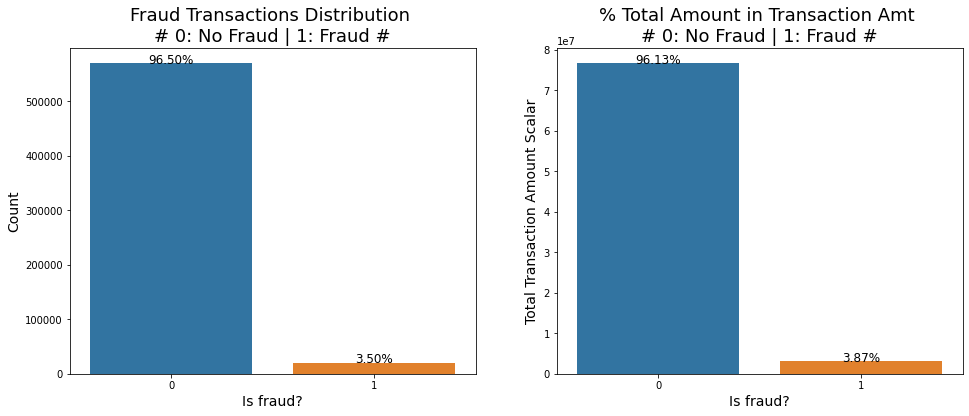

In [12]:
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=train_transaction_df)
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=18)
g.set_xlabel("Is fraud?", fontsize=14)
g.set_ylabel('Count', fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 


plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amount)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=18)
g1.set_xlabel("Is fraud?", fontsize=14)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=14)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=12) 
    
plt.show()


We have an imbalanced dataset with barely 3.5% of the transactions as fraudulent as would be expected in practice. Where `1` represents fraud and `0` absence of fraud

### Transaction Amount Outliers

It's considering outlier values that are highest than 3 times the std from the mean

In [13]:
Calc_Outliers(train_transaction_df['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


We have 10K rows with outliers that represent 1.74% of the total rows

### Product Features

Let's look at the product features
- Distribution of products
- Fraud Distribution by product
- Difference in Transaction Amounts between products


In [14]:
products = pd.crosstab(train_transaction_df['ProductCD'], train_transaction_df['isFraud'], normalize = 'index') * 100
products = products.reset_index()
products.rename(columns = {0 : 'No Fraud', 1 : 'Fraud'}, inplace = True)
products

isFraud ProductCD   No Fraud      Fraud
0               C  88.312731  11.687269
1               H  95.233769   4.766231
2               R  96.217406   3.782594
3               S  94.100447   5.899553
4               W  97.960061   2.039939

Let's proceed to plot out the distributions

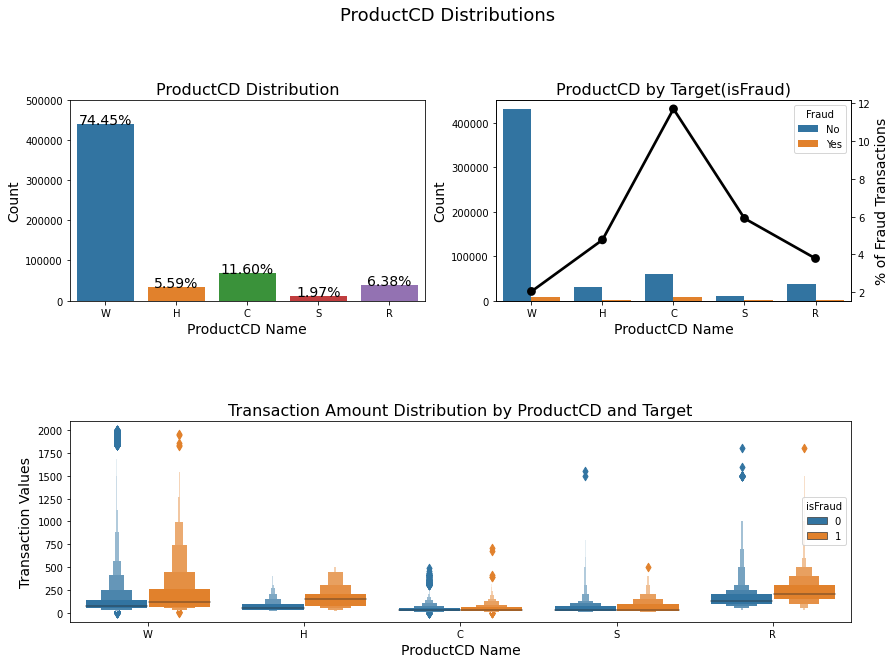

In [15]:
plt.figure(figsize = (14,10))
plt.suptitle('ProductCD Distributions', fontsize = 18)

plt.subplot(221)
g = sns.countplot(x = 'ProductCD', data = train_transaction_df)
g.set_title('ProductCD Distribution', fontsize = 16)
g.set_xlabel('ProductCD Name', fontsize = 14)
g.set_ylabel('Count', fontsize = 14)
g.set_ylim(0, 500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
plt.subplot(222)
g1 = sns.countplot(x = 'ProductCD', hue = 'isFraud', data = train_transaction_df)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=products, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel('% of Fraud Transactions', fontsize=14)
g1.set_title('ProductCD by Target(isFraud)', fontsize = 16)
g1.set_xlabel('ProductCD Name', fontsize = 14)
g1.set_ylabel('Count', fontsize = 14)

plt.subplot(212)
g3 = sns.boxenplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud', 
                   data = train_transaction_df[train_transaction_df['TransactionAmt'] <= 2000])
g3.set_title("Transaction Amount Distribution by ProductCD and Target", fontsize=16)
g3.set_xlabel("ProductCD Name", fontsize=14)
g3.set_ylabel("Transaction Values", fontsize=14)

plt.subplots_adjust(hspace = 0.6, top = 0.85)


W, C and R are the most frequent observations. Special attention is to be given to Product C, the most vulnerable to credit card fraud in our dataset; It's fraud rate is near three times the next product class 

## Card Features
Based on the competition description, card features are categoricals.
- Lets understand the distribution of values
- What's the difference in transactions and % of Fraud for each values in these features
- Card features has 6 columns, and 4 of them seems to be numericals, so lets see the quantiles and distributions

In [16]:
# Let's look at the card features

resume_table(train_transaction_df[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


Name   dtypes  Missing  Uniques First Value Second Value Third Value  \
0  card1    int16        0    13553       13926         2755        4663   
1  card2  float16     8933      500         NaN          404         490   
2  card3  float16     1565      114         150          150         150   
3  card4   object     1577        4    discover   mastercard        visa   
4  card5  float16     4259      119         142          102         166   
5  card6   object     1571        4      credit       credit       debit   

   Entropy  
0     9.97  
1     6.32  
2     0.68  
3     1.09  
4     2.66  
5     0.82

In [17]:
print('Card Features Quantiles')
print(train_transaction_df[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


`card2` - `card6` have missing values. We will review that later. `card1` and `card2` have a large distribution of values therefore let's take the logarithms of these columns

### Visualizing Card distribution

In [18]:
train_transaction_df.loc[train_transaction_df.card3.isin(train_transaction_df.card3.value_counts()[train_transaction_df.card3.value_counts() < 200].index), 'card3'] = 'Others'
train_transaction_df.loc[train_transaction_df.card5.isin(train_transaction_df.card5.value_counts()[train_transaction_df.card5.value_counts() < 300].index), 'card5'] = 'Others'

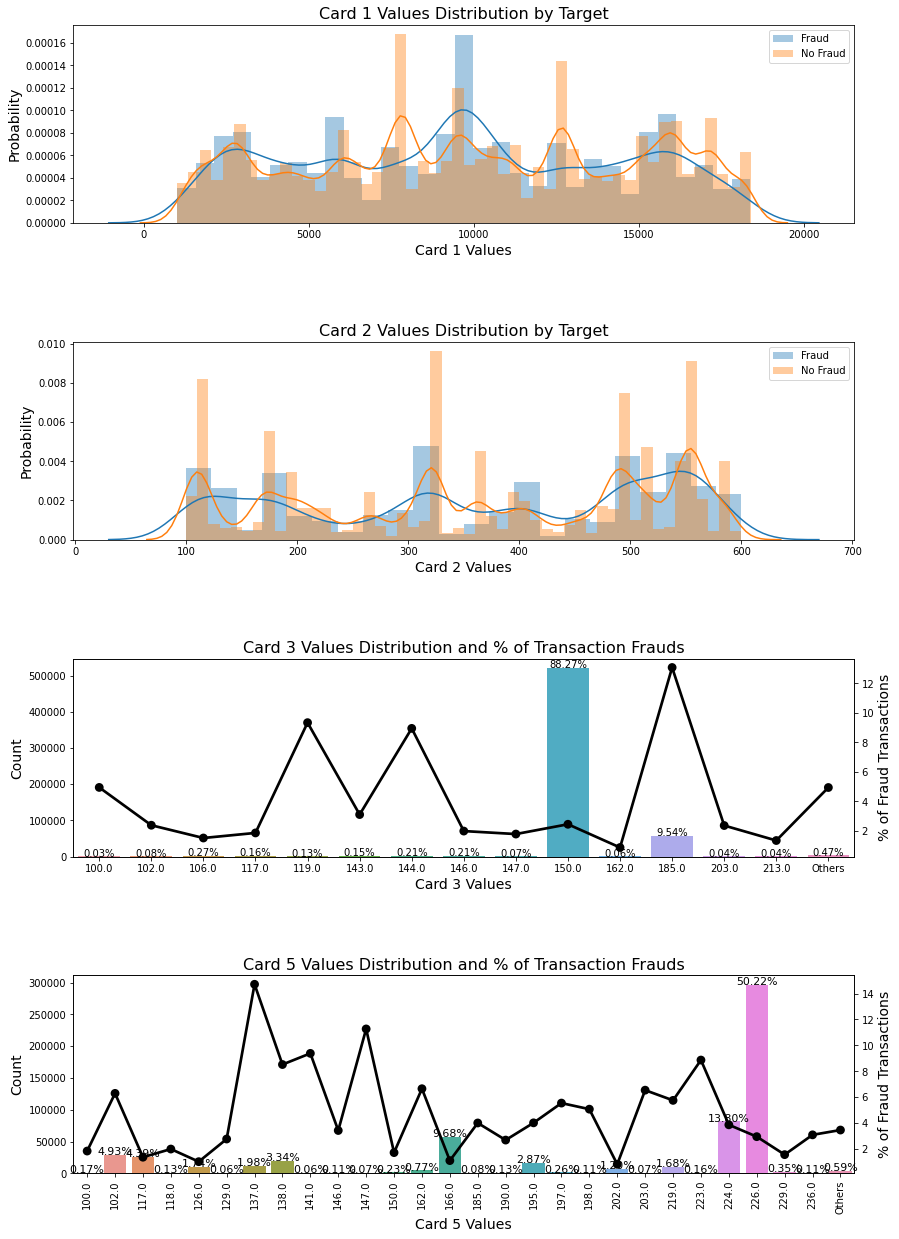

In [19]:
tmp = pd.crosstab(train_transaction_df['card3'], train_transaction_df['isFraud'], normalize = 'index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train_transaction_df['card5'], train_transaction_df['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(train_transaction_df[train_transaction_df['isFraud'] == 1]['card1'], label = 'Fraud')
g = sns.distplot(train_transaction_df[train_transaction_df['isFraud'] == 0]['card1'], label = 'No Fraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=16)
g.set_xlabel("Card 1 Values", fontsize=14)
g.set_ylabel("Probability", fontsize=14)

plt.subplot(412)
g1 = sns.distplot(train_transaction_df[train_transaction_df['isFraud'] == 1]['card2'].dropna(), label = 'Fraud')
g1 = sns.distplot(train_transaction_df[train_transaction_df['isFraud'] == 0]['card2'].dropna(), label = 'No Fraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=16)
g1.set_xlabel("Card 2 Values", fontsize=14)
g1.set_ylabel("Probability", fontsize=14)

plt.subplot(413)
g2 = sns.countplot(x = 'card3', data = train_transaction_df, order = list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x = 'card3', y = 'Fraud', data = tmp, color = 'black', order = list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=14)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=16)
g2.set_xlabel("Card 3 Values", fontsize=14)
g2.set_ylabel("Count", fontsize=14)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 
    
plt.subplot(414)
g3 = sns.countplot(x='card5', data=train_transaction_df, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=14)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=16)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=14)
g3.set_ylabel("Count", fontsize=14)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)

In `card3` card value 150 has the most count of transactions in our dataset while card value 185 has the highest percentage of frauulent transactions. In `card5` as well, we see a similar pattern card value 226 is the most common, while card value 137 has the highest percentage of fraud

## Card 4

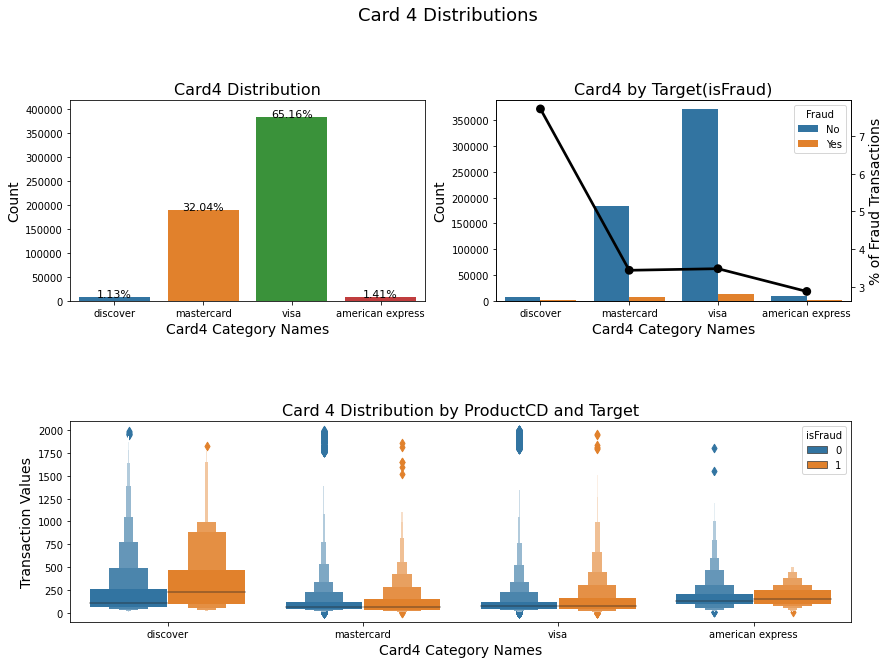

In [21]:
tmp = pd.crosstab(train_transaction_df['card4'], train_transaction_df['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=18)

plt.subplot(221)
g = sns.countplot(x='card4', data=train_transaction_df)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=16)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=14)
g.set_ylabel("Count", fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11)
    
plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=train_transaction_df)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=14)
g1.set_title("Card4 by Target(isFraud)", fontsize=16)
g1.set_xlabel("Card4 Category Names", fontsize=14)
g1.set_ylabel("Count", fontsize=14)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train_transaction_df[train_transaction_df['TransactionAmt'] <= 2000])
g3.set_title("Card 4 Distribution by ProductCD and Target", fontsize=16)
g3.set_xlabel("Card4 Category Names", fontsize=14)
g3.set_ylabel("Transaction Values", fontsize=14)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

`Visa`  is the most common card network processor in our training dataset at 65% followed by `Mastercard` at 32%. This is consistent with the [US credit card market share](https://cardflash.com/news/2018/12/visa-u-s-marketshare-grows-at-expense-of-mastercard-and-american-express/) by cardflash.com  ![](https://1jznao4f1hdv32zb033wmr4m-wpengine.netdna-ssl.com/wp-content/uploads/2018/12/visa-u.s.-marketshare-grows-at-expense-of-mastercard-and-american-express.png)

`discover` however is the card network processor with the most fraudulent transactions at (~8%)

In [22]:
tmp = pd.crosstab(train_transaction_df['card4'], train_transaction_df['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
tmp

isFraud             card4    NoFraud     Fraud
0        american express  97.130163  2.869837
1                discover  92.271839  7.728161
2              mastercard  96.566905  3.433095
3                    visa  96.524390  3.475610

In [23]:
tmp_plot = train_transaction_df.groupby(['card4','isFraud']).size().reset_index().pivot(columns = 'isFraud', index = 'card4', values = 0)
tmp_plot

isFraud                0      1
card4                          
american express    8089    239
discover            6137    514
mastercard        182721   6496
visa              371394  13373

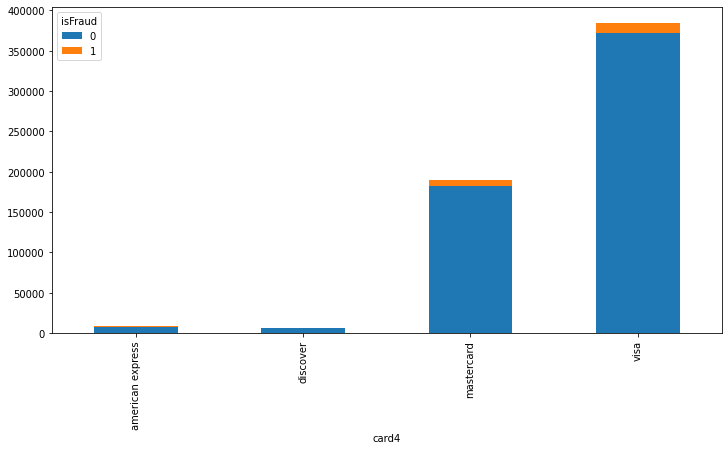

In [24]:
tmp_plot.plot(kind='bar', stacked=True, figsize = (12,6));

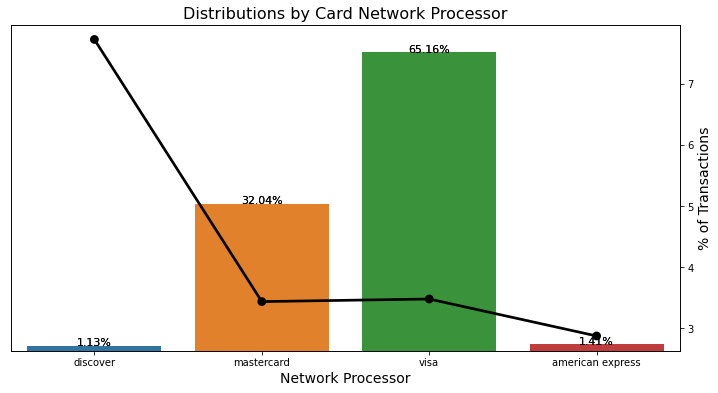

In [25]:
plt.figure(figsize=(12,6))
# plt.suptitle('Distributions by Card Network Processor', fontsize=18)

g = sns.countplot(x='card4', data=train_transaction_df)
g.set_title("Distributions by Card Network Processor", fontsize=16)
g.set_ylim(0,420000)
g.set_xlabel("Card Network processors", fontsize=16)
g.set_ylabel(None)
g.axes.yaxis.set_ticks([])
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11)
gt = g.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Transactions", fontsize=14)
# g.set_title("Card4 by Target(isFraud)", fontsize=16)
g.set_xlabel("Network Processor", fontsize=14)
g1.set_ylabel("Count", fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11)


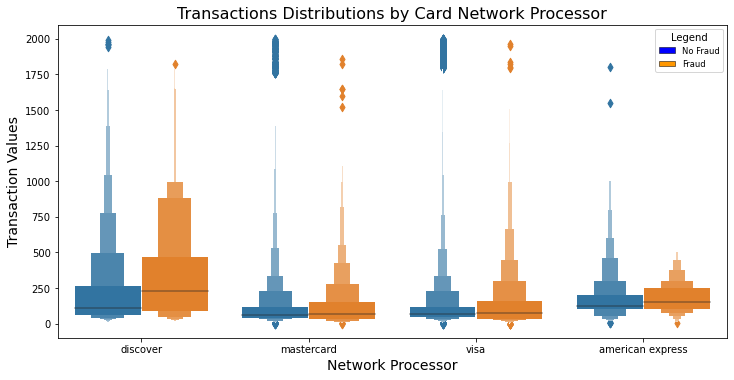

In [26]:
plt.figure(figsize=(12,6))

g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train_transaction_df[train_transaction_df['TransactionAmt'] <= 2000])
g3.set_title("Transactions Distributions by Card Network Processor", fontsize=16)
g3.set_xlabel("Network Processor", fontsize=14)
g3.set_ylabel("Transaction Values", fontsize=14)

one = mpatches.Patch(facecolor='Blue', label='No Fraud', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='#ff9700', label = 'Fraud', linewidth = 0.5, edgecolor = 'black')
g3.legend(handles = [one,two], title = 'Legend', loc = 'best', fontsize = 'small', fancybox = True)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

## Card 6

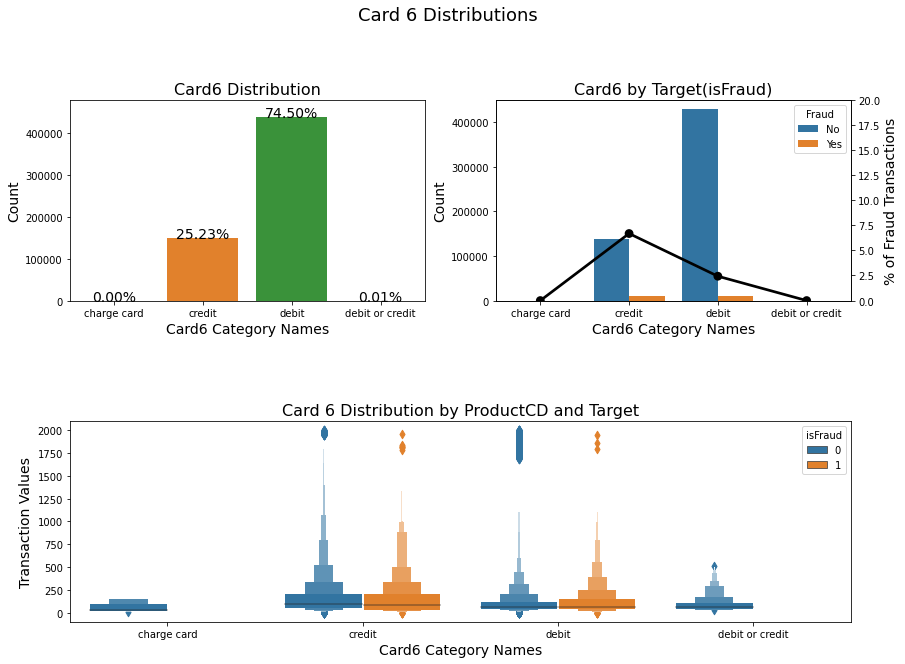

In [27]:
tmp = pd.crosstab(train_transaction_df['card6'], train_transaction_df['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=18)

plt.subplot(221)
g = sns.countplot(x='card6', data=train_transaction_df, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=16)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=14)
g.set_ylabel("Count", fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 
    
plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=train_transaction_df, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=14)
g1.set_title("Card6 by Target(isFraud)", fontsize=16)
g1.set_xlabel("Card6 Category Names", fontsize=14)
g1.set_ylabel("Count", fontsize=14)

plt.subplot(212)
g3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=train_transaction_df[train_transaction_df['TransactionAmt'] <= 2000] )
g3.set_title("Card 6 Distribution by ProductCD and Target", fontsize=16)
g3.set_xlabel("Card6 Category Names", fontsize=14)
g3.set_ylabel("Transaction Values", fontsize=14)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

`debit` cards make up 74% of the observations in our dataset however fraud is more prevalent in `credit` cards. The distribution of `TransactionAmt` don't show distinct differences

## Exploring M1-M9 features

In [28]:
# Let's look at the M1 - M9 features

resume_table(train_transaction_df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']])

Dataset Shape: (590540, 9)


Name  dtypes  Missing  Uniques First Value Second Value Third Value  Entropy
0   M1  object   271100        2           T          NaN           T     0.00
1   M2  object   271100        2           T          NaN           T     0.49
2   M3  object   271100        2           T          NaN           T     0.75
3   M4  object   281444        3          M2           M0          M0     1.31
4   M5  object   350482        2           F            T           F     0.99
5   M6  object   169360        2           T            T           F     1.00
6   M7  object   346265        2         NaN          NaN           F     0.57
7   M8  object   346252        2         NaN          NaN           F     0.95
8   M9  object   346252        2         NaN          NaN           F     0.63

In [29]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train_transaction_df[col] = train_transaction_df[col].fillna('Miss')

In [30]:
resume_table(train_transaction_df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']])

Dataset Shape: (590540, 9)


Name  dtypes  Missing  Uniques First Value Second Value Third Value  Entropy
0   M1  object        0        3           T         Miss           T     1.00
1   M2  object        0        3           T         Miss           T     1.26
2   M3  object        0        3           T         Miss           T     1.40
3   M4  object        0        4          M2           M0          M0     1.68
4   M5  object        0        3           F            T           F     1.38
5   M6  object        0        3           T            T           F     1.57
6   M7  object        0        3        Miss         Miss           F     1.21
7   M8  object        0        3        Miss         Miss           F     1.37
8   M9  object        0        3        Miss         Miss           F     1.24

In [31]:
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=18)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCount and %Fraud by each category", fontsize=16)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=14)
    g.set_xlabel(f"{col} Category Names", fontsize=14)
    g.set_ylabel("Count", fontsize=14)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (train_transaction_df.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=14)
    g1.set_title(f"{col} by Transactions dist", fontsize=16)
    g1.set_xlabel(f"{col} Category Names", fontsize=14)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=14)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

### M distributions

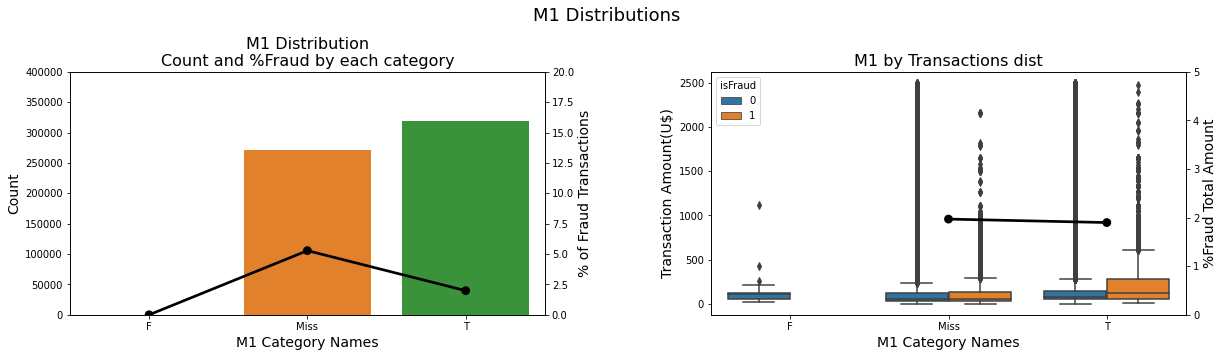

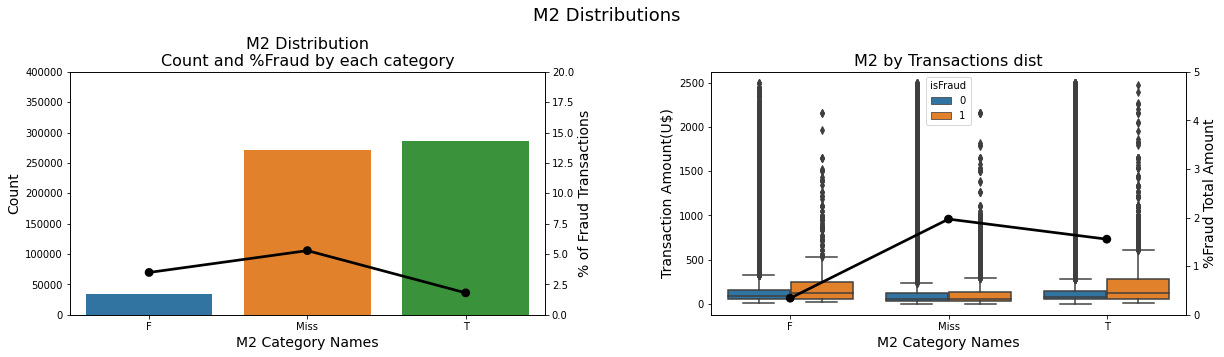

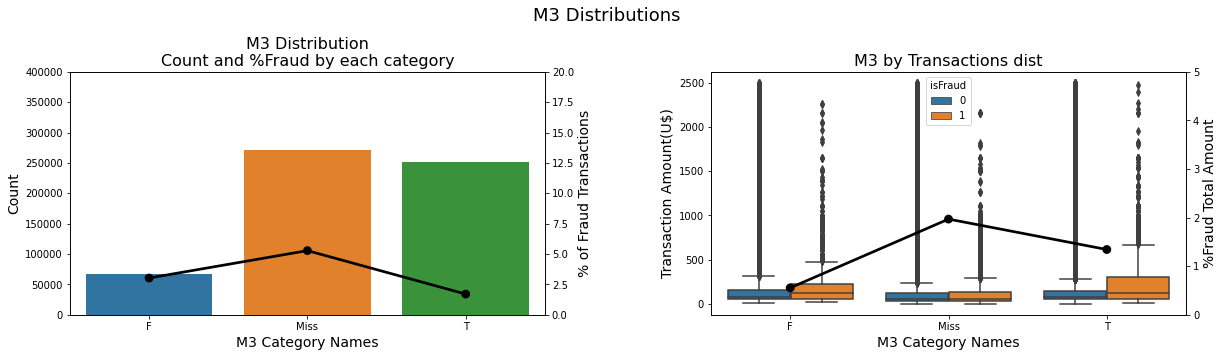

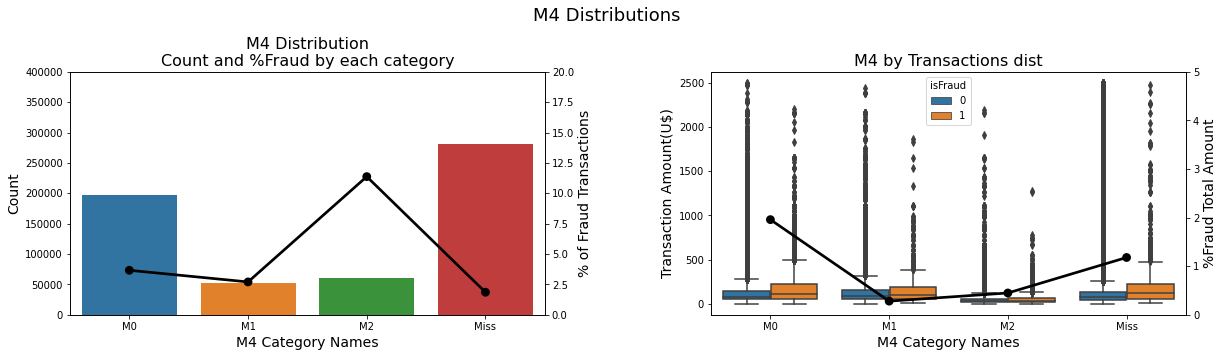

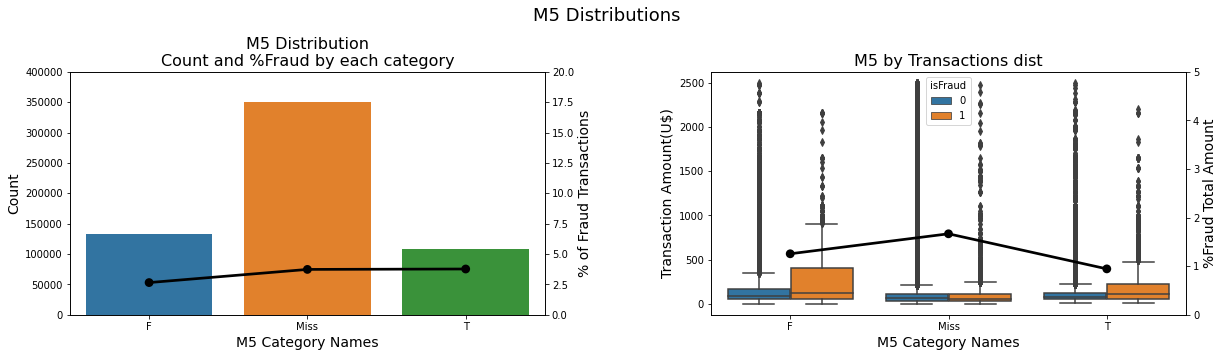

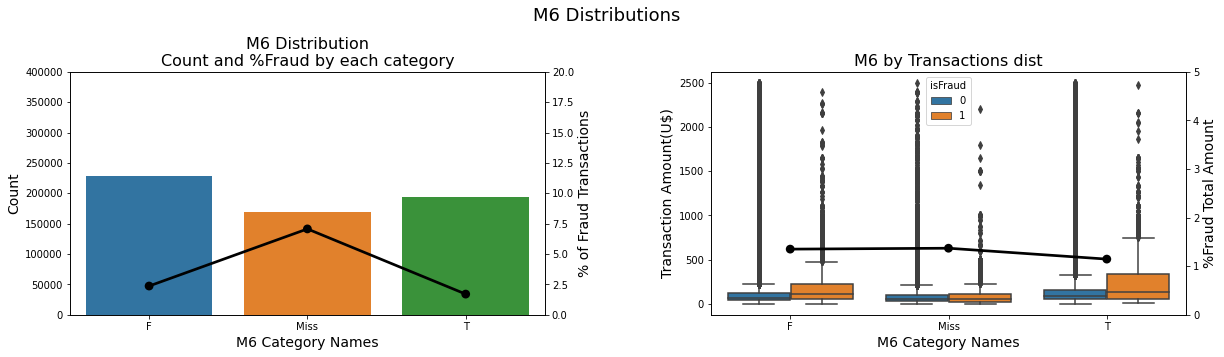

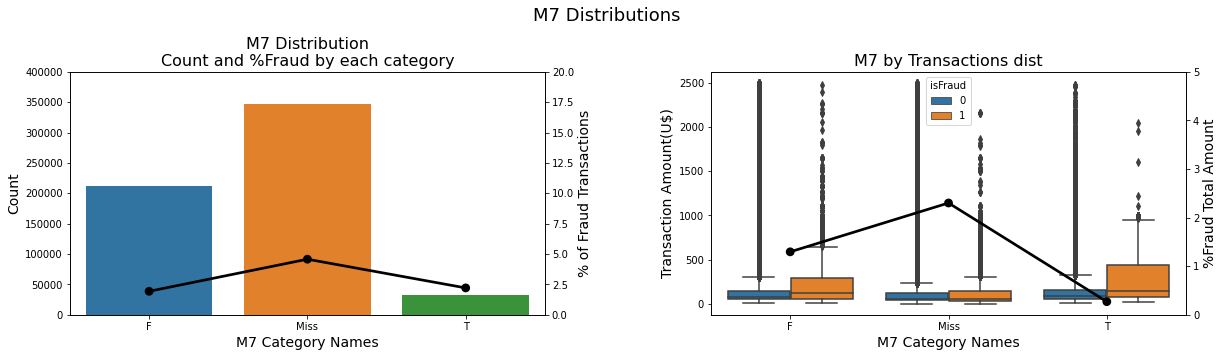

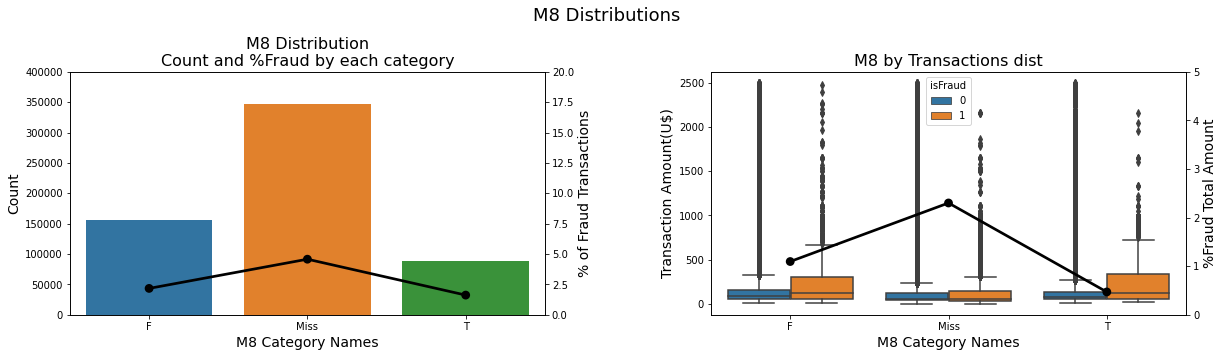

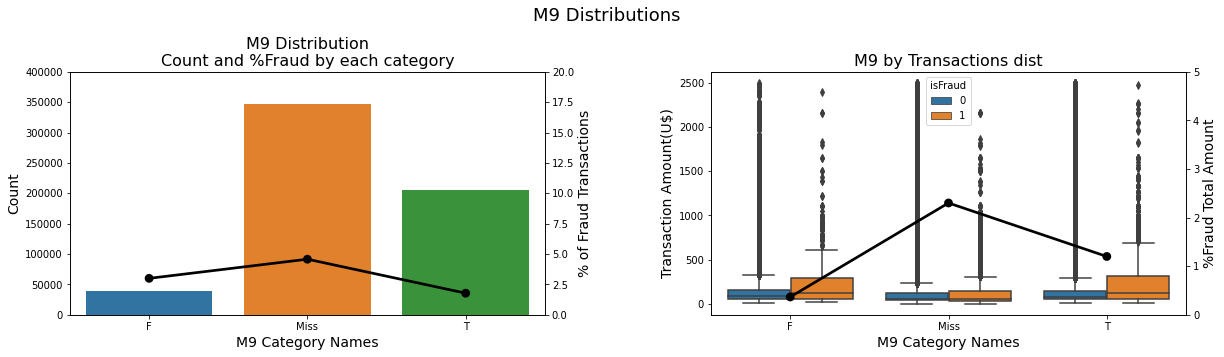

In [32]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train_transaction_df, col, lim=2500)

## Addr1 and Addr2

In [33]:
print("Card Features Quantiles: ")
print(train_transaction_df[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


In [34]:
train_transaction_df.loc[train_transaction_df.addr1.isin(train_transaction_df.addr1.value_counts()[train_transaction_df.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train_transaction_df.loc[train_transaction_df.addr2.isin(train_transaction_df.addr2.value_counts()[train_transaction_df.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

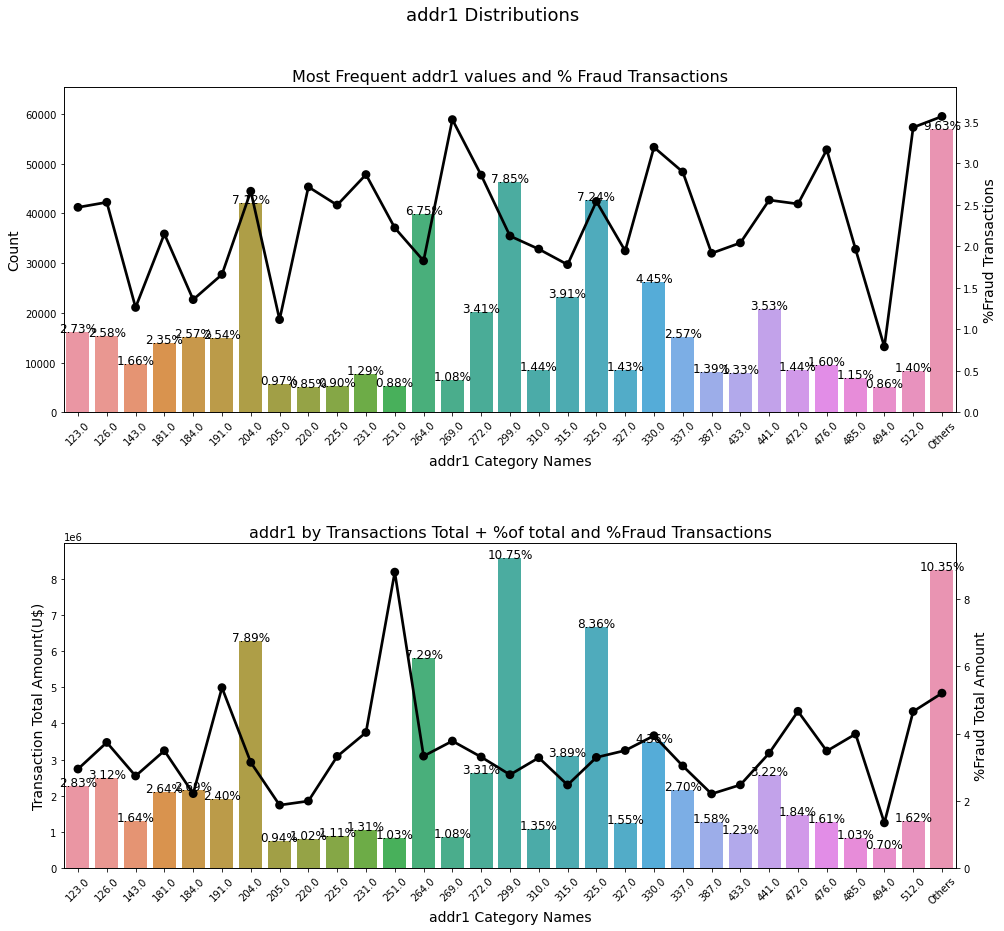

In [35]:
 def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=18)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=14)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=14)
    g.set_ylabel("Count", fontsize=14)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=14)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=16)
    g1.set_xlabel(f"{col} Category Names", fontsize=14)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=14)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(train_transaction_df, 'addr1')

### Addr2

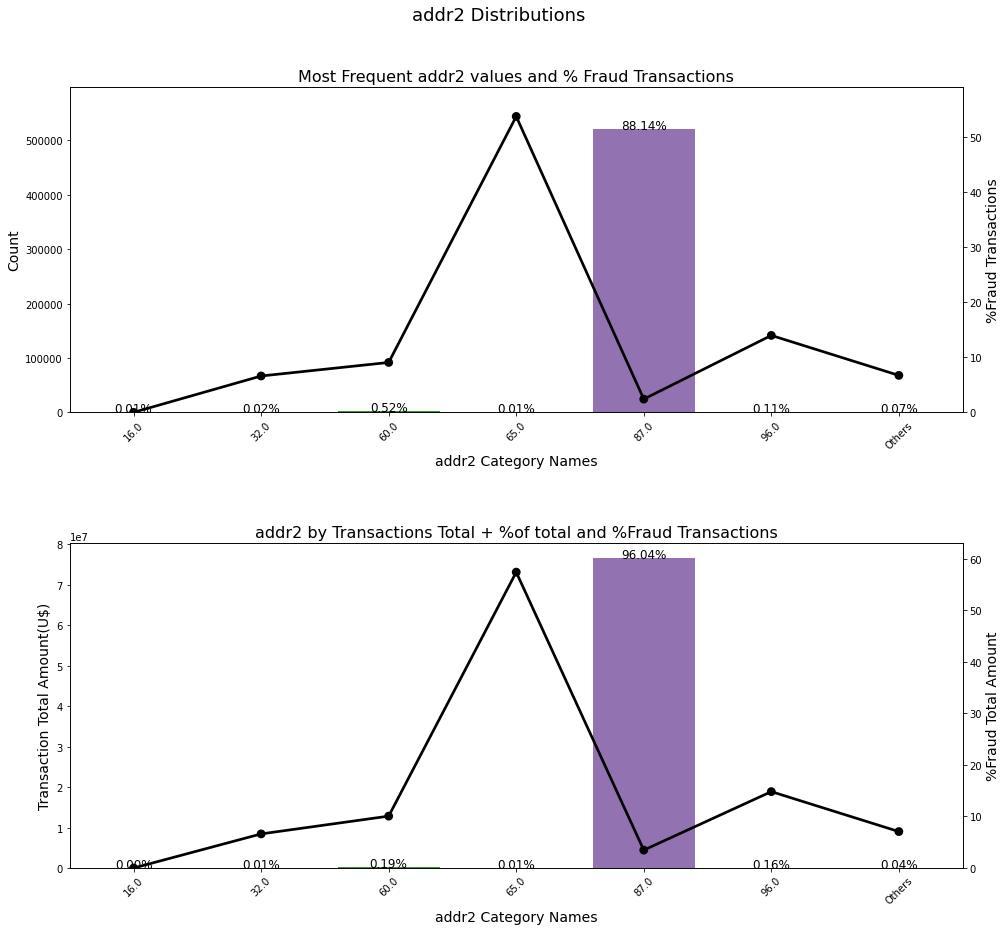

In [36]:
ploting_cnt_amt(train_transaction_df, 'addr2')

## P emaildomain Distributions

In [37]:
train_transaction_df['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [38]:
train_transaction_df.loc[train_transaction_df['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'
train_transaction_df.loc[train_transaction_df['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk',
                                                                    'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                                                    'yahoo.es', '']),'P_emaildomain'] = 'Yahoo Mail'
train_transaction_df.loc[train_transaction_df['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train_transaction_df.loc[train_transaction_df.P_emaildomain.isin(train_transaction_df.P_emaildomain\
                                         .value_counts()[train_transaction_df.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train_transaction_df.P_emaildomain.fillna("NoInf", inplace=True)

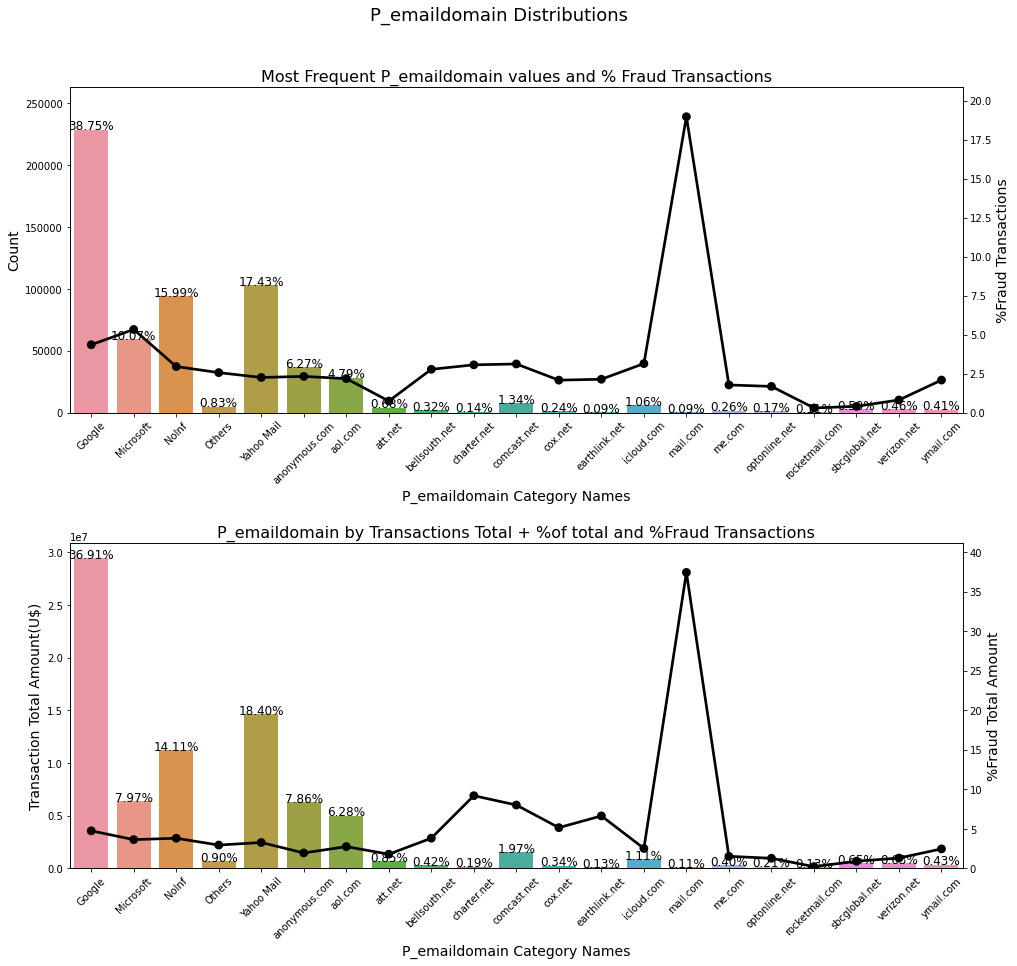

In [39]:
ploting_cnt_amt(train_transaction_df, 'P_emaildomain')

`Google` is the most common email address in our database. Fraud however is highest at `mail.com` they probably have vulnerabilities

## R_emaildomain

In [40]:
train_transaction_df['R_emaildomain'].value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [41]:
train_transaction_df.loc[train_transaction_df['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'
train_transaction_df.loc[train_transaction_df['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk',
                                                                    'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                                                    'yahoo.es', '']),'R_emaildomain'] = 'Yahoo Mail'
train_transaction_df.loc[train_transaction_df['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
train_transaction_df.loc[train_transaction_df.R_emaildomain.isin(train_transaction_df.R_emaildomain\
                                         .value_counts()[train_transaction_df.R_emaildomain.value_counts() <= 500 ]\
                                         .index), 'R_emaildomain'] = "Others"
train_transaction_df.R_emaildomain.fillna("NoInf", inplace=True)

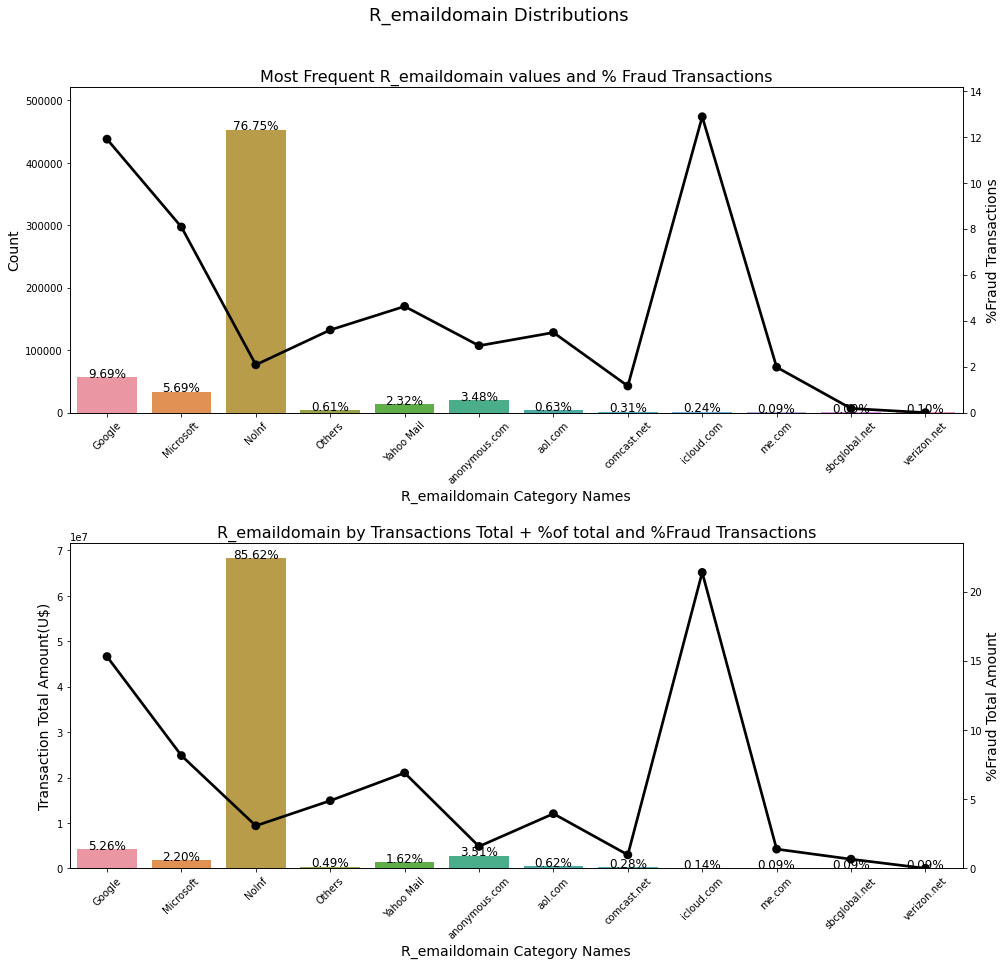

In [42]:
ploting_cnt_amt(train_transaction_df, 'R_emaildomain')

In this case we have no information on most of the emails and to note fraud is most prevalent in `Google` and `icloud.com`

## C1-C14 features
- Let's understand what this features are.
- What's the distributions?

In [43]:
resume_table(train_transaction_df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value  \
0    C1  float16        0     1495          1.0           1.0          1.0   
1    C2  float16        0     1167          1.0           1.0          1.0   
2    C3  float16        0       27          0.0           0.0          0.0   
3    C4  float16        0     1223          0.0           0.0          0.0   
4    C5  float16        0      319          0.0           0.0          0.0   
5    C6  float16        0     1291          1.0           1.0          1.0   
6    C7  float16        0     1069          0.0           0.0          0.0   
7    C8  float16        0     1130          0.0           0.0          0.0   
8    C9  float16        0      205          1.0           0.0          1.0   
9   C10  float16        0     1122          0.0           0.0          0.0   
10  C11  float16        0     1343          2.0           1.0          1.0   
11  C12  float16        0     1066          0.0           0.0          0.0   
12  C13  float16        0     1464          1.0           1.0          1.0   
13  C14  float16        0     1108          1.0           1.0          1.0   

    Entropy  
0      2.72  
1      2.75  
2      0.04  
3      1.12  
4      2.06  
5      2.52  
6      0.71  
7      1.25  
8      2.62  
9      1.23  
10     2.17  
11     0.95  
12     4.66  
13     2.67

In [44]:
train_transaction_df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

C1        C2             C3        C4        C5        C6  \
count  590540.0  590540.0  590540.000000  590540.0  590540.0  590540.0   
mean        NaN       NaN       0.005650       NaN       NaN       NaN   
std         NaN       NaN       0.150635       NaN       NaN       NaN   
min         0.0       0.0       0.000000       0.0       0.0       0.0   
25%         1.0       1.0       0.000000       0.0       0.0       1.0   
50%         1.0       1.0       0.000000       0.0       0.0       1.0   
75%         3.0       3.0       0.000000       0.0       1.0       2.0   
max      4684.0    5692.0      26.000000    2252.0     349.0    2252.0   

             C7        C8        C9       C10       C11       C12       C13  \
count  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0   
mean        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
std         NaN       NaN       0.0       NaN       NaN       NaN       NaN   
min         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
25%         0.0       0.0       0.0       0.0       1.0       0.0       1.0   
50%         0.0       0.0       1.0       0.0       1.0       0.0       3.0   
75%         0.0       0.0       2.0       0.0       2.0       0.0      12.0   
max      2256.0    3332.0     210.0    3256.0    3188.0    3188.0    2918.0   

            C14  
count  590540.0  
mean        NaN  
std         NaN  
min         0.0  
25%         1.0  
50%         1.0  
75%         2.0  
max      1429.0

In [45]:
train_transaction_df.loc[train_transaction_df.C1.isin(train_transaction_df.C1\
                              .value_counts()[train_transaction_df.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

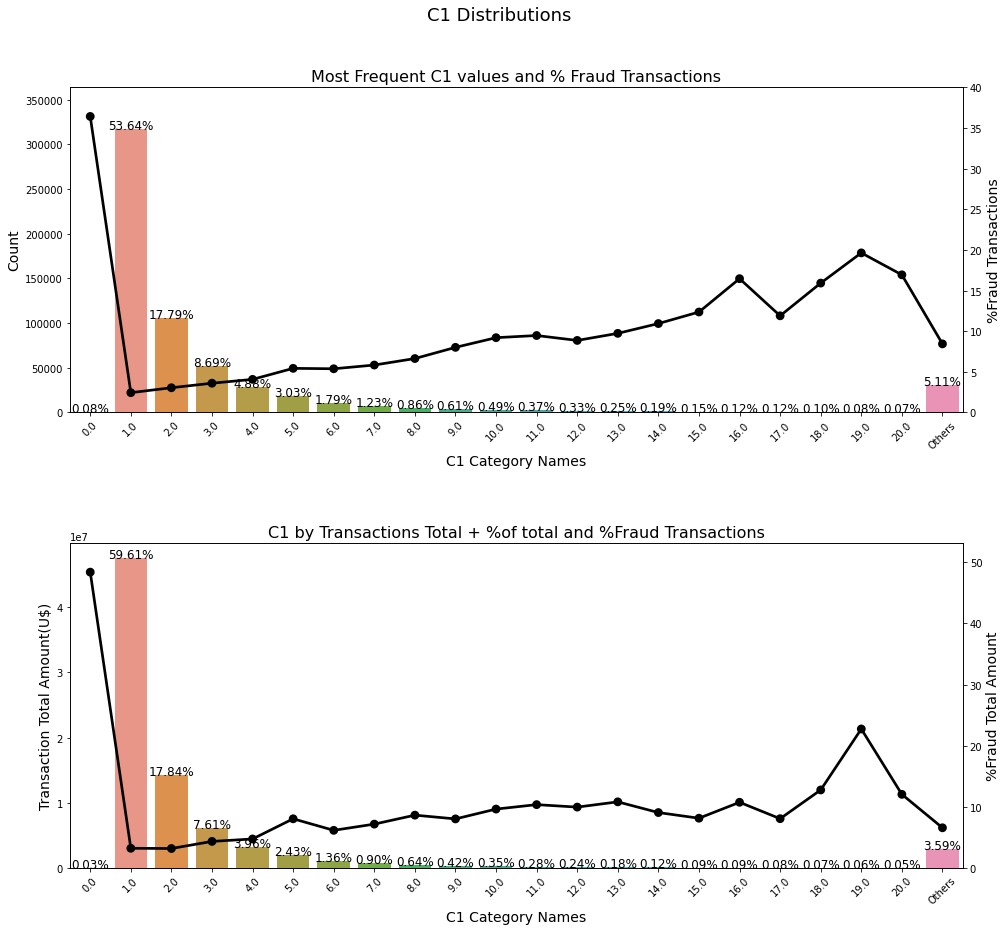

In [46]:
ploting_cnt_amt(train_transaction_df, 'C1')

In [47]:
train_transaction_df.loc[train_transaction_df.C2.isin(train_transaction_df.C2\
                              .value_counts()[train_transaction_df.C2.value_counts() <= 400 ]\
                              .index), 'C2'] = "Others"

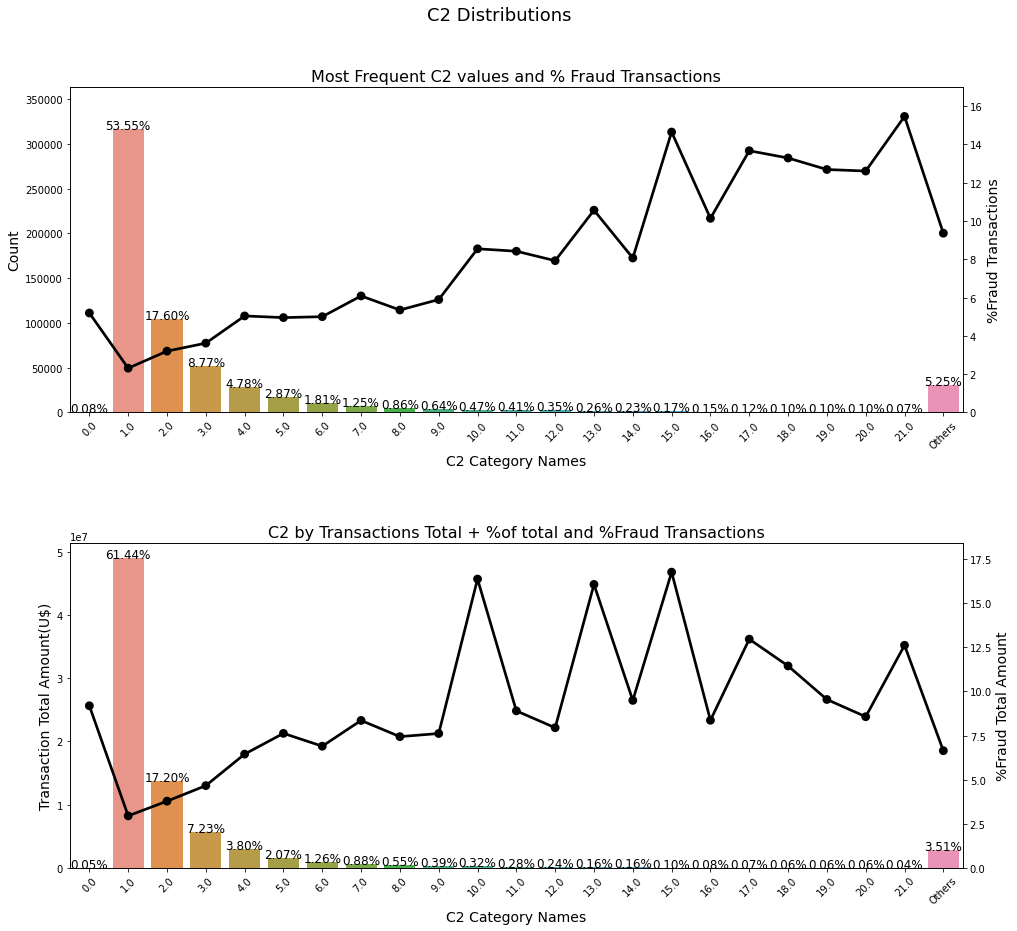

In [48]:
ploting_cnt_amt(train_transaction_df, 'C2')

`1`,`2` & `3` are the top 3 C values

## TimeDelta Feature
- Let's see if the frauds have some specific hour that has highest % of frauds

### Converting to Total Days, Weekdays and Hours

In discussions tab there's excellent solution to [Timedelta column](https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480);

In [49]:
START_DATE = '2017-12-01'

startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train_transaction_df['Date'] = train_transaction_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

train_transaction_df['Weekdays'] = train_transaction_df['Date'].dt.dayofweek
train_transaction_df['Hours'] = train_transaction_df['Date'].dt.hour
train_transaction_df['Days'] = train_transaction_df['Date'].dt.day

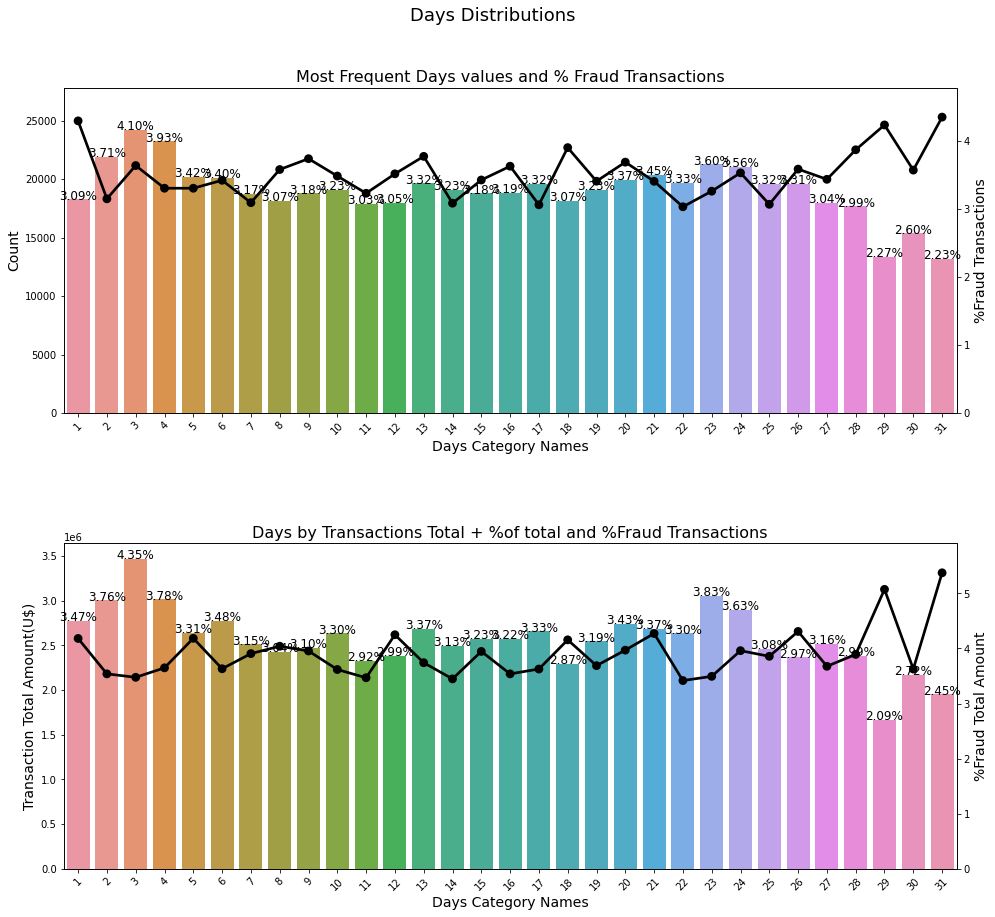

In [50]:
ploting_cnt_amt(train_transaction_df, 'Days')

In [51]:
def plotting_days_trend(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
#     plt.suptitle(f'Fraudulent Transactions distributed by {col} of the month', fontsize=18)
    
    plt.subplot(211)
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                        color='black', legend=False, )
    gt.set_title(f'Fraudulent Transactions distributed by {col} of the month', fontsize=16)
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=14)
    gt.set_ylim(2,5)
    gt.set_xlabel(f"{col} of the month", fontsize=14)
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)

    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()
    

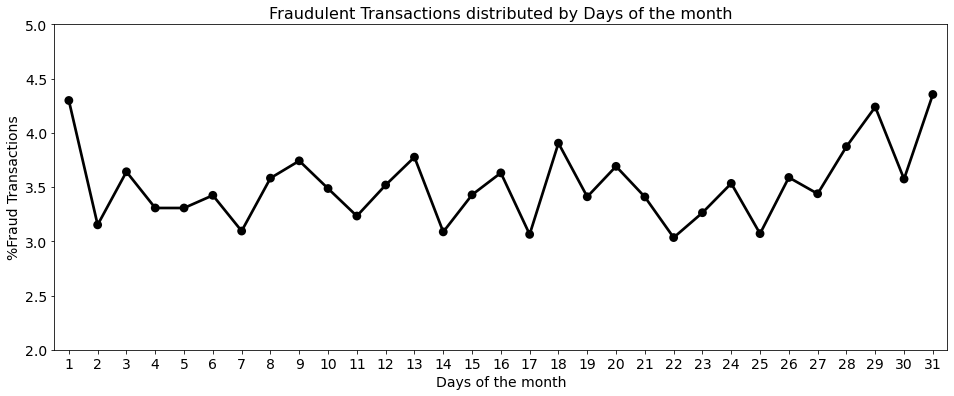

In [52]:
plotting_days_trend(train_transaction_df, 'Days')

Most fraud cases by frequency and value happen around end of month

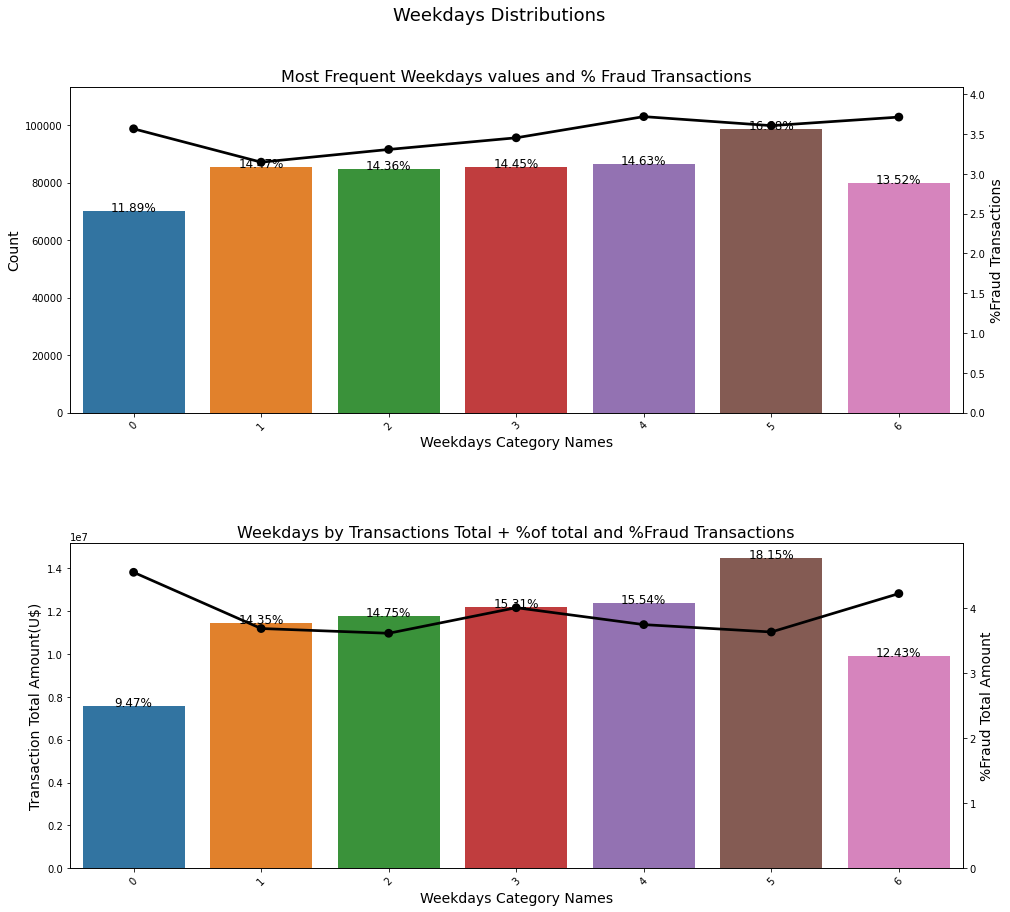

In [53]:
ploting_cnt_amt(train_transaction_df, 'Weekdays')

In [54]:
tmp = pd.crosstab(train_transaction_df['Weekdays'], train_transaction_df['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
tmp

isFraud  Weekdays    NoFraud     Fraud
0               0  96.435641  3.564359
1               1  96.854845  3.145155
2               2  96.695160  3.304840
3               3  96.548573  3.451427
4               4  96.282575  3.717425
5               5  96.396012  3.603988
6               6  96.288549  3.711451

In [55]:
train_transaction_df['Weekdays']

0         5
1         5
2         5
3         5
4         5
         ..
590535    4
590536    4
590537    4
590538    4
590539    4
Name: Weekdays, Length: 590540, dtype: int64

In [56]:
# train_transaction_df['Weekdays'] = train_transaction_df['Weekdays'].replace([0, 1, 2, 3, 4, 5, 6], ['Sunday', 'Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday'])

In [57]:
# tmp = pd.crosstab(train_transaction_df['Weekdays'], train_transaction_df['isFraud'], normalize='index') * 100
# tmp = tmp.reset_index()
# tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
# tmp 

In [58]:
def plotting_Weekdays_trend(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
#     plt.suptitle(f'Fraudulent Transactions distributed by days of the week', fontsize=18)
    
    plt.subplot(211)
    gt = sns.pointplot(x=col, y='Fraud', data=tmp , order=list(tmp[col].values),
                        color='black', legend=False)
    gt.set_title('Fraudulent Transactions distributed by days of the week', fontsize=16)
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=14)
    gt.set_ylim(3,4)
    gt.set_xlabel(None)
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.gca().set_xticklabels(\
    ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()

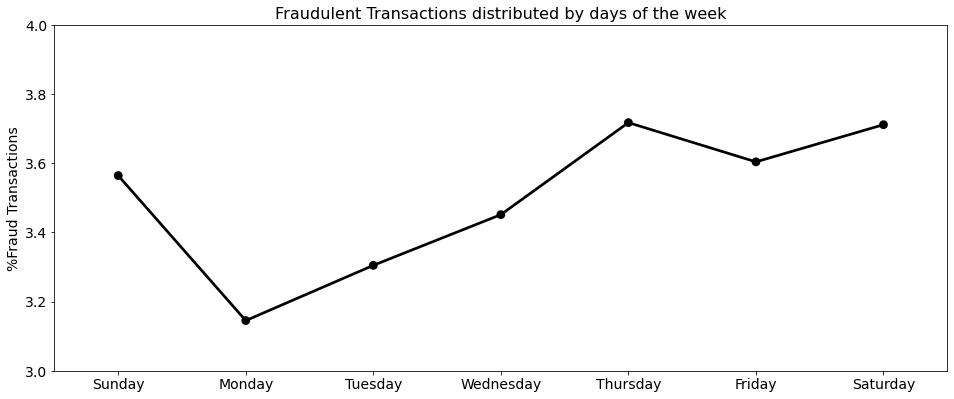

In [59]:
plotting_Weekdays_trend(train_transaction_df, 'Weekdays')

We don't have date references in our dataset however, we can infer `0` and `6` refer to Sunday and Saturday given the relatively lower frequency and amount of transactions

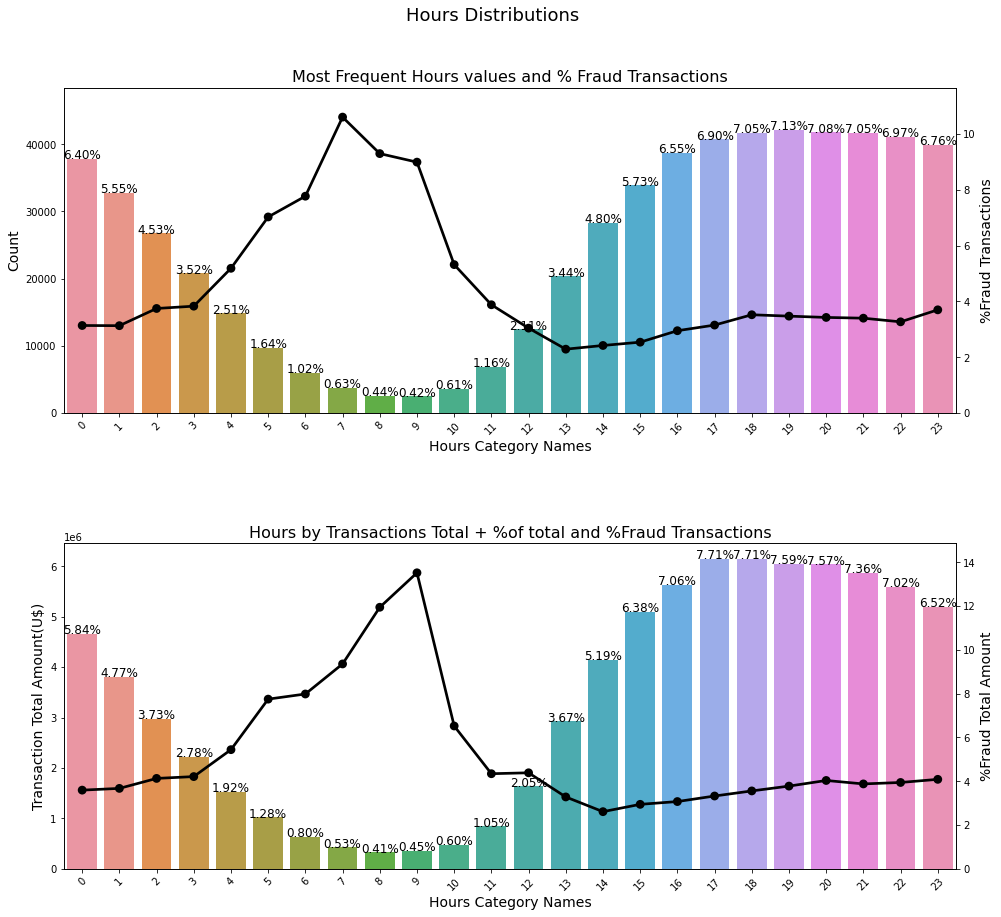

In [60]:
ploting_cnt_amt(train_transaction_df, 'Hours')

Figure caption: The right axis displays the number/Transaction Amount of transactions in that hour interval (coloured bar graphs) and the left axis the fraction of fraudulent transactions in that hour (solid black line)

If this is correct a 10% of transactions are fraudulent at certain times of day! Notably, the high fraction of fraudulent transactions occur when there is a low number of transactions per hour (e.g., you could imagine around 4-7 am when most people are asleep or getting ready to go to work and not spending) and could reflect international fraud where a card is being used in a country different to where it was issued.

This should be a useful feature to include in your models and I look forward to seeing any other analysis of the time feature.

In [61]:
def plotting_hours_trend(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
#     plt.suptitle(f'Fraudulent Transactions distributed by {col} of the day', fontsize=18)
    
    plt.subplot(211)
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                        color='black', legend=False, )
    gt.set_title(f'Fraudulent Transactions distributed by {col} of the day', fontsize=16)
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=14)
    gt.set_xlabel(f"{col} of the day", fontsize=14)
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)

    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()
    

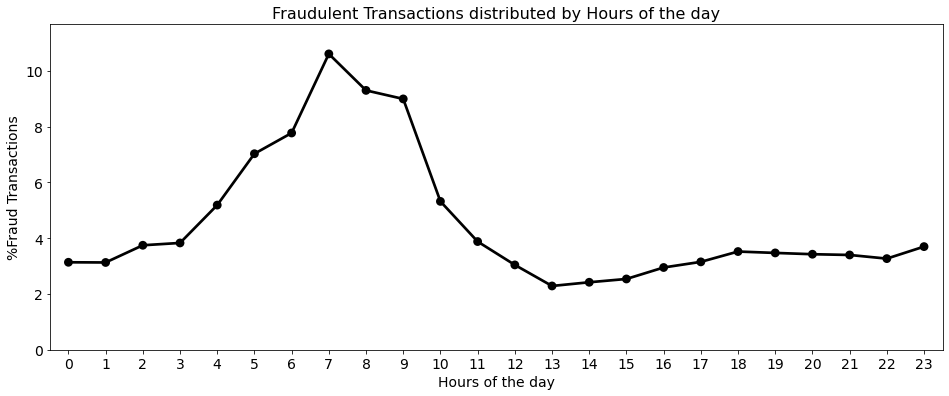

In [62]:
plotting_hours_trend(train_transaction_df, 'Hours')

### Daily Transactions

In [63]:
#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

dates_temp = train_transaction_df.groupby(train_transaction_df.Date.dt.date)['TransactionAmt'].count().reset_index()
dates_temp

Date  TransactionAmt
0    2017-12-02            5122
1    2017-12-03            3730
2    2017-12-04            3241
3    2017-12-05            4036
4    2017-12-06            3964
..          ...             ...
177  2018-05-28            2068
178  2018-05-29            2177
179  2018-05-30            2618
180  2018-05-31            2739
181  2018-06-01            2754

[182 rows x 2 columns]

In [64]:
# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp['Date'], y=dates_temp.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[7]), name= 'Total Transactions')

# Below we will get the total amount sold
dates_temp_sum = train_transaction_df.groupby(train_transaction_df.Date.dt.date)['TransactionAmt'].sum().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.Date, line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                 dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1,], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

### Fraud in Daily Transactions

In [65]:
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

tmp_amt = train_transaction_df.groupby([train_transaction_df.Date.dt.date, 'isFraud'])['TransactionAmt'].sum().reset_index()
tmp_trans = train_transaction_df.groupby([train_transaction_df.Date.dt.date, 'isFraud'])['TransactionAmt'].count().reset_index()

tmp_trans_fraud = tmp_trans[tmp_trans['isFraud'] == 1]
tmp_amt_fraud = tmp_amt[tmp_amt['isFraud'] == 1]

dates_temp = train_transaction_df.groupby(train_transaction_df.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=tmp_trans_fraud['Date'], y=tmp_trans_fraud.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[1]), name= 'Fraud Transactions')

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=tmp_amt_fraud.Date, line = dict(color = color_op[7]), name="Fraud Amount",
                    y=tmp_amt_fraud['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "FRAUD TRANSACTIONS - Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

## D1 - D15

In [66]:
resume_table(train_transaction_df[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
                      'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']])

Dataset Shape: (590540, 15)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value  \
0    D1  float16     1269      641         14.0           0.0          0.0   
1    D2  float16   280797      641          NaN           NaN          NaN   
2    D3  float16   262878      649         13.0           NaN          NaN   
3    D4  float16   168922      808          NaN           0.0          0.0   
4    D5  float16   309841      688          NaN           NaN          NaN   
5    D6  float16   517353      829          NaN           NaN          NaN   
6    D7  float16   551623      597          NaN           NaN          NaN   
7    D8  float16   515614     5367          NaN           NaN          NaN   
8    D9  float16   515614       24          NaN           NaN          NaN   
9   D10  float16    76022      818         13.0           0.0          0.0   
10  D11  float16   279287      676         13.0           NaN        315.0   
11  D12  float16   525823      635          NaN           NaN          NaN   
12  D13  float16   528588      577          NaN           NaN          NaN   
13  D14  float16   528353      802          NaN           NaN          NaN   
14  D15  float16    89113      859          0.0           0.0        315.0   

    Entropy  
0      5.57  
1      8.57  
2      5.60  
3      6.42  
4      5.95  
5      4.09  
6      4.29  
7     10.71  
8      4.29  
9      6.09  
10     6.73  
11     3.70  
12     2.26  
13     3.14  
14     6.88

In [67]:
train_transaction_df[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
                      'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']].describe()

D1        D2        D3        D4        D5       D6       D7  \
count  589271.0  309743.0  327662.0  421618.0  280699.0  73187.0  38917.0   
mean        NaN       NaN       NaN       NaN       NaN      NaN      inf   
std         NaN       NaN       NaN       NaN       NaN      NaN      inf   
min         0.0       0.0       0.0    -122.0       0.0    -83.0      0.0   
25%         0.0      26.0       1.0       0.0       1.0      0.0      0.0   
50%         3.0      97.0       8.0      26.0      10.0      0.0      0.0   
75%       122.0     276.0      27.0     253.0      32.0     40.0     17.0   
max       640.0     640.0     819.0     869.0     819.0    873.0    843.0   

                 D8            D9       D10       D11      D12      D13  \
count  74926.000000  74926.000000  514518.0  311253.0  64717.0  61952.0   
mean            NaN      0.560059       NaN       NaN      inf      inf   
std             NaN      0.316650       NaN       NaN      inf      inf   
min        0.000000      0.000000       0.0     -53.0    -83.0      0.0   
25%        0.958496      0.208374       0.0       0.0      0.0      0.0   
50%       37.875000      0.666504      15.0      43.0      0.0      0.0   
75%      188.000000      0.833496     197.0     274.0     13.0      0.0   
max     1708.000000      0.958496     876.0     670.0    648.0    847.0   

           D14       D15  
count  62187.0  501427.0  
mean       inf       NaN  
std        inf       NaN  
min     -193.0     -83.0  
25%        0.0       0.0  
50%        0.0      52.0  
75%        2.0     314.0  
max      878.0     879.0

## Train_identity_df 

Features [ids]

In [68]:
# Let's look at the id_01 - id_38` features

resume_table(train_identity_df[['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25','id_26', 'id_27', 'id_28', 'id_29', 'id_30', 
        'id_31', 'id_32','id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']])

Dataset Shape: (144233, 38)


Name   dtypes  Missing  Uniques          First Value        Second Value  \
0   id_01  float16        0       77                    0                  -5   
1   id_02  float32     3361   115655                70787               98945   
2   id_03  float16    77909       24                  NaN                 NaN   
3   id_04  float16    77909       15                  NaN                 NaN   
4   id_05  float16     7368       93                  NaN                   0   
5   id_06  float16     7368      101                  NaN                  -5   
6   id_07  float16   139078       84                  NaN                 NaN   
7   id_08  float16   139078       94                  NaN                 NaN   
8   id_09  float16    69307       46                  NaN                 NaN   
9   id_10  float16    69307       62                  NaN                 NaN   
10  id_11  float16     3255      146                  100                 100   
11  id_12   object        0        2             NotFound            NotFound   
12  id_13  float16    16913       54                  NaN                  49   
13  id_14  float16    64189       25                 -480                -300   
14  id_15   object     3248        3                  New                 New   
15  id_16   object    14893        2             NotFound            NotFound   
16  id_17  float16     4864      104                  166                 166   
17  id_18  float16    99120       18                  NaN                 NaN   
18  id_19  float16     4915      522                  542                 621   
19  id_20  float16     4972      394                  144                 500   
20  id_21  float16   139074      490                  NaN                 NaN   
21  id_22  float16   139064       25                  NaN                 NaN   
22  id_23   object   139064        3                  NaN                 NaN   
23  id_24  float16   139486       12                  NaN                 NaN   
24  id_25  float16   139101      341                  NaN                 NaN   
25  id_26  float16   139070       95                  NaN                 NaN   
26  id_27   object   139064        2                  NaN                 NaN   
27  id_28   object     3255        2                  New                 New   
28  id_29   object     3255        2             NotFound            NotFound   
29  id_30   object    66668       75          Android 7.0          iOS 11.1.2   
30  id_31   object     3951      130  samsung browser 6.2  mobile safari 11.0   
31  id_32  float16    66647        4                   32                  32   
32  id_33   object    70944      260            2220x1080            1334x750   
33  id_34   object    66428        4       match_status:2      match_status:1   
34  id_35   object     3248        2                    T                   T   
35  id_36   object     3248        2                    F                   F   
36  id_37   object     3248        2                    T                   F   
37  id_38   object     3248        2                    T                   T   

    Third Value  Entropy  
0            -5     2.27  
1        191631    16.72  
2             0     0.32  
3             0     0.10  
4             0     2.40  
5             0     2.63  
6           NaN     5.39  
7           NaN     5.72  
8             0     0.51  
9             0     0.30  
10          100     0.61  
11     NotFound     0.60  
12           52     2.57  
13          NaN     1.80  
14        Found     1.33  
15        Found     1.00  
16          121     1.27  
17          NaN     1.57  
18          410     5.42  
19          142     5.32  
20          NaN     4.63  
21          NaN     0.56  
22          NaN     1.22  
23          NaN     1.38  
24          NaN     4.46  
25          NaN     4.34  
26          NaN     0.03  
27        Found     1.00  
28        Found     1.00  
29          NaN     4.26  
30  chro

## Train dataset

Let's merge `train_transaction_df` and `train_identity_df` to make one training dataset

In [69]:
train_df = pd.merge(train_transaction_df, train_identity_df, how = 'left',on = 'TransactionID' )
train_df

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400       68.500000         W   
1             2987001        0          86401       29.000000         W   
2             2987002        0          86469       59.000000         W   
3             2987003        0          86499       50.000000         W   
4             2987004        0          86506       50.000000         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047       49.000000         W   
590536        3577536        0       15811049       39.500000         W   
590537        3577537        0       15811079       30.953125         W   
590538        3577538        0       15811088      117.000000         W   
590539        3577539        0       15811131      280.000000         W   

        card1  card2 card3       card4   card5  ...                id_31  \
0       13926    NaN   150    discover  Others  ...                  NaN   
1        2755  404.0   150  mastercard     102  ...                  NaN   
2        4663  490.0   150        visa     166  ...                  NaN   
3       18132  567.0   150  mastercard     117  ...                  NaN   
4        4497  514.0   150  mastercard     102  ...  samsung browser 6.2   
...       ...    ...   ...         ...     ...  ...                  ...   
590535   6550    NaN   150        visa     226  ...                  NaN   
590536  10444  225.0   150  mastercard     224  ...                  NaN   
590537  12037  595.0   150  mastercard     224  ...                  NaN   
590538   7826  481.0   150  mastercard     224  ...                  NaN   
590539  15066  170.0   150  mastercard     102  ...                  NaN   

       id_32      id_33           id_34  id_35 id_36 id_37 id_38 DeviceType  \
0        NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
1        NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
2        NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
3        NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
4       32.0  2220x1080  match_status:2      T     F     T     T     mobile   
...      ...        ...             ...    ...   ...   ...   ...        ...   
590535   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
590536   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
590537   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
590538   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
590539   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   

                           DeviceInfo  
0                                 NaN  
1                                 NaN  
2                                 NaN  
3                                 NaN  
4       SAMSUNG SM-G892A Build/NRD90M  
...                               ...  
590535                            NaN  
590536                            NaN  
590537                            NaN  
590538                            NaN  
590539                            NaN  

[590540 rows x 438 columns]

In [70]:
train_df.shape, train_transaction_df.shape, train_identity_df.shape

((590540, 438), (590540, 398), (144233, 41))

Let's look at the subset of the data that has fraud

In [71]:
fraud_train_df = train_df[train_df['isFraud'] == 1]
fraud_train_df

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
203           2987203        1          89760       445.00000         W   
240           2987240        1          90193        37.09375         C   
243           2987243        1          90246        37.09375         C   
245           2987245        1          90295        37.09375         C   
288           2987288        1          90986       155.50000         C   
...               ...      ...            ...             ...       ...   
590361        3577361        1       15807368      1224.00000         W   
590364        3577364        1       15807516        69.93750         C   
590368        3577368        1       15807677       100.00000         H   
590372        3577372        1       15807758       117.00000         W   
590526        3577526        1       15810876       250.00000         R   

        card1  card2 card3             card4 card5  ...  \
203     18268  583.0   150              visa   226  ...   
240     13413  103.0   185              visa   137  ...   
243     13413  103.0   185              visa   137  ...   
245     13413  103.0   185              visa   137  ...   
288     16578  545.0   185              visa   226  ...   
...       ...    ...   ...               ...   ...  ...   
590361   3278  453.0   150              visa   226  ...   
590364   5812  408.0   185        mastercard   224  ...   
590368   6758  399.0   150  american express   146  ...   
590372  14037  111.0   150              visa   226  ...   
590526   1214  174.0   150              visa   226  ...   

                          id_31 id_32      id_33           id_34  id_35 id_36  \
203                         NaN   NaN        NaN             NaN    NaN   NaN   
240     chrome 54.0 for android   NaN        NaN             NaN      F     F   
243     chrome 54.0 for android   NaN        NaN             NaN      F     F   
245     chrome 54.0 for android   NaN        NaN             NaN      F     F   
288         chrome 62.0 for ios   NaN        NaN             NaN      F     F   
...                         ...   ...        ...             ...    ...   ...   
590361                      NaN   NaN        NaN             NaN    NaN   NaN   
590364      samsung browser 6.4   NaN        NaN             NaN      F     F   
590368       mobile safari 11.0  32.0  2208x1242  match_status:1      T     F   
590372                      NaN   NaN        NaN             NaN    NaN   NaN   
590526  chrome 55.0 for android  32.0    855x480  match_status:2      T     F   

       id_37 id_38 DeviceType                     DeviceInfo  
203      NaN   NaN        NaN                            NaN  
240        T     T     mobile      Redmi Note 4 Build/MMB29M  
243        T     T     mobile      Redmi Note 4 Build/MMB29M  
245        T     T     mobile      Redmi Note 4 Build/MMB29M  
288        F     F     mobile                            NaN  
...      ...   ...        ...                            ...  
590361   NaN   NaN        NaN                            NaN  
590364     T     F     mobile  SAMSUNG SM-J700M Build/MMB29K  
590368     F     T     mobile                     iOS Device  
590372   NaN   NaN        NaN                            NaN  
590526     T     F     mobile            A574BL Build/NMF26F  

[20663 rows x 438 columns]

### DeviceType and Device info

In [72]:
resume_table(train_df[['DeviceType', 'DeviceInfo']])

Dataset Shape: (590540, 2)


Name  dtypes  Missing  Uniques First Value Second Value Third Value  \
0  DeviceType  object   449730        2         NaN          NaN         NaN   
1  DeviceInfo  object   471874     1786         NaN          NaN         NaN   

   Entropy  
0     0.97  
1     4.37

Let's look at the distribution of devices in the training dataset

In [73]:
value_count(train_df,'DeviceType')

DeviceType  count
0    desktop  85165
1     mobile  55645

In [74]:
value_count(fraud_train_df,'DeviceType')

DeviceType  count
0     mobile   5657
1    desktop   5554

In [75]:
fraud_train_df.DeviceType.isnull().sum()


9452

9452 devices from our fraud subset are unlabelled . 
Let's look at the distribution of labelled devices in the training dataset v/s those in which there was fraud

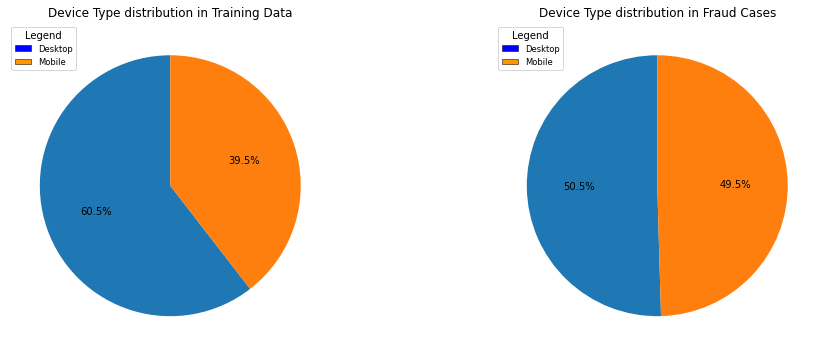

In [76]:
fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (16,6))

ax[0].set_title('Device Type distribution in Training Data')
ax[0].pie(train_df['DeviceType'].value_counts(), autopct = '%1.1f%%', startangle= 90)

one = mpatches.Patch(facecolor='Blue', label='Desktop', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='#ff9700', label = 'Mobile', linewidth = 0.5, edgecolor = 'black')


ax[0].legend(handles = [one,two], title = 'Legend', loc = 2, fontsize = 'small', fancybox = True);

ax[1].set_title('Device Type distribution in Fraud Cases')
ax[1].pie(fraud_train_df['DeviceType'].value_counts(), autopct = '%1.1f%%', startangle= 90)

one = mpatches.Patch(facecolor='Blue', label='Desktop', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='#ff9700', label = 'Mobile', linewidth = 0.5, edgecolor = 'black')


ax[1].legend(handles = [one,two], title = 'Legend', loc = 2, fontsize = 'small', fancybox = True);


From our dataset, There's nearly an equal chance of there being fraud via Desktop or mobile.Let's dig deeper into these features

In [77]:
value_count(train_df, 'DeviceInfo')

DeviceInfo  count
0            Windows  47722
1         iOS Device  19782
2              MacOS  12573
3        Trident/7.0   7440
4            rv:11.0   1901
...              ...    ...
1781           ALTER      1
1782        SM-T285M      1
1783        SM-G530W      1
1784   Android 7.1.2      1
1785  HTC_Desire_820      1

[1786 rows x 2 columns]

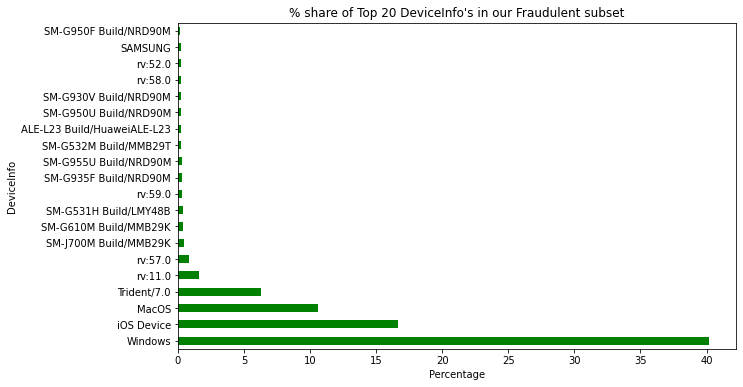

In [78]:
#Let's plot the top 20 device info from our training dataset

plot_top20_spread(train_df, 'DeviceInfo')

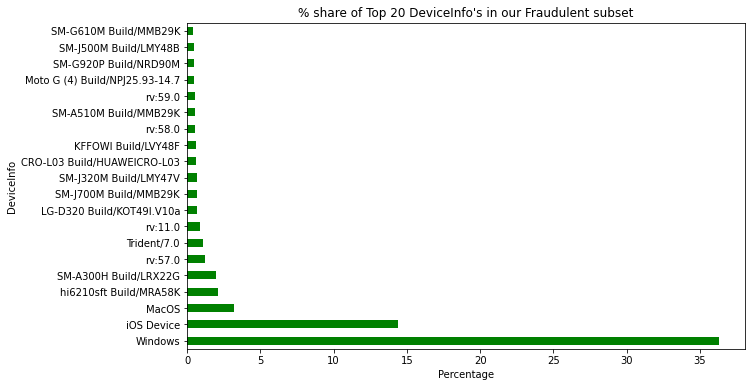

In [79]:
#Let's plot the top 20 device info on which fraud takes place

plot_top20_spread(fraud_train_df, 'DeviceInfo')

In the cases where there is fraud,it is common in `Windows` devices at 37% followed by near 15% in `iOS` and about 4% in `MacOs`devices

In [80]:
def cat_feat_plotting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=18)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=16)
    g.set_xlabel(f"{col} Name", fontsize=14)
    g.set_ylabel("Count", fontsize=14)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
               '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=14)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=16)
    g1.set_xlabel(f"{col} Name", fontsize=14)
    g1.set_ylabel("Count", fontsize=14)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=16)
    g3.set_xlabel("ProductCD Name", fontsize=14)
    g3.set_ylabel("Transaction Values", fontsize=14)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

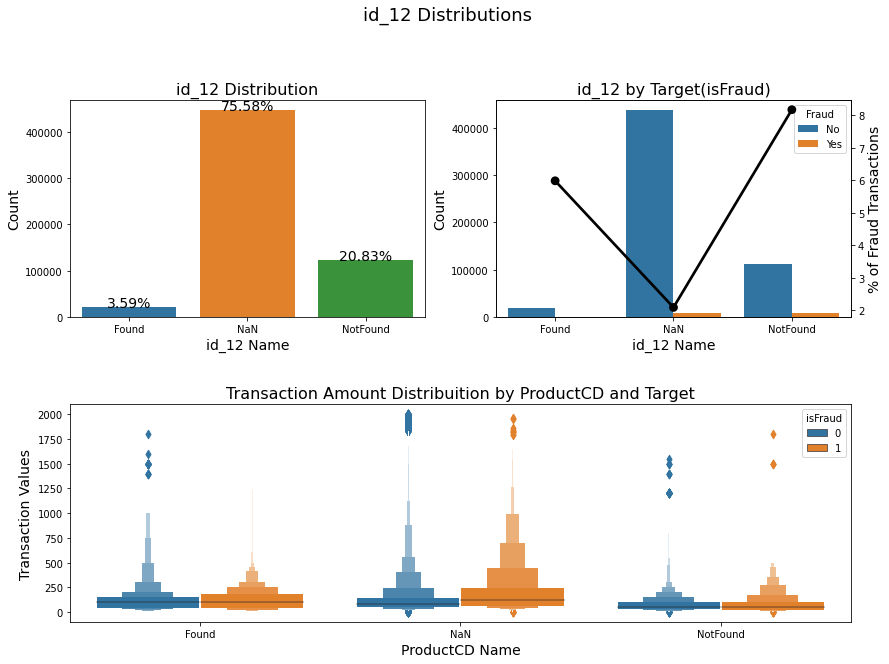

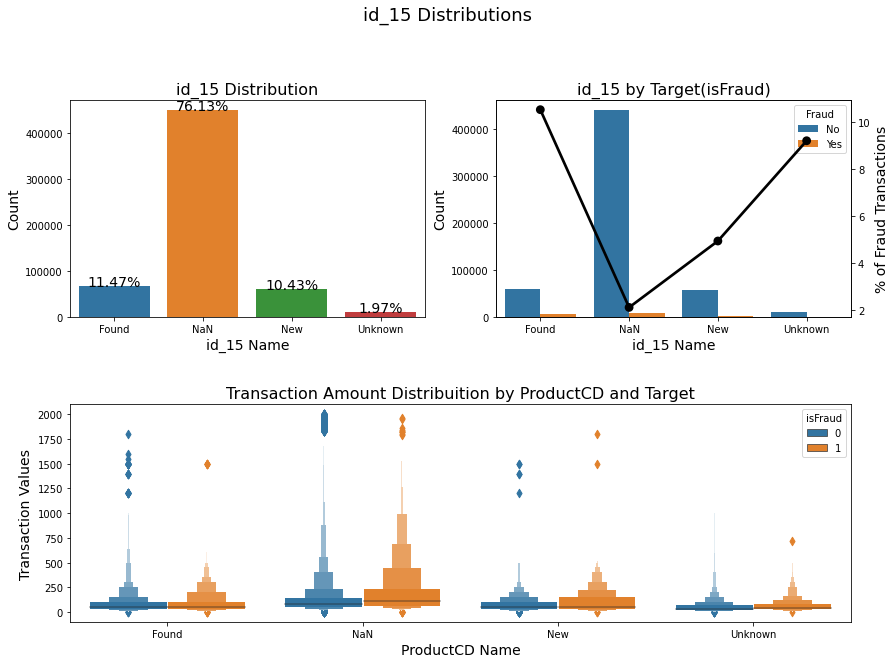

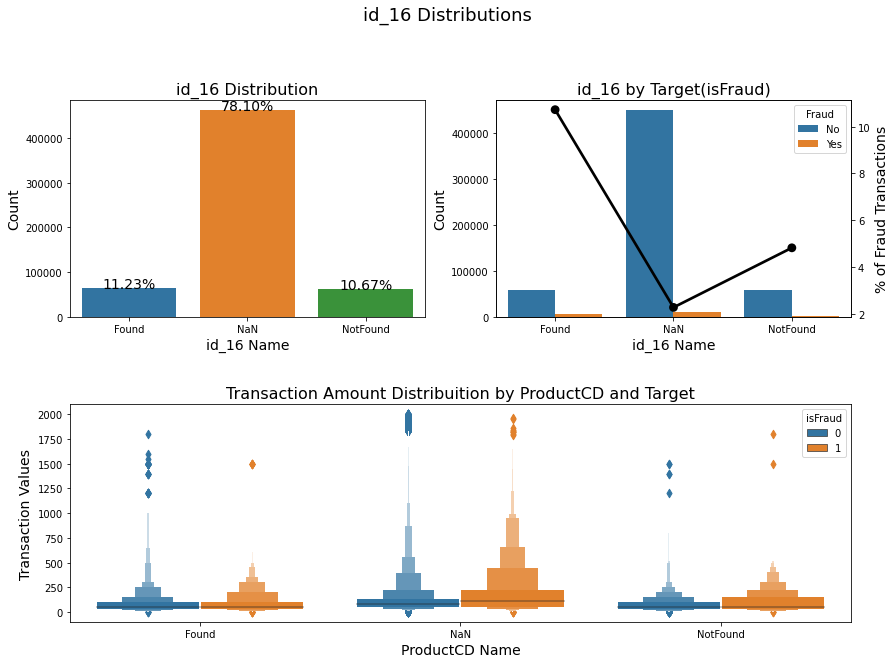

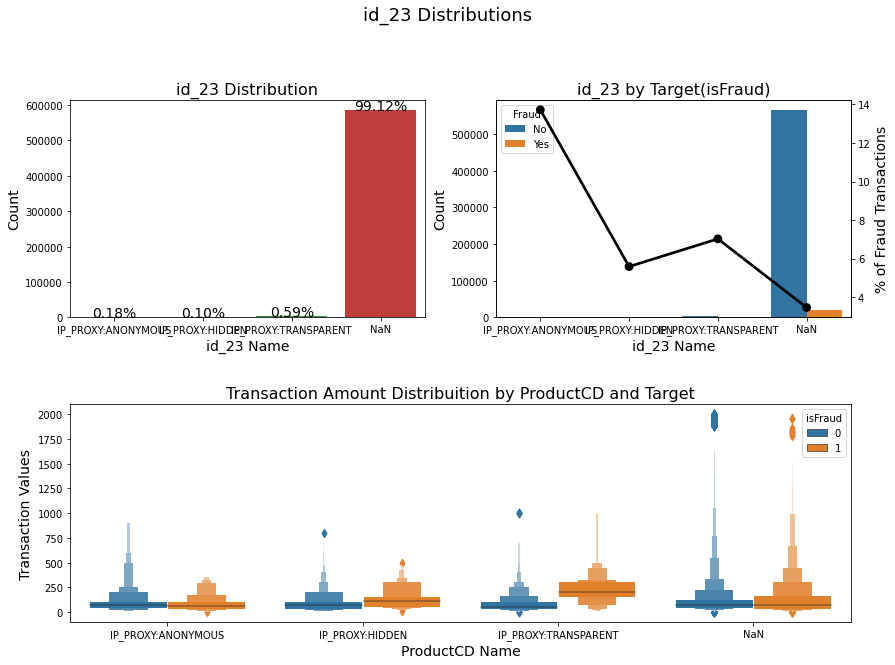

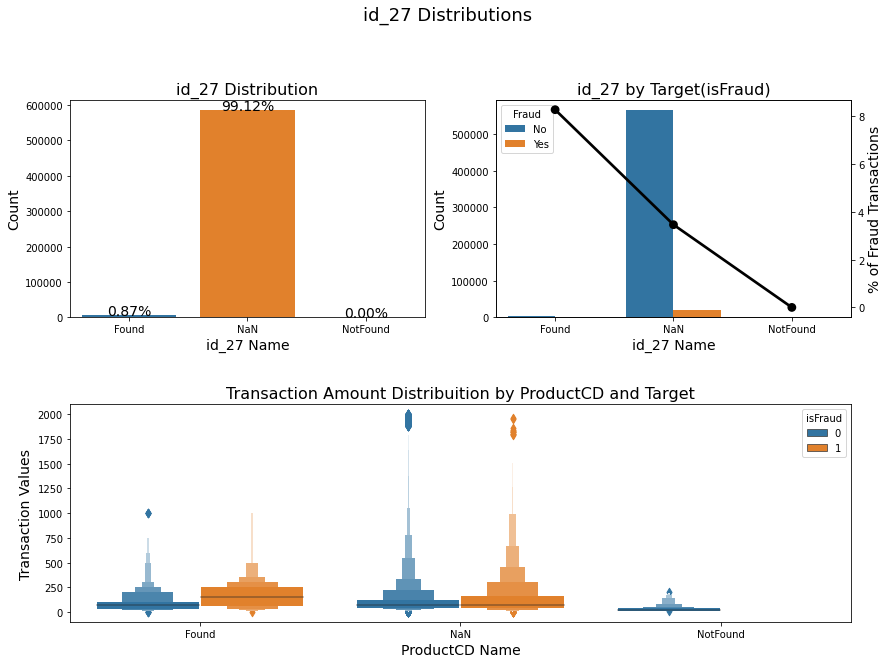

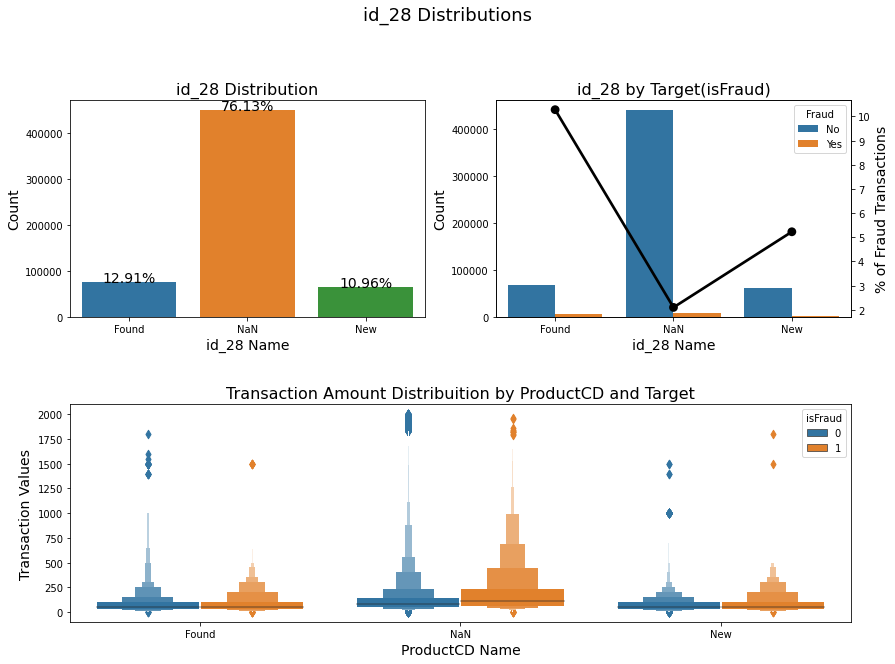

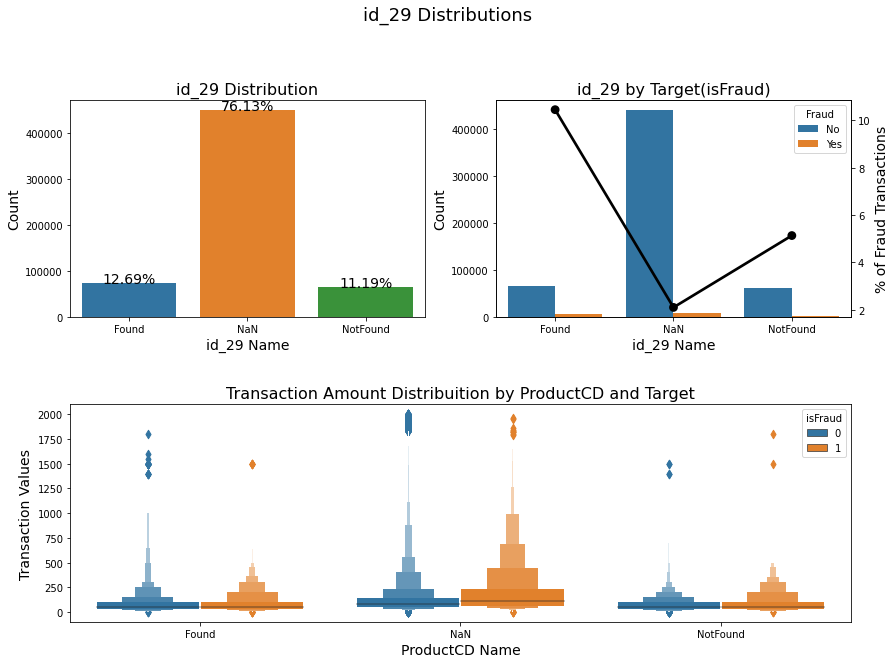

In [81]:
for col in ['id_12','id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29']:
    train_df[col] = train_df[col].fillna('NaN')
    cat_feat_plotting(train_df, col)

## Id 30

In [82]:
train_df['id_30'].value_counts()

Windows 10          21155
Windows 7           13110
iOS 11.2.1           3722
iOS 11.1.2           3699
Android 7.0          2871
                    ...  
func                   10
iOS 11.4.0              5
Mac OS X 10_13_5        4
Windows                 3
iOS 11.4.1              1
Name: id_30, Length: 75, dtype: int64

In [83]:
value_count(train_df, 'id_30')

id_30  count
0         Windows 10  21155
1          Windows 7  13110
2         iOS 11.2.1   3722
3         iOS 11.1.2   3699
4        Android 7.0   2871
..               ...    ...
70              func     10
71        iOS 11.4.0      5
72  Mac OS X 10_13_5      4
73           Windows      3
74        iOS 11.4.1      1

[75 rows x 2 columns]

In [84]:
train_df.loc[train_df['id_30'].str.contains('Windows', na = False), 'id_30'] = 'Windows'
train_df.loc[train_df['id_30'].str.contains('iOS', na = False), 'id_30'] = 'iOS'
train_df.loc[train_df['id_30'].str.contains('Mac OS', na = False), 'id_30'] = 'Mac'
train_df.loc[train_df['id_30'].str.contains('Android', na = False), 'id_30'] = 'Android'
train_df['id_30'].fillna('NAN', inplace = True)

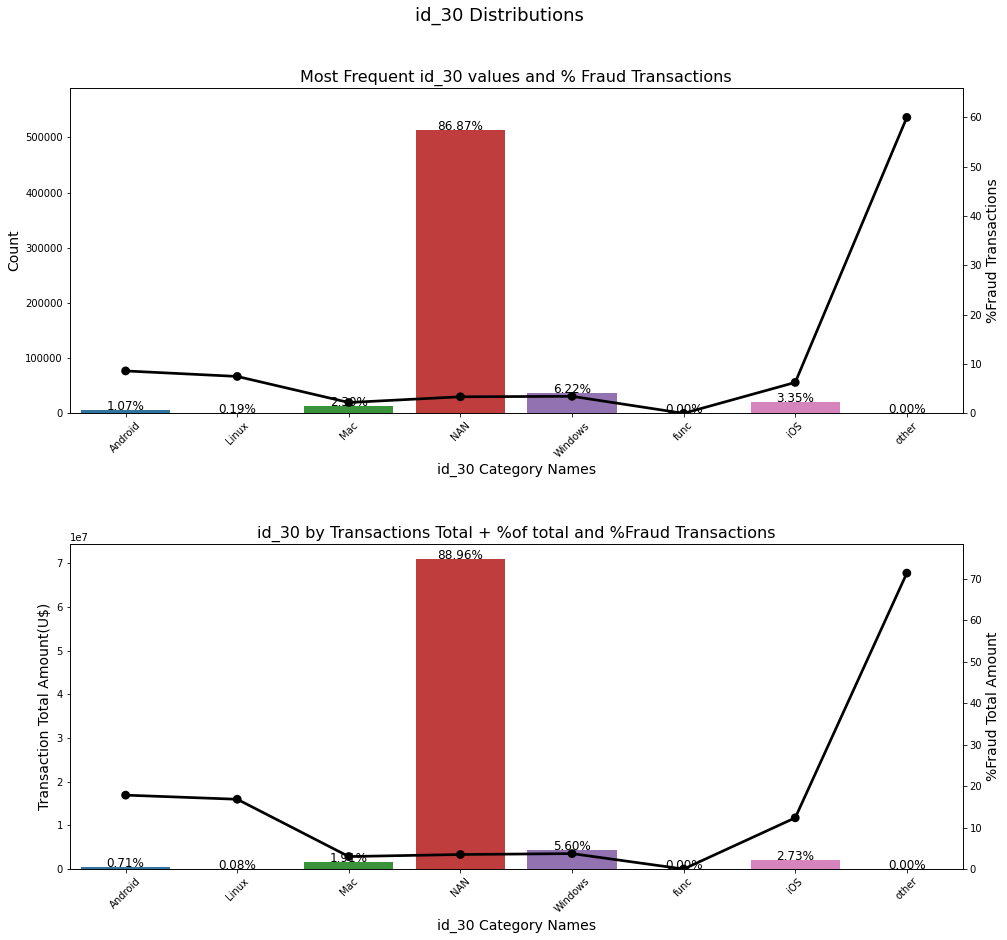

In [85]:
ploting_cnt_amt(train_df, 'id_30')

## Id 31


In [86]:
value_count(train_df, 'id_31')

id_31  count
0              chrome 63.0  22000
1       mobile safari 11.0  13423
2    mobile safari generic  11474
3      ie 11.0 for desktop   9030
4           safari generic   8195
..                     ...    ...
125    firefox mobile 61.0      1
126            Nokia/Lumia      1
127               BLU/Dash      1
128              seamonkey      1
129               cyberfox      1

[130 rows x 2 columns]

In [87]:
train_df.loc[train_df['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
train_df.loc[train_df['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
train_df.loc[train_df['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
train_df.loc[train_df['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
train_df.loc[train_df['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
train_df.loc[train_df['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
train_df.loc[train_df['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
train_df['id_31'].fillna("NAN", inplace=True)
train_df.loc[train_df.id_31.isin(train_df.id_31.value_counts()[train_df.id_31.value_counts() < 200].index), 'id_31'] = "Others"

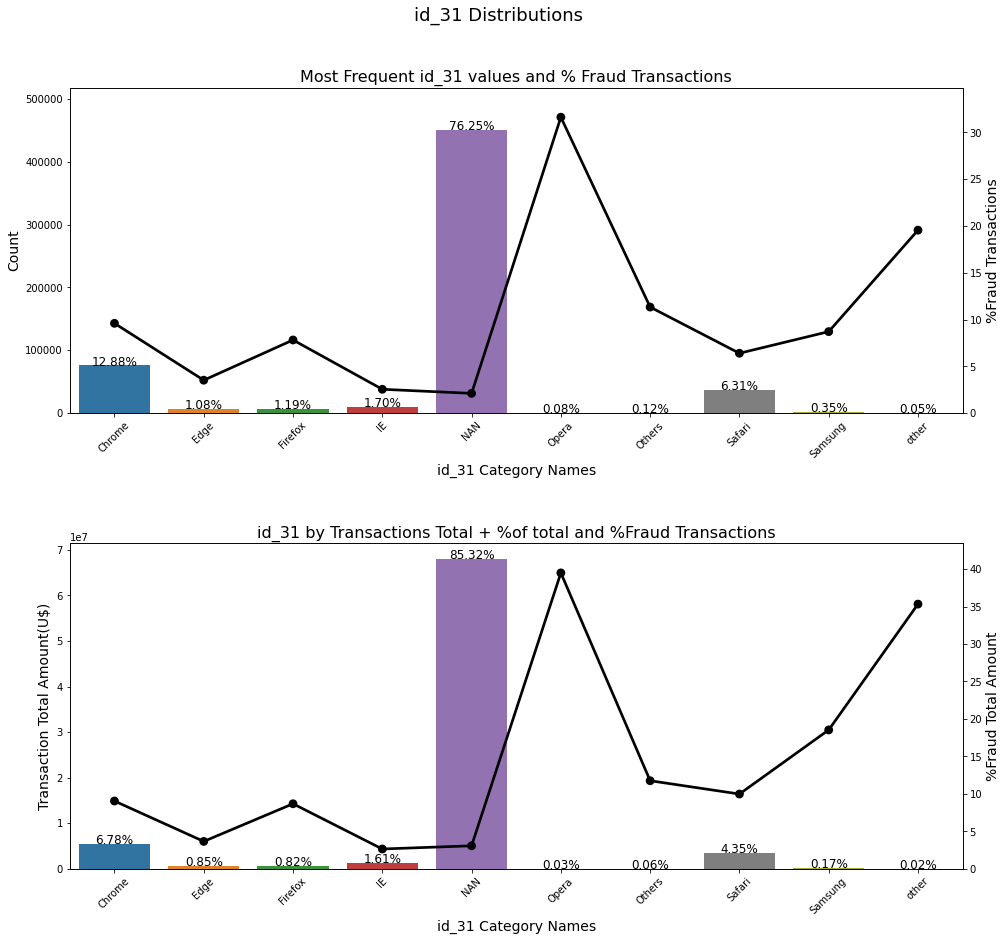

In [88]:
ploting_cnt_amt(train_df, 'id_31')

[Statcounter Global Stats]('https://gs.statcounter.com/browser-market-share') puts Chrome's Market Share worldwide at 64.53%

## Test dataset

Let's merge `test_transaction_df` and `test_identity_df` to make one test dataset

In [89]:
test_transaction_df['Date'] = test_transaction_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

test_transaction_df['Weekdays'] = test_transaction_df['Date'].dt.dayofweek
test_transaction_df['Hours'] = test_transaction_df['Date'].dt.hour
test_transaction_df['Days'] = test_transaction_df['Date'].dt.day


In [90]:
test_df = pd.merge(test_transaction_df, test_identity_df, how = 'left', on = 'TransactionID')
test_df

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224       31.953125         W  10409  111.0   
1             3663550       18403263       49.000000         W   4272  111.0   
2             3663551       18403310      171.000000         W   4476  574.0   
3             3663552       18403310      285.000000         W  10989  360.0   
4             3663553       18403317       67.937500         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279       94.687500         C  13832  375.0   
506687        4170236       34214287       12.171875         C   3154  408.0   
506688        4170237       34214326       49.000000         W  16661  490.0   
506689        4170238       34214337      202.000000         W  16621  516.0   
506690        4170239       34214345       24.343750         C   5713  168.0   

        card3       card4  card5   card6  ...                    id-31  id-32  \
0       150.0        visa  226.0   debit  ...                      NaN    NaN   
1       150.0        visa  226.0   debit  ...                      NaN    NaN   
2       150.0        visa  226.0   debit  ...                      NaN    NaN   
3       150.0        visa  166.0   debit  ...                      NaN    NaN   
4       150.0  mastercard  117.0   debit  ...                      NaN    NaN   
...       ...         ...    ...     ...  ...                      ...    ...   
506686  185.0  mastercard  224.0   debit  ...                      NaN    NaN   
506687  185.0  mastercard  224.0   debit  ...  chrome 43.0 for android    NaN   
506688  150.0        visa  226.0   debit  ...                      NaN    NaN   
506689  150.0  mastercard  224.0   debit  ...                      NaN    NaN   
506690  144.0        visa  147.0  credit  ...      samsung browser 8.2    NaN   

        id-33  id-34 id-35 id-36  id-37  id-38  DeviceType  \
0         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
1         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
2         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
3         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
4         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
...       ...    ...   ...   ...    ...    ...         ...   
506686    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506687    NaN    NaN     F     F      T      F      mobile   
506688    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506689    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506690    NaN    NaN     F     F      T      F      mobile   

                         DeviceInfo  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  
...                             ...  
506686                          NaN  
506687  ALE-L23 Build/HuaweiALE-L23  
506688                          NaN  
506689                          NaN  
506690                      SAMSUNG  

[506691 rows x 437 columns]

In [91]:
train_df.shape, test_df.shape

((590540, 438), (506691, 437))

### Reduce Memory usage

In [92]:
del train_transaction_df, train_identity_df, test_transaction_df, test_identity_df, train_df, test_df, fraud_train_df

## Preprocessing and Feature Engineering

Let's look at the available columns to figure if we can apply useful transformations

In [93]:
test_transaction_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/test_transaction.csv')
test_identity_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/test_identity.csv')
train_identity_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/train_identity.csv')
train_transaction_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/train_transaction.csv')
sample_submission_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/sample_submission.csv')

In [94]:
train_df = pd.merge(train_transaction_df, train_identity_df, how = 'left',on = 'TransactionID' )
test_df = pd.merge(test_transaction_df, test_identity_df, how = 'left', on = 'TransactionID')

In [95]:
train_df.shape, test_df.shape

((590540, 434), (506691, 433))

In [96]:
del train_transaction_df, train_identity_df, test_transaction_df, test_identity_df

In [97]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 650.48 MB (66.8% reduction)
Mem. usage decreased to 565.37 MB (66.3% reduction)


### Align Column names

In [98]:
test_df.rename(columns = {'id-01':'id_01', 'id-02':'id_02','id-03':'id_03', 'id-04':'id_04', 'id-05':'id_05','id-06':'id_06', 
              'id-07':'id_07', 'id-08':'id_08', 'id-09':'id_09','id-10':'id_10', 'id-11':'id_11', 'id-12':'id_12', 'id-13':'id_13', 
             'id-14':'id_14','id-15':'id_15', 'id-16':'id_16', 'id-17':'id_17', 'id-18': 'id_18', 'id-19':'id_19', 'id-20':'id_20', 
            'id-21' :'id_21','id-22': 'id_22', 'id-23' :'id_23','id-24':'id_24', 'id-25': 'id_25', 'id-26': 'id_26', 'id-27': 'id_27', 
            'id-28':'id_28', 'id-29':'id_29', 'id-30' :'id_30', 'id-31':'id_31', 'id-32': 'id_32','id-33':'id_33', 'id-34': 'id_34',
            'id-35':'id_35', 'id-36':'id_36', 'id-37':'id_37', 'id-38':'id_38'},inplace = True)
test_df.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

### Map emails

In [99]:

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train_df[c + '_bin'] = train_df[c].map(emails)
    test_df[c + '_bin'] = test_df[c].map(emails)
    
    train_df[c + '_suffix'] = train_df[c].map(lambda x: str(x).split('.')[-1])
    test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
    
    train_df[c + '_suffix'] =train_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_df[c + '_suffix'] = test_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [100]:
train_df.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06             NaN   
std     1.704744e+05       0.183755   4.617224e+06             NaN   
min     2.987000e+06       0.000000   8.640000e+04        0.250977   
25%     3.134635e+06       0.000000   3.027058e+06       43.312500   
50%     3.282270e+06       0.000000   7.306528e+06       68.750000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31936.000000   

               card1     card2     card3     card5     addr1     addr2  ...  \
count  590540.000000  581607.0  588975.0  586281.0  524834.0  524834.0  ...   
mean     9898.734658       NaN       NaN       NaN       NaN       NaN  ...   
std      4901.170153       NaN       0.0       0.0       NaN       0.0  ...   
min      1000.000000     100.0     100.0     100.0     100.0      10.0  ...   
25%      6019.000000     214.0     150.0     166.0     204.0      87.0  ...   
50%      9678.000000     361.0     150.0     226.0     299.0      87.0  ...   
75%     14184.000000     512.0     150.0     226.0     330.0      87.0  ...   
max     18396.000000     600.0     231.0     237.0     540.0     102.0  ...   

          id_17         id_18     id_19     id_20   id_21        id_22  \
count  139369.0  4.511300e+04  139318.0  139261.0  5159.0  5169.000000   
mean        NaN           inf       NaN       NaN     inf          inf   
std         0.0  1.561523e+00       NaN       NaN     inf     6.898438   
min       100.0  1.000000e+01     100.0     100.0   100.0    10.000000   
25%       166.0  1.300000e+01     266.0     256.0   252.0    14.000000   
50%       166.0  1.500000e+01     341.0     472.0   252.0    14.000000   
75%       225.0  1.500000e+01     427.0     533.0   486.5    14.000000   
max       229.0  2.900000e+01     671.0     661.0   854.0    44.000000   

             id_24      id_25       id_26    id_32  
count  4747.000000  5132.0000  5163.00000  77586.0  
mean     12.820312        inf         inf      NaN  
std       2.373047    97.4375    32.09375      0.0  
min      11.000000   100.0000   100.00000      0.0  
25%      11.000000   321.0000   119.00000     24.0  
50%      11.000000   321.0000   149.00000     24.0  
75%      15.000000   371.0000   169.00000     32.0  
max      26.000000   548.0000   216.00000     32.0  

[8 rows x 403 columns]

In [101]:
train_df.shape, test_df.shape

((590540, 438), (506691, 437))

### Handling Null Values

Let's begin by looking at the missing values

In [102]:
print(f'There are {train_df.isnull().any().sum()} columns in the training dataset with missing values.')
print(f'There are {test_df.isnull().any().sum()} columns in the test dataset with missing values.')

There are 416 columns in the training dataset with missing values.
There are 387 columns in the test dataset with missing values.


In [103]:
def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100*df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    mis_val_table_ren_cols = mis_val_table.rename(columns= {0:'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_cols =  mis_val_table_ren_cols[mis_val_table_ren_cols.iloc[:, 1] != 0].sort_values('% of Total Values', 
                                                                                                    ascending = False).round(1)
    
    print('Your selected dataframe has ' + str(df.shape[1]) + ' columns \n'
          'There are ' + str(mis_val_table_ren_cols.shape[0]) + ' columns that have missing values')
    return mis_val_table_ren_cols

In [104]:
missing_values(train_df)

Your selected dataframe has 438 columns 
There are 416 columns that have missing values


Missing Values  % of Total Values
id_24          585793               99.2
id_25          585408               99.1
id_07          585385               99.1
id_08          585385               99.1
id_21          585381               99.1
...               ...                ...
V284               12                0.0
V280               12                0.0
V279               12                0.0
V292               12                0.0
V291               12                0.0

[416 rows x 2 columns]

Let's fill the missing values

In [ ]:
'''mis_val_percent = train_df.isnull().sum()/len(train_df)

# Let's drop columns with more than 50% missing values
cols = mis_val_percent[mis_val_percent > 0.5].index
print(cols)

print(train_df.shape)

train_df = train_df.drop(cols, axis =1)
train_df'''

In [105]:
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

In [106]:
train_df.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06             NaN   
std     1.704744e+05       0.183755   4.617224e+06             NaN   
min     2.987000e+06       0.000000   8.640000e+04        0.250977   
25%     3.134635e+06       0.000000   3.027058e+06       43.312500   
50%     3.282270e+06       0.000000   7.306528e+06       68.750000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31936.000000   

               card1     card2     card3     card5     addr1     addr2  ...  \
count  590540.000000  590540.0  590540.0  590540.0  590540.0  590540.0  ...   
mean     9898.734658       NaN       NaN       NaN       NaN       NaN  ...   
std      4901.170153       NaN       NaN       NaN       NaN       NaN  ...   
min      1000.000000    -999.0    -999.0    -999.0    -999.0    -999.0  ...   
25%      6019.000000     204.0     150.0     166.0     184.0      87.0  ...   
50%      9678.000000     360.0     150.0     226.0     272.0      87.0  ...   
75%     14184.000000     512.0     150.0     226.0     327.0      87.0  ...   
max     18396.000000     600.0     231.0     237.0     540.0     102.0  ...   

          id_17     id_18     id_19     id_20     id_21     id_22     id_24  \
count  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0   
mean        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
std         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
min      -999.0    -999.0    -999.0    -999.0    -999.0    -999.0    -999.0   
25%      -999.0    -999.0    -999.0    -999.0    -999.0    -999.0    -999.0   
50%      -999.0    -999.0    -999.0    -999.0    -999.0    -999.0    -999.0   
75%      -999.0    -999.0    -999.0    -999.0    -999.0    -999.0    -999.0   
max       229.0      29.0     671.0     661.0     854.0      44.0      26.0   

          id_25     id_26     id_32  
count  590540.0  590540.0  590540.0  
mean        NaN       NaN       NaN  
std         NaN       NaN       NaN  
min      -999.0    -999.0    -999.0  
25%      -999.0    -999.0    -999.0  
50%      -999.0    -999.0    -999.0  
75%      -999.0    -999.0    -999.0  
max       548.0     216.0      32.0  

[8 rows x 403 columns]

## Test Dataset


In [ ]:
'''# Let's drop columns we've dropped in training dataset
test_df.drop(cols, axis =1, inplace = True)
test_df'''

### Sample

We elected to take a sample of the data with equal `fraud` and `no fraud` values - just to check

In [107]:
fraud_train_df = train_df[train_df['isFraud'] == 1]
fraud_train_df

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
203           2987203        1          89760       445.00000         W   
240           2987240        1          90193        37.09375         C   
243           2987243        1          90246        37.09375         C   
245           2987245        1          90295        37.09375         C   
288           2987288        1          90986       155.50000         C   
...               ...      ...            ...             ...       ...   
590361        3577361        1       15807368      1224.00000         W   
590364        3577364        1       15807516        69.93750         C   
590368        3577368        1       15807677       100.00000         H   
590372        3577372        1       15807758       117.00000         W   
590526        3577526        1       15810876       250.00000         R   

        card1  card2  card3             card4  card5  ... id_35  id_36  id_37  \
203     18268  583.0  150.0              visa  226.0  ...  -999   -999   -999   
240     13413  103.0  185.0              visa  137.0  ...     F      F      T   
243     13413  103.0  185.0              visa  137.0  ...     F      F      T   
245     13413  103.0  185.0              visa  137.0  ...     F      F      T   
288     16578  545.0  185.0              visa  226.0  ...     F      F      F   
...       ...    ...    ...               ...    ...  ...   ...    ...    ...   
590361   3278  453.0  150.0              visa  226.0  ...  -999   -999   -999   
590364   5812  408.0  185.0        mastercard  224.0  ...     F      F      T   
590368   6758  399.0  150.0  american express  146.0  ...     T      F      F   
590372  14037  111.0  150.0              visa  226.0  ...  -999   -999   -999   
590526   1214  174.0  150.0              visa  226.0  ...     T      F      T   

        id_38  DeviceType                     DeviceInfo P_emaildomain_bin  \
203      -999        -999                           -999               aol   
240         T      mobile      Redmi Note 4 Build/MMB29M         microsoft   
243         T      mobile      Redmi Note 4 Build/MMB29M         microsoft   
245         T      mobile      Redmi Note 4 Build/MMB29M         microsoft   
288         F      mobile                           -999         microsoft   
...       ...         ...                            ...               ...   
590361   -999        -999                           -999             yahoo   
590364      F      mobile  SAMSUNG SM-J700M Build/MMB29K         microsoft   
590368      T      mobile                     iOS Device         microsoft   
590372   -999        -999                           -999             yahoo   
590526      F      mobile            A574BL Build/NMF26F            google   

        P_emaildomain_suffix  R_emaildomain_bin  R_emaildomain_suffix  
203                      com               -999                   nan  
240                      com          microsoft                   com  
243                      com          microsoft                   com  
245                      com          microsoft                   com  
288                      com          microsoft                   com  
...                      ...                ...                   ...  
590361                   com               -999                   nan  
590364                   com          microsoft                   com  
590368                   com          microsoft                   com  
590372                   com               -999                   nan  
590526                   com             google                   com  

[20663 rows x 438 columns]

In [108]:
no_fraud_train_df = train_df[train_df['isFraud'] == 0]

#Take a sample of length of fraud dataset
no_fraud_train_df = no_fraud_train_df.sample(n = len(fraud_train_df))

#Take a sample of same length as fraud subset
no_fraud_train_df

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
375427        3362427        0        9385732      664.000000         W   
516121        3503121        0       13526557       49.000000         W   
250864        3237864        0        5970732      107.937500         W   
535317        3522317        0       14088335      117.000000         W   
74022         3061022        0        1634046      360.000000         W   
...               ...      ...            ...             ...       ...   
573959        3560959        0       15261159       28.000000         W   
314115        3301115        0        7833091      107.937500         W   
92672         3079672        0        1911589       75.000000         R   
186768        3173768        0        4150984       17.484375         C   
278291        3265291        0        6784848       14.015625         C   

        card1  card2  card3       card4  card5  ... id_35  id_36  id_37  \
375427  12138  555.0  150.0        visa  226.0  ...  -999   -999   -999   
516121   2646  449.0  150.0        visa  166.0  ...  -999   -999   -999   
250864  16132  111.0  150.0        visa  226.0  ...  -999   -999   -999   
535317  12839  321.0  150.0        visa  226.0  ...  -999   -999   -999   
74022    3507 -999.0  150.0        visa  226.0  ...  -999   -999   -999   
...       ...    ...    ...         ...    ...  ...   ...    ...    ...   
573959  17188  321.0  150.0        visa  226.0  ...  -999   -999   -999   
314115   6207 -999.0 -999.0        -999 -999.0  ...  -999   -999   -999   
92672    2616  327.0  150.0    discover  102.0  ...     T      F      F   
186768  14276  177.0  185.0  mastercard  137.0  ...  -999   -999   -999   
278291  15885  545.0  185.0        visa  138.0  ...     F      F      T   

        id_38  DeviceType                 DeviceInfo P_emaildomain_bin  \
375427   -999        -999                       -999            google   
516121   -999        -999                       -999            google   
250864   -999        -999                       -999            google   
535317   -999        -999                       -999            google   
74022    -999        -999                       -999               att   
...       ...         ...                        ...               ...   
573959   -999        -999                       -999             other   
314115   -999        -999                       -999            google   
92672       F      mobile                 iOS Device             yahoo   
186768   -999        -999                       -999         microsoft   
278291      F      mobile  Hisense L675 Build/MRA58K            google   

        P_emaildomain_suffix  R_emaildomain_bin  R_emaildomain_suffix  
375427                   com               -999                   nan  
516121                   com               -999                   nan  
250864                   com               -999                   nan  
535317                   com               -999                   nan  
74022                     us               -999                   nan  
...                      ...                ...                   ...  
573959                   com               -999                   nan  
314115                   com               -999                   nan  
92672                    com              yahoo                   com  
186768                   com          microsoft                   com  
278291                   com             google                   com  

[20663 rows x 438 columns]

### Concatenate and Shuffle

In [109]:
train_sub_df = pd.concat([fraud_train_df, no_fraud_train_df], axis=0, sort = False)
train_sub_df

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
203           2987203        1          89760      445.000000         W   
240           2987240        1          90193       37.093750         C   
243           2987243        1          90246       37.093750         C   
245           2987245        1          90295       37.093750         C   
288           2987288        1          90986      155.500000         C   
...               ...      ...            ...             ...       ...   
573959        3560959        0       15261159       28.000000         W   
314115        3301115        0        7833091      107.937500         W   
92672         3079672        0        1911589       75.000000         R   
186768        3173768        0        4150984       17.484375         C   
278291        3265291        0        6784848       14.015625         C   

        card1  card2  card3       card4  card5  ... id_35  id_36  id_37  \
203     18268  583.0  150.0        visa  226.0  ...  -999   -999   -999   
240     13413  103.0  185.0        visa  137.0  ...     F      F      T   
243     13413  103.0  185.0        visa  137.0  ...     F      F      T   
245     13413  103.0  185.0        visa  137.0  ...     F      F      T   
288     16578  545.0  185.0        visa  226.0  ...     F      F      F   
...       ...    ...    ...         ...    ...  ...   ...    ...    ...   
573959  17188  321.0  150.0        visa  226.0  ...  -999   -999   -999   
314115   6207 -999.0 -999.0        -999 -999.0  ...  -999   -999   -999   
92672    2616  327.0  150.0    discover  102.0  ...     T      F      F   
186768  14276  177.0  185.0  mastercard  137.0  ...  -999   -999   -999   
278291  15885  545.0  185.0        visa  138.0  ...     F      F      T   

        id_38  DeviceType                 DeviceInfo P_emaildomain_bin  \
203      -999        -999                       -999               aol   
240         T      mobile  Redmi Note 4 Build/MMB29M         microsoft   
243         T      mobile  Redmi Note 4 Build/MMB29M         microsoft   
245         T      mobile  Redmi Note 4 Build/MMB29M         microsoft   
288         F      mobile                       -999         microsoft   
...       ...         ...                        ...               ...   
573959   -999        -999                       -999             other   
314115   -999        -999                       -999            google   
92672       F      mobile                 iOS Device             yahoo   
186768   -999        -999                       -999         microsoft   
278291      F      mobile  Hisense L675 Build/MRA58K            google   

        P_emaildomain_suffix  R_emaildomain_bin  R_emaildomain_suffix  
203                      com               -999                   nan  
240                      com          microsoft                   com  
243                      com          microsoft                   com  
245                      com          microsoft                   com  
288                      com          microsoft                   com  
...                      ...                ...                   ...  
573959                   com               -999                   nan  
314115                   com               -999                   nan  
92672                    com              yahoo                   com  
186768                   com          microsoft                   com  
278291                   com             google                   com  

[41326 rows x 438 columns]

In [110]:
#Shuffle the dataset - useful for future train validation split
train_sub_df = train_sub_df.reindex(np.random.permutation(train_sub_df.index))
train_sub_df

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
298709        3285709        0        7392838       58.437500         W   
234078        3221078        0        5532496       59.000000         W   
504640        3491640        0       13211143       57.937500         W   
247991        3234991        0        5890929       25.953125         W   
435407        3422407        0       11025715       39.000000         W   
...               ...      ...            ...             ...       ...   
76295         3063295        0        1661323      100.000000         H   
334244        3321244        1        8218318       71.062500         C   
557149        3544149        0       14746563       57.937500         W   
505070        3492070        0       13218339      161.000000         W   
387439        3374439        0        9727419      226.000000         W   

        card1  card2  card3       card4  card5  ... id_35  id_36  id_37  \
298709  10989  360.0  150.0        visa  166.0  ...  -999   -999   -999   
234078  12469  360.0  150.0  mastercard  166.0  ...  -999   -999   -999   
504640  12422  390.0  150.0  mastercard  224.0  ...  -999   -999   -999   
247991  12544  321.0  150.0        visa  226.0  ...  -999   -999   -999   
435407   7861  494.0  150.0        visa  226.0  ...  -999   -999   -999   
...       ...    ...    ...         ...    ...  ...   ...    ...    ...   
76295   10486  514.0  150.0  mastercard  219.0  ...     T      F      T   
334244  13832  375.0  185.0  mastercard  224.0  ...     F      F      F   
557149  12501  490.0  150.0        visa  226.0  ...  -999   -999   -999   
505070   5901  583.0  150.0        visa  226.0  ...  -999   -999   -999   
387439   8140  453.0  150.0        visa  226.0  ...  -999   -999   -999   

        id_38  DeviceType DeviceInfo P_emaildomain_bin  P_emaildomain_suffix  \
298709   -999        -999       -999            google                   com   
234078   -999        -999       -999            google                   com   
504640   -999        -999       -999             yahoo                   com   
247991   -999        -999       -999            google                   com   
435407   -999        -999       -999             yahoo                   com   
...       ...         ...        ...               ...                   ...   
76295       T     desktop      MacOS            google                   com   
334244      F      mobile       -999            google                   com   
557149   -999        -999       -999              -999                   nan   
505070   -999        -999       -999              -999                   nan   
387439   -999        -999       -999         microsoft                   com   

        R_emaildomain_bin  R_emaildomain_suffix  
298709               -999                   nan  
234078               -999                   nan  
504640               -999                   nan  
247991               -999                   nan  
435407               -999                   nan  
...                   ...                   ...  
76295              google                   com  
334244             google                   com  
557149               -999                   nan  
505070               -999                   nan  
387439               -999                   nan  

[41326 rows x 438 columns]

## Columns
Let's look at the columns

In [111]:
train_df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
       'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix'],
      dtype='object', length=438)

In [112]:
test_df.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
       'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix'],
      dtype='object', length=437)

### Check Correlations

In [113]:
train_df.corr()

TransactionID   isFraud  TransactionDT  TransactionAmt  \
TransactionID        1.000000  0.014166       0.998280        0.012025   
isFraud              0.014166  1.000000       0.013103        0.011320   
TransactionDT        0.998280  0.013103       1.000000        0.011920   
TransactionAmt       0.012025  0.011320       0.011920        1.000000   
card1                0.010122 -0.013640       0.010625       -0.005725   
...                       ...       ...            ...             ...   
id_22               -0.027414  0.024365      -0.026278       -0.013651   
id_24               -0.026918  0.024344      -0.025806       -0.012960   
id_25               -0.027368  0.023857      -0.026256       -0.013377   
id_26               -0.027418  0.024569      -0.026266       -0.013556   
id_32               -0.187803  0.020195      -0.180812       -0.035092   

                   card1     card2     card3     card5     addr1     addr2  \
TransactionID   0.010122 -0.009765 -0.037263 -0.020018 -0.006799 -0.006501   
isFraud        -0.013640 -0.003769  0.031685 -0.018704 -0.154174 -0.159654   
TransactionDT   0.010625 -0.009192 -0.038231 -0.020290 -0.003776 -0.003502   
TransactionAmt -0.005725 -0.000123 -0.024830 -0.011586  0.130680  0.136224   
card1           1.000000  0.027739  0.000903 -0.028840  0.001617 -0.002861   
...                  ...       ...       ...       ...       ...       ...   
id_22          -0.011195  0.016677  0.003977  0.001494 -0.003629 -0.004216   
id_24          -0.011155  0.016496  0.002105  0.002475  0.006170  0.005871   
id_25          -0.011378  0.016378  0.003961  0.001203 -0.004049 -0.004656   
id_26          -0.010975  0.016669  0.003999  0.001448 -0.003413 -0.004038   
id_32          -0.006883  0.077078 -0.001268  0.000685  0.134055  0.132316   

                ...     id_17     id_18     id_19     id_20     id_21  \
TransactionID   ... -0.148648 -0.072554 -0.151911 -0.145897 -0.027580   
isFraud         ...  0.136969  0.074849  0.129301  0.138081  0.025341   
TransactionDT   ... -0.144285 -0.070056 -0.147235 -0.141600 -0.026391   
TransactionAmt  ... -0.122160 -0.050528 -0.117533 -0.121843 -0.013624   
card1           ... -0.002773 -0.009626 -0.001670 -0.002053 -0.010332   
...             ...       ...       ...       ...       ...       ...   
id_22           ...  0.116186  0.195019  0.111997  0.115698  0.988585   
id_24           ...  0.113450  0.197548  0.109067  0.113020  0.944198   
id_25           ...  0.115296  0.193904  0.111415  0.114766  0.979448   
id_26           ...  0.115907  0.194517  0.111748  0.115425  0.987404   
id_32           ...  0.669368  0.428064  0.700846  0.661617  0.209478   

                   id_22     id_24     id_25     id_26     id_32  
TransactionID  -0.027414 -0.026918 -0.027368 -0.027418 -0.187803  
isFraud         0.024365  0.024344  0.023857  0.024569  0.020195  
TransactionDT  -0.026278 -0.025806 -0.026256 -0.026266 -0.180812  
TransactionAmt -0.013651 -0.012960 -0.013377 -0.013556 -0.035092  
card1          -0.011195 -0.011155 -0.011378 -0.010975 -0.006883  
...                  ...       ...       ...       ...       ...  
id_22           1.000000  0.956947  0.993758  0.999049  0.212616  
id_24           0.956947  1.000000  0.950947  0.955652  0.214153  
id_25           0.993758  0.950947  1.000000  0.993667  0.211011  
id_26           0.999049  0.955652  0.993667  1.000000  0.212272  
id_32           0.212616  0.214153  0.211011  0.212272  1.000000  

[403 rows x 403 columns]

In [114]:
train_df.corr()['isFraud'].sort_values()

addr2     -0.159654
addr1     -0.154174
D11       -0.091630
V11       -0.088348
V10       -0.088347
             ...   
id_10      0.144142
D14        0.149178
D12        0.154050
D7         0.157434
isFraud    1.000000
Name: isFraud, Length: 403, dtype: float64

In [115]:
train_df.columns[train_df.columns.str.contains('V')]

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=339)

In [116]:
train_df.columns.str.contains('V')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [117]:
train_df.columns[55], train_df.columns[393]

('V1', 'V339')

`V`s incol 55:393

## Concatenating dfs to get PCA of V features

In [118]:
test_df['isFraud'] = 'test'
df = pd.concat([train_df, test_df], axis=0, sort=False )
df = df.reset_index()
df = df.drop('index', axis=1)
df

TransactionID isFraud  TransactionDT  TransactionAmt ProductCD  \
0              2987000       0          86400       68.500000         W   
1              2987001       0          86401       29.000000         W   
2              2987002       0          86469       59.000000         W   
3              2987003       0          86499       50.000000         W   
4              2987004       0          86506       50.000000         H   
...                ...     ...            ...             ...       ...   
1097226        4170235    test       34214279       94.687500         C   
1097227        4170236    test       34214287       12.171875         C   
1097228        4170237    test       34214326       49.000000         W   
1097229        4170238    test       34214337      202.000000         W   
1097230        4170239    test       34214345       24.343750         C   

         card1  card2  card3       card4  card5  ... id_35  id_36  id_37  \
0        13926 -999.0  150.0    discover  142.0  ...  -999   -999   -999   
1         2755  404.0  150.0  mastercard  102.0  ...  -999   -999   -999   
2         4663  490.0  150.0        visa  166.0  ...  -999   -999   -999   
3        18132  567.0  150.0  mastercard  117.0  ...  -999   -999   -999   
4         4497  514.0  150.0  mastercard  102.0  ...     T      F      T   
...        ...    ...    ...         ...    ...  ...   ...    ...    ...   
1097226  13832  375.0  185.0  mastercard  224.0  ...  -999   -999   -999   
1097227   3154  408.0  185.0  mastercard  224.0  ...     F      F      T   
1097228  16661  490.0  150.0        visa  226.0  ...  -999   -999   -999   
1097229  16621  516.0  150.0  mastercard  224.0  ...  -999   -999   -999   
1097230   5713  168.0  144.0        visa  147.0  ...     F      F      T   

         id_38  DeviceType                     DeviceInfo P_emaildomain_bin  \
0         -999        -999                           -999              -999   
1         -999        -999                           -999            google   
2         -999        -999                           -999         microsoft   
3         -999        -999                           -999             yahoo   
4            T      mobile  SAMSUNG SM-G892A Build/NRD90M            google   
...        ...         ...                            ...               ...   
1097226   -999        -999                           -999            google   
1097227      F      mobile    ALE-L23 Build/HuaweiALE-L23         microsoft   
1097228   -999        -999                           -999         microsoft   
1097229   -999        -999                           -999         microsoft   
1097230      F      mobile                        SAMSUNG         microsoft   

         P_emaildomain_suffix  R_emaildomain_bin  R_emaildomain_suffix  
0                         nan               -999                   nan  
1                         com               -999                   nan  
2                         com               -999                   nan  
3                         com               -999                   nan  
4                         com               -999                   nan  
...                       ...                ...                   ...  
1097226                   com             google                   com  
1097227                   com          microsoft                   com  
1097228                   com               -999                   nan  
1097229                   com               -999                   nan  
1097230                   com          microsoft                   com  

[1097231 rows x 438 columns]

In [119]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

In [120]:
mas_v = train_df.columns[55:393]

## Getting PCA

In [121]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

for col in mas_v:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))

    
df = PCA_change(df, mas_v, prefix='PCA_V_', n_components=10)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:383: RuntimeWarning:

overflow encountered in subtract

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:383: RuntimeWarning:

overflow encountered in subtract

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:383: RuntimeWarning:

overflow encountered in subtract

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:383: RuntimeWarning:

overflow encountered in subtract

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:383: RuntimeWarning:

overflow encountered in subtract

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:383: RuntimeWarning:

overflow encountered in subtract

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:383: RuntimeWarning:

overflow encountered in subtract

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:383: RuntimeWarning:

overflow encountered in subtract

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_da

In [122]:
df = reduce_mem_usage(df)

Mem. usage decreased to 464.60 MB (4.3% reduction)


In [123]:
df

TransactionID isFraud  TransactionDT  TransactionAmt ProductCD  \
0              2987000       0          86400       68.500000         W   
1              2987001       0          86401       29.000000         W   
2              2987002       0          86469       59.000000         W   
3              2987003       0          86499       50.000000         W   
4              2987004       0          86506       50.000000         H   
...                ...     ...            ...             ...       ...   
1097226        4170235    test       34214279       94.687500         C   
1097227        4170236    test       34214287       12.171875         C   
1097228        4170237    test       34214326       49.000000         W   
1097229        4170238    test       34214337      202.000000         W   
1097230        4170239    test       34214345       24.343750         C   

         card1  card2  card3       card4  card5  ...    PCA_V_0   PCA_V_1  \
0        13926 -999.0  150.0    discover  142.0  ...  -1.928711  1.919922   
1         2755  404.0  150.0  mastercard  102.0  ...  -1.640625 -0.591309   
2         4663  490.0  150.0        visa  166.0  ...  -2.595703 -0.052216   
3        18132  567.0  150.0  mastercard  117.0  ...  -1.640625 -0.592285   
4         4497  514.0  150.0  mastercard  102.0  ...  10.046875  4.281250   
...        ...    ...    ...         ...    ...  ...        ...       ...   
1097226  13832  375.0  185.0  mastercard  224.0  ...  -1.641602 -0.593262   
1097227   3154  408.0  185.0  mastercard  224.0  ...   4.683594 -4.027344   
1097228  16661  490.0  150.0        visa  226.0  ...  -2.595703 -0.052216   
1097229  16621  516.0  150.0  mastercard  224.0  ...  -2.595703 -0.052216   
1097230   5713  168.0  144.0        visa  147.0  ...   4.683594 -4.027344   

          PCA_V_2   PCA_V_3   PCA_V_4   PCA_V_5   PCA_V_6   PCA_V_7   PCA_V_8  \
0       -1.739258 -1.654297  0.063721  0.699219  0.322266 -0.032349  0.646973   
1       -0.686523  2.351562 -0.414307 -0.288818  0.268555  0.078674  0.027679   
2        0.817871 -0.283936  0.115356 -0.007145 -0.038208  0.075134 -0.008827   
3       -0.593750  2.384766 -0.376465 -0.293213  0.226562  0.029831  0.035675   
4        1.271484  0.410400  0.611816 -0.064026  0.111389  0.016388  0.073975   
...           ...       ...       ...       ...       ...       ...       ...   
1097226 -0.594238  2.384766 -0.383545 -0.248657  0.230347  0.019150  0.058838   
1097227 -1.144531 -0.485107  1.405273 -0.318359 -0.026611  0.040436 -0.119690   
1097228  0.819336 -0.299316  0.119629  0.008545 -0.063843  0.003864  0.001098   
1097229  0.819336 -0.299316  0.119629  0.008545 -0.063843  0.003864  0.001098   
1097230 -1.144531 -0.485107  1.405273 -0.318359 -0.026825  0.040649 -0.119568   

          PCA_V_9  
0       -0.014664  
1       -0.013710  
2       -0.011459  
3       -0.015198  
4       -0.008293  
...           ...  
1097226 -0.015869  
1097227 -0.024643  
1097228 -0.013046  
1097229 -0.013046  
1097230 -0.021301  

[1097231 rows x 110 columns]

## Setting train and test back

In [124]:
df_train, df_test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud', axis=1)

In [125]:
df_train.shape, df_test.shape

((590540, 110), (506691, 109))

In [ ]:
df_train

In [ ]:
df_test

## Training and Validation Set

Let's split the `df_train` into `training_df` and `val_df`i.e. validation set to evaluate the performance of our model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model.

In [126]:
training_df, val_df = train_test_split(df_train, test_size = 0.25, random_state = 42, stratify = df_train['isFraud'])

In [127]:
print(f"The Train Dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns.")
print(f"The Training Dataset has {training_df.shape[0]} rows and {training_df.shape[1]} columns.")
print(f"The Validation Dataset has {val_df.shape[0]} rows and {val_df.shape[1]} columns.")
print(f"The Test Dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns.")

The Train Dataset has 590540 rows and 110 columns.
The Training Dataset has 442905 rows and 110 columns.
The Validation Dataset has 147635 rows and 110 columns.
The Test Dataset has 506691 rows and 109 columns.


## Input and Target Columns
Let's select the columns we will use for training

In [128]:
df_train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'PCA_V_0', 'PCA_V_1', 'PCA_V_2', 'PCA_V_3', 'PCA_V_4', 'PCA_V_5',
       'PCA_V_6', 'PCA_V_7', 'PCA_V_8', 'PCA_V_9'],
      dtype='object', length=110)

In [129]:
df_test.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'PCA_V_0', 'PCA_V_1', 'PCA_V_2', 'PCA_V_3', 'PCA_V_4', 'PCA_V_5',
       'PCA_V_6', 'PCA_V_7', 'PCA_V_8', 'PCA_V_9'],
      dtype='object', length=109)

In [130]:
input_cols = df_test.columns
target_cols = 'isFraud'

In [131]:
inputs = df_train[input_cols].copy()
targets = df_train[target_cols].copy()

train_inputs = training_df[input_cols].copy()
train_targets = training_df[target_cols].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_cols].copy()

test_inputs = df_test[input_cols].copy()

print('inputs:', inputs.shape)
print('train_inputs.shape:', train_inputs.shape)
print('val_inputs.shape:', val_inputs.shape)
print('test_inputs.shape:', test_inputs.shape)

inputs: (590540, 109)
train_inputs.shape: (442905, 109)
val_inputs.shape: (147635, 109)
test_inputs.shape: (506691, 109)


In [132]:
numeric_cols = inputs.select_dtypes(include = np.number).columns.tolist()
numeric_cols

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V339',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_13',
 'id_14',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_24',
 'id_25',
 'id_26',
 'id_32',
 'PCA_V_0',
 'PCA_V_1',
 'PCA_V_2',
 'PCA_V_3',
 'PCA_V_4',
 'PCA_V_5',
 'PCA_V_6',
 'PCA_V_7',
 'PCA_V_8',
 'PCA_V_9']

In [133]:
categorical_cols = inputs.select_dtypes(['object']).columns.tolist()
categorical_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'P_emaildomain_bin',
 'P_emaildomain_suffix',
 'R_emaildomain_bin',
 'R_emaildomain_suffix']

In [134]:
len(input_cols) == len(numeric_cols) + len(categorical_cols)

True

### Impute Numeric values

In [135]:
inputs.describe()

TransactionID  TransactionDT  TransactionAmt          card1     card2  \
count   5.905400e+05   5.905400e+05   590540.000000  590540.000000  590540.0   
mean    3.282270e+06   7.372311e+06             NaN    9898.734658       NaN   
std     1.704744e+05   4.617224e+06             NaN    4901.170153       NaN   
min     2.987000e+06   8.640000e+04        0.250977    1000.000000    -999.0   
25%     3.134635e+06   3.027058e+06       43.312500    6019.000000     204.0   
50%     3.282270e+06   7.306528e+06       68.750000    9678.000000     360.0   
75%     3.429904e+06   1.124662e+07      125.000000   14184.000000     512.0   
max     3.577539e+06   1.581113e+07    31936.000000   18396.000000     600.0   

          card3     card5     addr1     addr2     dist1  ...        PCA_V_0  \
count  590540.0  590540.0  590540.0  590540.0  590540.0  ...  590540.000000   
mean        NaN       NaN       NaN       NaN       NaN  ...            NaN   
std         NaN       NaN       NaN       NaN       NaN  ...       0.000000   
min      -999.0    -999.0    -999.0    -999.0    -999.0  ...      -2.599609   
25%       150.0     166.0     184.0      87.0    -999.0  ...      -2.595703   
50%       150.0     226.0     272.0      87.0    -999.0  ...      -1.928711   
75%       150.0     226.0     327.0      87.0       5.0  ...      -0.085693   
max       231.0     237.0     540.0     102.0   10288.0  ...      10.132812   

             PCA_V_1        PCA_V_2        PCA_V_3        PCA_V_4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean             NaN      -0.084778            NaN            NaN   
std         0.000000       0.000000       0.000000       0.000000   
min        -4.101562      -4.007812      -2.083984      -4.617188   
25%        -0.591309      -1.080078      -0.299805      -0.211426   
50%        -0.052216       0.819336      -0.299316       0.119629   
75%         2.000000       0.819824       0.936035       0.120056   
max         7.703125       4.570312       4.800781       5.089844   

             PCA_V_5        PCA_V_6        PCA_V_7        PCA_V_8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       -0.021637       0.009285       0.009880       0.001242   
std         0.000000       0.000000       0.000000       0.187988   
min        -3.427734      -3.980469      -3.445312      -2.619141   
25%        -0.248657      -0.063904      -0.009064       0.000963   
50%         0.008545      -0.026825       0.003864       0.001111   
75%         0.008598       0.230591       0.019089       0.058838   
max         4.343750       4.316406       3.462891       2.851562   

             PCA_V_9  
count  590540.000000  
mean       -0.008682  
std         0.127075  
min        -0.189209  
25%        -0.015854  
50%        -0.013046  
75%        -0.010612  
max         2.949219  

[8 rows x 74 columns]

In [136]:
#replace infinity values
inputs.replace([np.inf, -np.inf], np.nan, inplace = True)
train_inputs.replace([np.inf, -np.inf], np.nan, inplace = True)
val_inputs.replace([np.inf, -np.inf], np.nan, inplace = True)

In [137]:
#Check
train_inputs[numeric_cols].isnull().sum().sum()

0

In [ ]:
'''imputer = SimpleImputer(missing_values = np.NaN, strategy = 'mean')
imputer.fit(inputs[numeric_cols])

inputs[numeric_cols] = imputer.transform(inputs[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])

inputs[numeric_cols].isnull().sum().sum()'''

In [138]:
test_inputs.replace([np.inf, -np.inf], np.nan,inplace = True)

In [139]:
#Check missing numerical data
test_inputs[numeric_cols].isnull().sum().sum()

0

In [ ]:
'''imputer = SimpleImputer(missing_values = np.NaN, strategy = 'mean')
imputer.fit(test_inputs[numeric_cols])

test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

#Check
test_inputs[numeric_cols].isnull().sum().sum()'''

### Scale numeric columns

In [ ]:
'''scaler = MinMaxScaler().fit(inputs[numeric_cols])

inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

#Check
train_inputs[numeric_cols]'''

In [ ]:
# Test
'''scaler = MinMaxScaler().fit(test_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

#Check
test_inputs[numeric_cols]'''

### Impute Categorical Features

In [140]:
inputs[categorical_cols]

ProductCD       card4   card6 P_emaildomain R_emaildomain    M1    M2  \
0              W    discover  credit          -999          -999     T     T   
1              W  mastercard  credit     gmail.com          -999  -999  -999   
2              W        visa   debit   outlook.com          -999     T     T   
3              W  mastercard   debit     yahoo.com          -999  -999  -999   
4              H  mastercard  credit     gmail.com          -999  -999  -999   
...          ...         ...     ...           ...           ...   ...   ...   
590535         W        visa   debit          -999          -999     T     T   
590536         W  mastercard   debit     gmail.com          -999     T     F   
590537         W  mastercard   debit     gmail.com          -999     T     F   
590538         W  mastercard   debit       aol.com          -999     T     T   
590539         W  mastercard  credit     gmail.com          -999     T     F   

          M3    M4    M5  ... id_35 id_36 id_37 id_38 DeviceType  \
0          T    M2     F  ...  -999  -999  -999  -999       -999   
1       -999    M0     T  ...  -999  -999  -999  -999       -999   
2          T    M0     F  ...  -999  -999  -999  -999       -999   
3       -999    M0     T  ...  -999  -999  -999  -999       -999   
4       -999  -999  -999  ...     T     F     T     T     mobile   
...      ...   ...   ...  ...   ...   ...   ...   ...        ...   
590535     T    M0     T  ...  -999  -999  -999  -999       -999   
590536     F    M0     F  ...  -999  -999  -999  -999       -999   
590537     F  -999  -999  ...  -999  -999  -999  -999       -999   
590538     T    M0     F  ...  -999  -999  -999  -999       -999   
590539     F  -999  -999  ...  -999  -999  -999  -999       -999   

                           DeviceInfo P_emaildomain_bin P_emaildomain_suffix  \
0                                -999              -999                  nan   
1                                -999            google                  com   
2                                -999         microsoft                  com   
3                                -999             yahoo                  com   
4       SAMSUNG SM-G892A Build/NRD90M            google                  com   
...                               ...               ...                  ...   
590535                           -999              -999                  nan   
590536                           -999            google                  com   
590537                           -999            google                  com   
590538                           -999               aol                  com   
590539                           -999            google                  com   

       R_emaildomain_bin R_emaildomain_suffix  
0                   -999                  nan  
1                   -999                  nan  
2                   -999                  nan  
3                   -999                  nan  
4                   -999                  nan  
...                  ...                  ...  
590535              -999                  nan  
590536              -999                  nan  
590537              -999                  nan  
590538              -999                  nan  
590539              -999                  nan  

[590540 rows x 35 columns]

In [141]:
#Check
train_inputs[categorical_cols].isnull().sum().sum()

0

In [ ]:
'''imputer = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
imputer.fit(inputs[categorical_cols])

inputs[categorical_cols] = imputer.transform(inputs[categorical_cols])
train_inputs[categorical_cols] = imputer.transform(train_inputs[categorical_cols])
val_inputs[categorical_cols] = imputer.transform(val_inputs[categorical_cols])

#Check
train_inputs[categorical_cols].isnull().sum()
'''

In [142]:
#Check
test_inputs[categorical_cols].isnull().sum().sum()

0

In [ ]:
'''#test dataset

imputer = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
imputer.fit(test_inputs[categorical_cols])

test_inputs[categorical_cols] = imputer.transform(test_inputs[categorical_cols])

#Check
test_inputs[categorical_cols].isnull().sum()'''

### Encoding Categorical Features

In [143]:
#Iterate through the columns

for col in categorical_cols:
    encoder = LabelEncoder().fit(list(inputs[col]))
    inputs[col] = encoder.transform(list(inputs[col]))

In [144]:
for col in categorical_cols:
    encoder = LabelEncoder().fit(list(train_inputs[col]))
    train_inputs[col] = encoder.transform(list(train_inputs[col]))

In [145]:
for col in categorical_cols:
    encoder = LabelEncoder().fit(list(val_inputs[col]))
    val_inputs[col] = encoder.transform(list(val_inputs[col]))  

In [146]:
for col in categorical_cols:
    encoder = LabelEncoder().fit(list(test_inputs[col]))
    test_inputs[col] = encoder.transform(list(test_inputs[col])) 

In [147]:
inputs[categorical_cols]

ProductCD  card4  card6  P_emaildomain  R_emaildomain  M1  M2  M3  M4  \
0               4      2      2              0              0   2   2   2   3   
1               4      3      2             17              0   0   0   0   1   
2               4      4      3             36              0   2   2   2   1   
3               4      3      3             54              0   0   0   0   1   
4               1      3      2             17              0   0   0   0   0   
...           ...    ...    ...            ...            ...  ..  ..  ..  ..   
590535          4      4      3              0              0   2   2   2   1   
590536          4      3      3             17              0   2   1   1   1   
590537          4      3      3             17              0   2   1   1   0   
590538          4      3      3              3              0   2   2   2   1   
590539          4      3      2             17              0   2   1   1   0   

        M5  ...  id_35  id_36  id_37  id_38  DeviceType  DeviceInfo  \
0        1  ...      0      0      0      0           0           0   
1        2  ...      0      0      0      0           0           0   
2        1  ...      0      0      0      0           0           0   
3        2  ...      0      0      0      0           0           0   
4        0  ...      2      1      2      2           2         955   
...     ..  ...    ...    ...    ...    ...         ...         ...   
590535   2  ...      0      0      0      0           0           0   
590536   1  ...      0      0      0      0           0           0   
590537   0  ...      0      0      0      0           0           0   
590538   1  ...      0      0      0      0           0           0   
590539   0  ...      0      0      0      0           0           0   

        P_emaildomain_bin  P_emaildomain_suffix  R_emaildomain_bin  \
0                       0                     6                  0   
1                       5                     0                  0   
2                       6                     0                  0   
3                       9                     0                  0   
4                       5                     0                  0   
...                   ...                   ...                ...   
590535                  0                     6                  0   
590536                  5                     0                  0   
590537                  5                     0                  0   
590538                  1                     0                  0   
590539                  5                     0                  0   

        R_emaildomain_suffix  
0                          6  
1                          6  
2                          6  
3                          6  
4                          6  
...                      ...  
590535                     6  
590536                     6  
590537                     6  
590538                     6  
590539                     6  

[590540 rows x 35 columns]

In [148]:
train_inputs[categorical_cols]

ProductCD  card4  card6  P_emaildomain  R_emaildomain  M1  M2  M3  M4  \
253163          4      4      3             17              0   2   2   2   2   
436811          4      3      3             17              0   2   2   1   1   
150018          1      4      2              2             17   0   0   0   0   
325111          4      4      3             17              0   0   0   0   3   
247143          4      4      3             17              0   0   0   0   1   
...           ...    ...    ...            ...            ...  ..  ..  ..  ..   
342767          0      3      2             17             17   0   0   0   3   
324259          4      3      3             17              0   0   0   0   1   
398337          0      4      2             17             17   0   0   0   3   
29747           4      4      3              0              0   0   0   0   1   
337290          4      4      3              2              0   0   0   0   2   

        M5  ...  id_35  id_36  id_37  id_38  DeviceType  DeviceInfo  \
253163   1  ...      0      0      0      0           0           0   
436811   1  ...      0      0      0      0           0           0   
150018   0  ...      2      1      2      2           1         669   
325111   1  ...      0      0      0      0           0           0   
247143   1  ...      0      0      0      0           0           0   
...     ..  ...    ...    ...    ...    ...         ...         ...   
342767   0  ...      0      0      0      0           0           0   
324259   2  ...      0      0      0      0           0           0   
398337   0  ...      1      1      2      1           2         764   
29747    1  ...      0      0      0      0           0           0   
337290   1  ...      0      0      0      0           0           0   

        P_emaildomain_bin  P_emaildomain_suffix  R_emaildomain_bin  \
253163                  5                     0                  0   
436811                  5                     0                  0   
150018                  7                     0                  5   
325111                  5                     0                  0   
247143                  5                     0                  0   
...                   ...                   ...                ...   
342767                  5                     0                  5   
324259                  5                     0                  0   
398337                  5                     0                  5   
29747                   0                     6                  0   
337290                  7                     0                  0   

        R_emaildomain_suffix  
253163                     6  
436811                     6  
150018                     0  
325111                     6  
247143                     6  
...                      ...  
342767                     0  
324259                     6  
398337                     0  
29747                      6  
337290                     6  

[442905 rows x 35 columns]

In [149]:
test_inputs[categorical_cols]

ProductCD  card4  card6  P_emaildomain  R_emaildomain  M1  M2  M3  \
590540           4      4      3             17              0   2   2   1   
590541           4      4      3              3              0   2   1   1   
590542           4      4      3             20              0   2   2   1   
590543           4      4      3             17              0   2   2   2   
590544           4      3      3             17              0   2   2   2   
...            ...    ...    ...            ...            ...  ..  ..  ..   
1097226          0      3      3             17             17   0   0   0   
1097227          0      3      3             20             20   0   0   0   
1097228          4      4      3             20              0   2   2   2   
1097229          4      3      3             20              0   2   2   2   
1097230          0      4      2             20             20   0   0   0   

         M4  M5  ...  id_35  id_36  id_37  id_38  DeviceType  DeviceInfo  \
590540    0   0  ...      0      0      0      0           0           0   
590541    1   0  ...      0      0      0      0           0           0   
590542    1   1  ...      0      0      0      0           0           0   
590543    0   0  ...      0      0      0      0           0           0   
590544    0   0  ...      0      0      0      0           0           0   
...      ..  ..  ...    ...    ...    ...    ...         ...         ...   
1097226   3   0  ...      0      0      0      0           0           0   
1097227   3   0  ...      1      1      2      1           2         108   
1097228   1   1  ...      0      0      0      0           0           0   
1097229   1   1  ...      0      0      0      0           0           0   
1097230   3   0  ...      1      1      2      1           2        1209   

         P_emaildomain_bin  P_emaildomain_suffix  R_emaildomain_bin  \
590540                   5                     0                  0   
590541                   1                     0                  0   
590542                   6                     0                  0   
590543                   5                     0                  0   
590544                   5                     0                  0   
...                    ...                   ...                ...   
1097226                  5                     0                  5   
1097227                  6                     0                  6   
1097228                  6                     0                  0   
1097229                  6                     0                  0   
1097230                  6                     0                  6   

         R_emaildomain_suffix  
590540                      6  
590541                      6  
590542                      6  
590543                      6  
590544                      6  
...                       ...  
1097226                     0  
1097227                     0  
1097228                     6  
1097229                     6  
1097230                     0  

[506691 rows x 35 columns]

In [150]:
inputs

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             2987000          86400       68.500000          4  13926 -999.0   
1             2987001          86401       29.000000          4   2755  404.0   
2             2987002          86469       59.000000          4   4663  490.0   
3             2987003          86499       50.000000          4  18132  567.0   
4             2987004          86506       50.000000          1   4497  514.0   
...               ...            ...             ...        ...    ...    ...   
590535        3577535       15811047       49.000000          4   6550 -999.0   
590536        3577536       15811049       39.500000          4  10444  225.0   
590537        3577537       15811079       30.953125          4  12037  595.0   
590538        3577538       15811088      117.000000          4   7826  481.0   
590539        3577539       15811131      280.000000          4  15066  170.0   

        card3  card4  card5  card6  ...    PCA_V_0   PCA_V_1   PCA_V_2  \
0       150.0      2  142.0      2  ...  -1.928711  1.919922 -1.739258   
1       150.0      3  102.0      2  ...  -1.640625 -0.591309 -0.686523   
2       150.0      4  166.0      3  ...  -2.595703 -0.052216  0.817871   
3       150.0      3  117.0      3  ...  -1.640625 -0.592285 -0.593750   
4       150.0      3  102.0      2  ...  10.046875  4.281250  1.271484   
...       ...    ...    ...    ...  ...        ...       ...       ...   
590535  150.0      4  226.0      3  ...  -1.928711  2.539062 -2.042969   
590536  150.0      3  224.0      3  ...  -2.595703 -0.052216  0.819336   
590537  150.0      3  224.0      3  ...  -2.595703 -0.052856  0.819824   
590538  150.0      3  224.0      3  ...  -2.595703 -0.052734  0.819336   
590539  150.0      3  102.0      2  ...  -2.595703 -0.053986  0.819824   

         PCA_V_3   PCA_V_4   PCA_V_5   PCA_V_6   PCA_V_7   PCA_V_8   PCA_V_9  
0      -1.654297  0.063721  0.699219  0.322266 -0.032349  0.646973 -0.014664  
1       2.351562 -0.414307 -0.288818  0.268555  0.078674  0.027679 -0.013710  
2      -0.283936  0.115356 -0.007145 -0.038208  0.075134 -0.008827 -0.011459  
3       2.384766 -0.376465 -0.293213  0.226562  0.029831  0.035675 -0.015198  
4       0.410400  0.611816 -0.064026  0.111389  0.016388  0.073975 -0.008293  
...          ...       ...       ...       ...       ...       ...       ...  
590535 -1.616211 -0.211792  0.034271  0.258545 -0.009911 -0.011742 -0.006721  
590536 -0.299316  0.119629  0.008545 -0.063843  0.003864  0.001098 -0.013046  
590537 -0.299805  0.119446  0.008598 -0.063904  0.003838  0.001091 -0.013054  
590538 -0.299805  0.119385  0.008690 -0.064026  0.004005  0.000649 -0.026794  
590539 -0.299805  0.119080  0.008591 -0.063599  0.004425  0.001031 -0.014763  

[590540 rows x 109 columns]


## Saving Processed Data to Disk

It can be useful to save processed data to disk, especially for really large datasets, to avoid repeating the preprocessing steps every time you start the Jupyter notebook. The parquet format is a fast and efficient format for saving and loading Pandas dataframes.

In [151]:
inputs.astype('float32').to_parquet('inputs.parquet')
train_inputs.astype('float32').to_parquet('train_inputs.parquet')
val_inputs.astype('float32').to_parquet('val_inputs.parquet')
test_inputs.astype('float32').to_parquet('test_inputs.parquet')

In [152]:
%%time
pd.DataFrame(targets).to_parquet('targets.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

Wall time: 472 ms


We can read the data back using pd.read_parquet.

In [153]:
%%time

inputs = pd.read_parquet('inputs.parquet')
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')

Wall time: 5.33 s


In [154]:
target_cols = 'isFraud'

In [155]:
train_targets = pd.read_parquet('train_targets.parquet')[target_cols]
val_targets = pd.read_parquet('val_targets.parquet')[target_cols]
targets = pd.read_parquet('targets.parquet')[target_cols]

Let's verify that the data was loaded properly.

In [156]:
print('inputs:', inputs.shape)
print('targets:', targets.shape)
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)

inputs: (590540, 109)
targets: (590540,)
train_inputs: (442905, 109)
train_targets: (442905,)
val_inputs: (147635, 109)
val_targets: (147635,)
test_inputs: (506691, 109)


## Training

We'll train the model using
1. Decision Trees
2. Logistic Regression
3. RandomForest Classifier
4. XGBoost classifier

## Decision Tree Classifier

We will use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [157]:
model = DecisionTreeClassifier(random_state = 42)

In [158]:
%%time
model.fit(train_inputs, train_targets)

Wall time: 59.4 s


DecisionTreeClassifier(random_state=42)

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [159]:
model.score(train_inputs, train_targets)

1.0

In [160]:
model.score(val_inputs, val_targets)

0.9678057371219562

The accuracy of the model on the validation set is 96.78%, but how good is this accuracy? While this depends on the nature of the problem and on business requirements, a good way to verify whether a model has actually learned something useful is to compare its results to a "random" or "dumb" model.

Let's create two models: one that guesses randomly and another that always return "No". Both of these models completely ignore the inputs given to them.

In [161]:
def all_benign(inputs):
    return np.full(len(inputs), 0)

In [162]:
def random_guess(inputs):
    return np.random.choice([0, 1], len(inputs))

Let's check the accuracies of these two models on the training set.

In [163]:
accuracy_score(train_targets, random_guess(train_inputs))

0.4994163533940687

In [164]:
accuracy_score(train_targets, all_benign(train_inputs))

0.9650105553109584

What do you make of the accuracy for both the train and validation datasets. Let's experiment with different depths using a helper function.

In [165]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(train_inputs, train_targets)
    train_err = 1 - model.score(train_inputs, train_targets)
    val_err = 1 - model.score(val_inputs, val_targets)
    return {'Max Depth': md, 'Training Error': train_err, 'Validation Error': val_err}

In [166]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

Wall time: 7min 3s


In [167]:
errors_df

Max Depth  Training Error  Validation Error
0           1        0.034989          0.034992
1           2        0.033057          0.033515
2           3        0.029817          0.030108
3           4        0.029268          0.029478
4           5        0.028200          0.028442
5           6        0.027620          0.028117
6           7        0.026545          0.027162
7           8        0.025303          0.026193
8           9        0.024254          0.025489
9          10        0.023364          0.025312
10         11        0.022194          0.024791
11         12        0.020896          0.024486
12         13        0.019618          0.024086
13         14        0.018541          0.023788
14         15        0.017516          0.023829
15         16        0.016444          0.023937
16         17        0.015430          0.023944
17         18        0.014172          0.024276
18         19        0.013059          0.024391
19         20        0.011989          0.024412

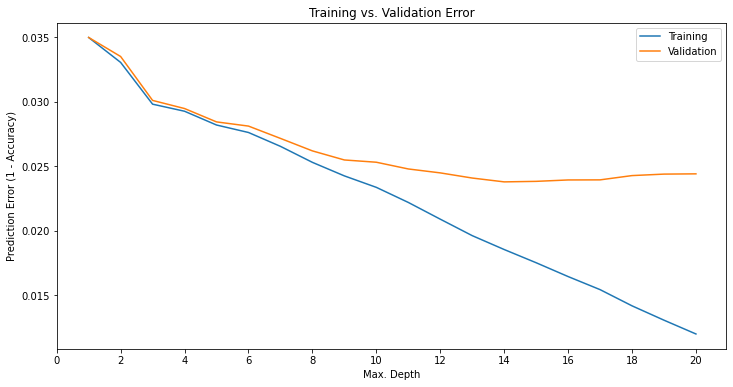

In [168]:
plt.figure(figsize = (12,6))
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 14 results in the lowest validation error.


In [169]:
model = DecisionTreeClassifier(max_depth=14, random_state=42).fit(train_inputs, train_targets)
model.score(val_inputs, val_targets)

0.9762116029396823

An improvement over the default arguments

In [170]:
model_text = export_text(model, feature_names=list(train_inputs.columns))
print(model_text[:3000])

|--- C7 <= 3.50
|   |--- C14 <= 0.50
|   |   |--- C1 <= 2.50
|   |   |   |--- id_17 <= 196.00
|   |   |   |   |--- C2 <= 1.50
|   |   |   |   |   |--- id_33 <= 220.50
|   |   |   |   |   |   |--- R_emaildomain <= 16.50
|   |   |   |   |   |   |   |--- C5 <= 0.50
|   |   |   |   |   |   |   |   |--- TransactionAmt <= 444.00
|   |   |   |   |   |   |   |   |   |--- id_09 <= 4.50
|   |   |   |   |   |   |   |   |   |   |--- TransactionDT <= 2568494.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- TransactionDT >  2568494.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- id_09 >  4.50
|   |   |   |   |   |   |   |   |   |   |--- TransactionDT <= 581024.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- TransactionDT >  581024.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated bran

Let's define a helper function to generate predictions, compute the accuracy score and plot a confusion matrix for a given set of inputs.

In [171]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize = (12,6))
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 98.15%


array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

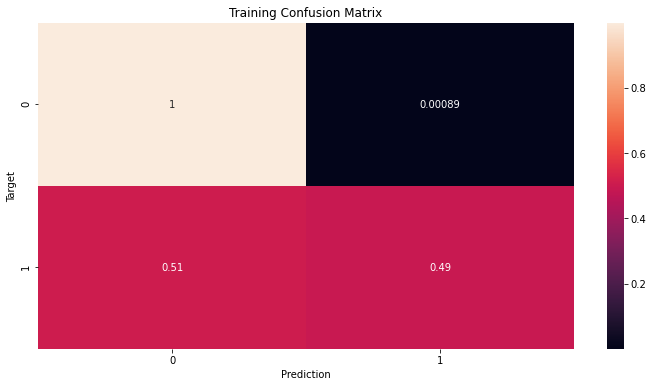

In [172]:
predict_and_plot(train_inputs, train_targets, 'Training')

Accuracy: 97.62%


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

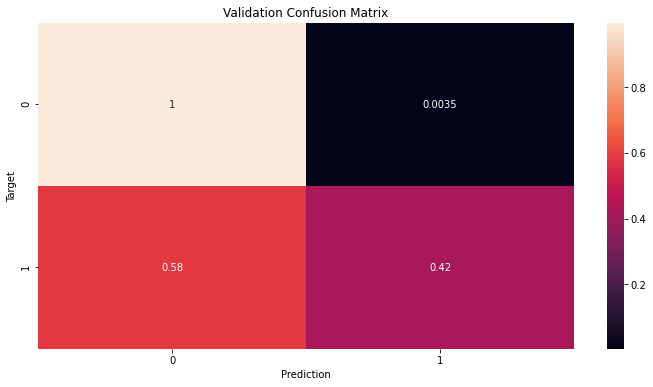

In [173]:
predict_and_plot(val_inputs, val_targets, 'Validation')

In [174]:
val_preds = model.predict(val_inputs)

In [175]:
print(classification_report(val_preds, val_targets))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    144979
           1       0.42      0.81      0.55      2656

    accuracy                           0.98    147635
   macro avg       0.71      0.90      0.77    147635
weighted avg       0.99      0.98      0.98    147635



In [176]:
print(f" AUC: {roc_auc_score(val_targets, model.predict_proba(val_inputs)[:,1])}")

 AUC: 0.8361561689669096


### Plot the ROC Curve

In [177]:
# Generate a no skill prediction class
ns_probs = [0 for _ in range(len(val_targets))]
dt_val_probs =  model.predict_proba(val_inputs)[:,1]

In [178]:
# Calculate roc scores
ns_fpr, ns_tpr, _ = roc_curve(val_targets,ns_probs)
dt_fpr, dt_tpr, _ = roc_curve(val_targets,dt_val_probs)

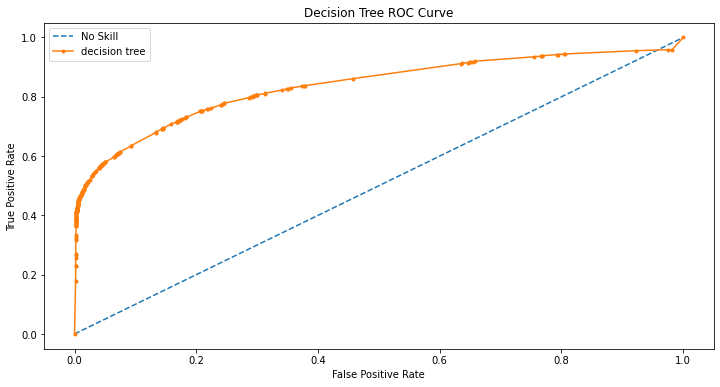

In [179]:
# Plot the roc curves
plt.figure(figsize = (12,6))
plt.title("Decision Tree ROC Curve")
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(dt_fpr, dt_tpr, marker='.', label='decision tree')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show();

In [180]:
#Area under the no skill curve
print(f" AUC: {roc_auc_score(val_targets, ns_probs)}")

 AUC: 0.5


In [181]:
#Area under the curve
print(f" AUC: {roc_auc_score(val_targets, dt_val_probs)}")

 AUC: 0.8361561689669096


### Plot the precision recall curve

Decision Tree: f1=0.551 auc=0.490


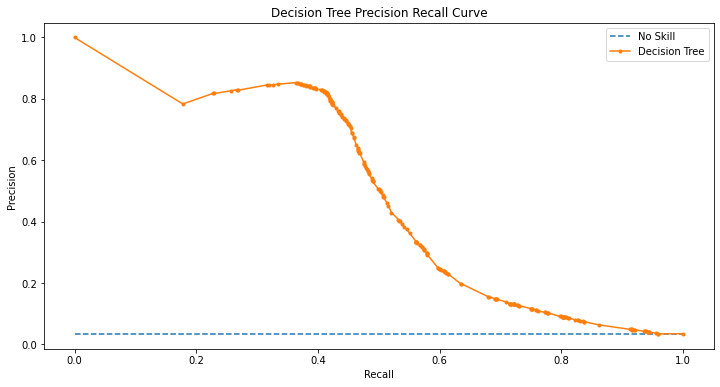

In [182]:
# Plot 
plt.figure(figsize = (12,6))
plt.title("Decision Tree Precision Recall Curve")

#Predict class values
dt_predictions =  model.predict(val_inputs)
dt_precision, dt_recall, _ = precision_recall_curve(val_targets, dt_val_probs)
dt_f1, dt_auc = f1_score(val_targets, dt_predictions), auc(dt_recall, dt_precision)
# summarize scores
print('Decision Tree: f1=%.3f auc=%.3f' % (dt_f1, dt_auc))
# plot the precision-recall curves
no_skill = len(val_targets[val_targets==1]) / len(val_targets)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(dt_recall, dt_precision, marker='.', label='Decision Tree')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with default hyperparameters. 

In [183]:
dt_model = DecisionTreeClassifier(random_state = 42)

In [184]:
%%time
dt_model.fit(inputs, targets)

Wall time: 1min 17s


DecisionTreeClassifier(random_state=42)

Accuracy: 97.69%


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

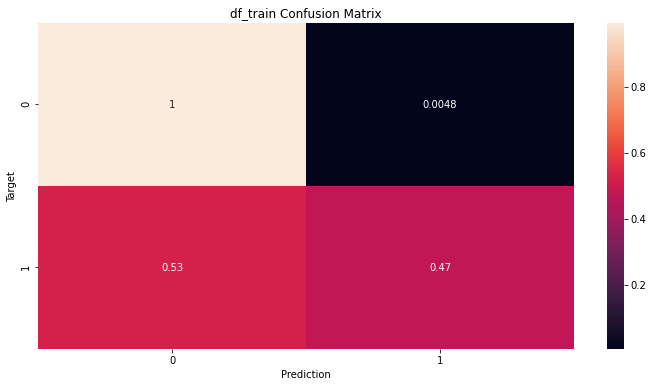

In [185]:
predict_and_plot(inputs, targets, 'df_train')

In [186]:
preds = dt_model.predict(inputs)
print(classification_report(preds, targets))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    569877
           1       1.00      1.00      1.00     20663

    accuracy                           1.00    590540
   macro avg       1.00      1.00      1.00    590540
weighted avg       1.00      1.00      1.00    590540



In [187]:
print(f" AUC: {roc_auc_score(targets, dt_model.predict_proba(inputs)[:,1])}")

 AUC: 1.0


Now that the model is trained, we can make predictions on the test set.

In [188]:
# Delivers predictions at the default threshhold of 0.5

test_preds = dt_model.predict(test_inputs)

In [189]:
test_preds

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [190]:
probs = dt_model.predict_proba(test_inputs)[:,1]

In [191]:
probs

array([0., 0., 0., ..., 0., 0., 1.])

Let's add the probability predictions into `sample_submission_df`.

In [192]:
sample_submission_df['isFraud'] = probs

In [193]:
sample_submission_df

TransactionID  isFraud
0             3663549      0.0
1             3663550      0.0
2             3663551      0.0
3             3663552      0.0
4             3663553      0.0
...               ...      ...
506686        4170235      0.0
506687        4170236      0.0
506688        4170237      0.0
506689        4170238      0.0
506690        4170239      1.0

[506691 rows x 2 columns]

We can now save the predictions as a CSV file.

In [194]:
sample_submission_df.to_csv('DTRsampleSubmission.csv', index = None)

In [195]:
from IPython.display import FileLink

In [196]:
FileLink('DTRsampleSubmission.csv')

C:\Users\Ochibobo\Credit-Card-Fraud-Detection\DTRsampleSubmission.csv

The predictions score an accuracy of `0.654819` Public score of `0.682037`. That's better than the random guess model but not all benign. Let's explore other classification models to improve the accuracy of our predictions and improve our ranking

## Logistic Regression

To train a LogisticRegression, we will use the `LogisicRegression` class from scikit-learn

In [197]:
log_model = LogisticRegression(solver='liblinear')

We can train the model using `model.fit`.

In [198]:
log_model.fit(train_inputs,train_targets)

LogisticRegression(solver='liblinear')

Let's check the weights and biases of the trained model.

In [199]:
print(input_cols)

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'PCA_V_0', 'PCA_V_1', 'PCA_V_2', 'PCA_V_3', 'PCA_V_4', 'PCA_V_5',
       'PCA_V_6', 'PCA_V_7', 'PCA_V_8', 'PCA_V_9'],
      dtype='object', length=109)


In [200]:
print(log_model.coef_.tolist())

[[-7.117874670002826e-07, 5.6583570968406e-08, 5.285150331433938e-05, -4.575906885215347e-07, -1.4303069294966207e-05, -2.62543381545238e-05, 8.2013271700277e-06, 3.47819505841858e-08, -1.0379709361205802e-05, -2.3211428465708028e-07, -0.000180833345956836, -0.00015551978468556212, -1.912803448214167e-05, 3.696368606989507e-05, -1.0604712553565355e-06, 1.9327668343485758e-06, 2.334059396883276e-05, 3.3507404210395715e-05, -1.4221164433272637e-08, 9.512256471270868e-06, -3.5401664088190924e-06, 7.36966493396132e-06, 8.429596207161998e-06, 1.5198415163449857e-05, -1.9024366991103307e-06, 1.2070442253032664e-05, 1.3857291443922204e-05, 1.4598174114126584e-05, -7.1764211785959605e-06, 1.0927580354281263e-06, -5.092202672196908e-05, -0.00012962343139893677, 1.1014303696724566e-06, -1.1693974845938368e-05, 0.00012539125474232113, 0.0001048255804493785, 0.00016272302153598606, 9.128940448355693e-05, 0.00012477373703379183, -1.703380259387699e-05, -0.00011109818632495357, 0.0001432645175009569

In [201]:
print(log_model.intercept_)

[-7.12927451e-10]


Each weight is applied to the value in a specific column of the input. Higher the weight, greater the impact of the column on the prediction.

## Making Predictions and Evaluating the Model

We can now use the trained model to make predictions on the training, test 

In [202]:
train_preds = log_model.predict(train_inputs)
train_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [203]:
train_targets

253163    0
436811    0
150018    0
325111    0
247143    0
         ..
342767    0
324259    0
398337    1
29747     0
337290    0
Name: isFraud, Length: 442905, dtype: int64

We can output a probabilistic prediction using `predict_proba`.

In [204]:
train_probs = log_model.predict_proba(train_inputs)
train_probs

array([[0.98356193, 0.01643807],
       [0.97750865, 0.02249135],
       [0.93458189, 0.06541811],
       ...,
       [0.79517003, 0.20482997],
       [0.9837097 , 0.0162903 ],
       [0.97365111, 0.02634889]])

The numbers above indicate the probabilities for the target classes `0` and `1` 

In [205]:
log_model.classes_

array([0, 1], dtype=int64)

We can test the accuracy of the model's predictions by computing the percentage of matching values in `train_preds` and `train_targets`.

This can be done using the `accuracy_score` function from `sklearn.metrics`.

In [206]:
accuracy_score(train_targets, train_preds)

0.9650105553109584

The model achieves an accuracy of 96.5 on the training set. We can visualize the breakdown of correctly and incorrectly classified inputs using a confusion matrix.

<img src="https://i.imgur.com/UM28BCN.png" width="480">

In [207]:
confusion_matrix(train_targets, train_preds, normalize = 'true')

array([[1., 0.],
       [1., 0.]])

In [208]:
print(classification_report(train_preds, train_targets))
print(f" AUC: {roc_auc_score(train_targets, train_probs[:,1])}")

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      0.97      0.98    442905
           1       0.00      0.00      0.00         0

    accuracy                           0.97    442905
   macro avg       0.50      0.48      0.49    442905
weighted avg       1.00      0.97      0.98    442905

 AUC: 0.6976602781828669


Let's define a helper function to generate predictions, compute the accuracy score and plot a confusion matrix for a given set of inputs.

In [209]:
def predict_and_plot(inputs, targets, name=''):
    preds = log_model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize = (12,6))
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 96.50%


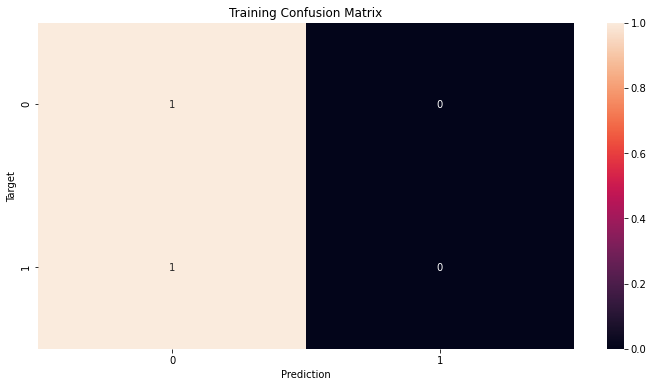

In [210]:
train_preds = predict_and_plot(train_inputs, train_targets, 'Training')

Let's compute the model's accuracy on the validation set too.

Accuracy: 96.50%


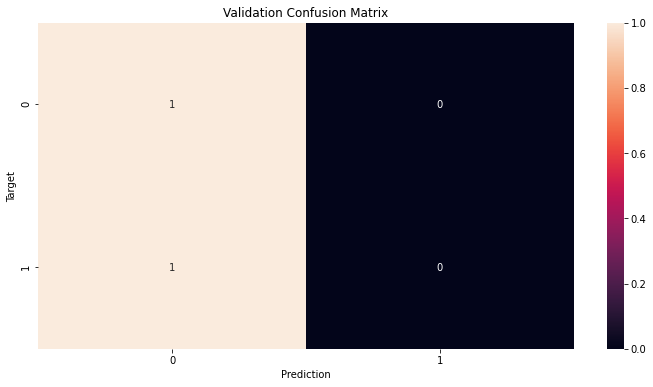

In [211]:
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

The accuracy of the model on the validation set is at 96.50%. 

Let's check the accuracies of these two models on the training set.

In [212]:
accuracy_score(train_targets, random_guess(train_inputs))

0.5002178796807442

In [213]:
accuracy_score(train_targets, all_benign(train_inputs))

0.9650105553109584

Our random model achieves an accuracy of 50% and our "always benign" model achieves an accuracy of 96.50%. 

### Plot the ROC Curve

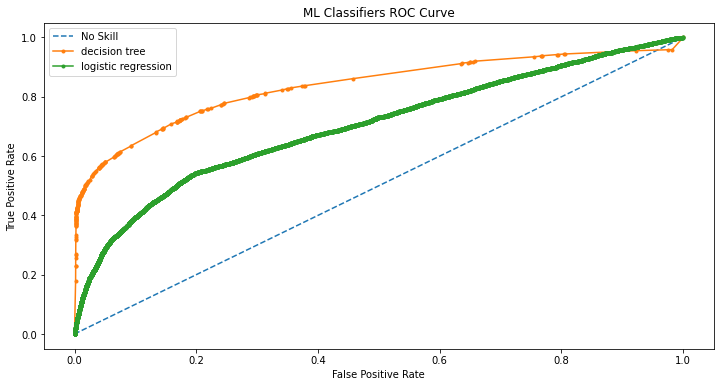

In [214]:
# Generate a no-skill prediction class & the model probabilities
ns_probs = [0 for _ in range(len(val_targets))]
log_val_probs =  log_model.predict_proba(val_inputs)[:,1]
# Calculate roc scores
ns_fpr, ns_tpr, _ = roc_curve(val_targets,ns_probs)
log_fpr, log_tpr, _ = roc_curve(val_targets,log_val_probs)

# Plot the roc curves
plt.figure(figsize = (12,6))
plt.title("ML Classifiers ROC Curve")
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(dt_fpr, dt_tpr, marker='.', label='decision tree')
pyplot.plot(log_fpr, log_tpr, marker='.', label='logistic regression')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show();

In [215]:
#Area under the curve
print(f" AUC: {roc_auc_score(val_targets, log_val_probs)}")

 AUC: 0.7013325163819691


### Plot the Precision Recall Curve

Logistic: f1=0.000 auc=0.123


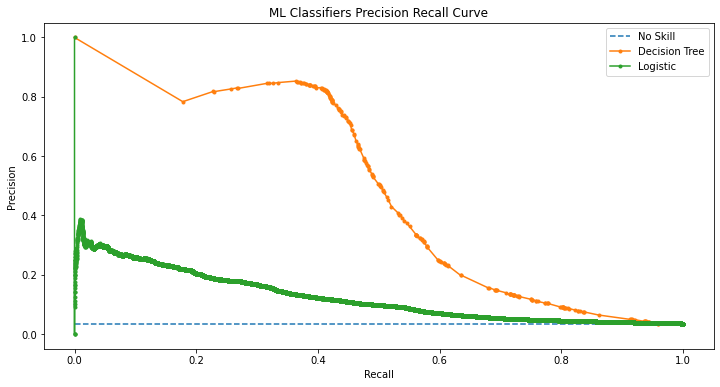

In [216]:
# Plot 
plt.figure(figsize = (12,6))
plt.title("ML Classifiers Precision Recall Curve")

#Predict class values
log_predictions =  log_model.predict(val_inputs)
log_precision, log_recall, _ = precision_recall_curve(val_targets, log_val_probs)
log_f1, log_auc = f1_score(val_targets, log_predictions), auc(log_recall, log_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (log_f1, log_auc))
# plot the precision-recall curves
no_skill = len(val_targets[val_targets==1]) / len(val_targets)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(dt_recall, dt_precision, marker='.', label='Decision Tree')
pyplot.plot(log_recall, log_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

The decision tree performs better than the logistic regression model on the validation set. Lets' examine the performance on the test set

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with default hyperparameters. 

In [217]:
lr_model = LogisticRegression(solver='liblinear')

In [218]:
lr_model.fit(inputs,targets)

LogisticRegression(solver='liblinear')

In [219]:
def predict_and_plot(inputs, targets, name=''):
    preds = lr_model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize = (12,6))
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 96.50%


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

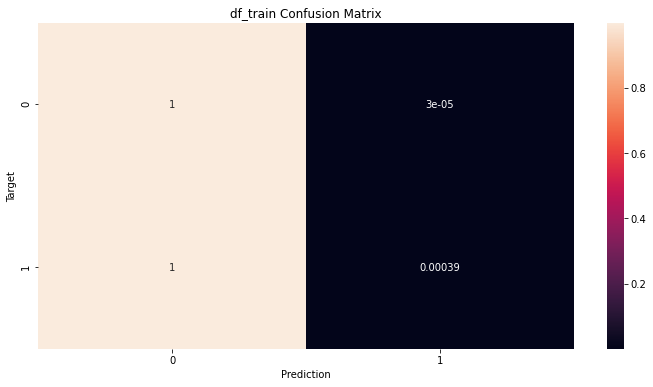

In [220]:
predict_and_plot(inputs, targets, 'df_train')

In [221]:
preds = log_model.predict(inputs)
print(classification_report(preds, targets))
probs = log_model.predict_proba(inputs)[:,1]
print(f" AUC: {roc_auc_score(targets, probs)}")

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      0.97      0.98    590540
           1       0.00      0.00      0.00         0

    accuracy                           0.97    590540
   macro avg       0.50      0.48      0.49    590540
weighted avg       1.00      0.97      0.98    590540

 AUC: 0.6985734950231155


In [222]:
# Delivers predictions at the default threshhold of 0.5

test_preds = log_model.predict(test_inputs)

In [223]:
sample_submission_df = pd.read_csv('C:/Users/Ochibobo/Credit-Card-Fraud-Detection/ieee-fraud-detection/sample_submission.csv')

In [224]:
sample_submission_df['isFraud'] = log_model.predict_proba(test_inputs)[:,1]

In [225]:
sample_submission_df

TransactionID   isFraud
0             3663549  0.023638
1             3663550  0.024977
2             3663551  0.024848
3             3663552  0.025294
4             3663553  0.023233
...               ...       ...
506686        4170235  0.059928
506687        4170236  0.227067
506688        4170237  0.040314
506689        4170238  0.041695
506690        4170239  0.254417

[506691 rows x 2 columns]

We can now save the predictions as a CSV file.

In [226]:
sample_submission_df.to_csv('LogRegsampleSubmission.csv', index = None)

In [227]:
from IPython.display import FileLink

In [228]:
FileLink('LogRegsampleSubmission.csv')

C:\Users\Ochibobo\Credit-Card-Fraud-Detection\LogRegsampleSubmission.csv

The predictions score an accuracy of `0.758491` Public score of `0.798960` more accurate than the `DecisionTreeClassifier` however let's explore ensemble methods to improve the accuracy of our predictions

## Training a Random Forest

While tuning the hyperparameters of a single decision tree or running a logistic regression may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

In [229]:
rf_model = RandomForestClassifier(random_state = 42, n_jobs = -1)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution (fix the randomness).

In [230]:
%%time
rf_model.fit(train_inputs, train_targets)

Wall time: 2min 41s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [231]:
rf_model.score(train_inputs, train_targets)

0.999986453076845

In [232]:
rf_model.score(val_inputs, val_targets)

0.9821790225894944

The training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree and the Logistic regressor we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">

We can can access individual decision trees using `model.estimators_`

In [233]:
rf_model.estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=1608637542)

In [234]:
len(rf_model.estimators_)

100

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [235]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

In [236]:
importance_df.head(10)

feature  importance
16               C1    0.044795
0     TransactionID    0.038455
1     TransactionDT    0.038360
2    TransactionAmt    0.035914
4             card1    0.032725
28              C13    0.032261
5             card2    0.029341
108         PCA_V_9    0.028802
106         PCA_V_7    0.027606
29              C14    0.024853

In [237]:
train_df.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... id_35  id_36  id_37  id_38  \
0 -999.0  150.0    discover  142.0  ...  -999   -999   -999   -999   
1  404.0  150.0  mastercard  102.0  ...  -999   -999   -999   -999   
2  490.0  150.0        visa  166.0  ...  -999   -999   -999   -999   
3  567.0  150.0  mastercard  117.0  ...  -999   -999   -999   -999   
4  514.0  150.0  mastercard  102.0  ...     T      F      T      T   

   DeviceType                     DeviceInfo P_emaildomain_bin  \
0        -999                           -999              -999   
1        -999                           -999            google   
2        -999                           -999         microsoft   
3        -999                           -999             yahoo   
4      mobile  SAMSUNG SM-G892A Build/NRD90M            google   

   P_emaildomain_suffix  R_emaildomain_bin  R_emaildomain_suffix  
0                   nan               -999                   nan  
1                   com               -999                   nan  
2                   com               -999                   nan  
3                   com               -999                   nan  
4                   com               -999                   nan  

[5 rows x 438 columns]

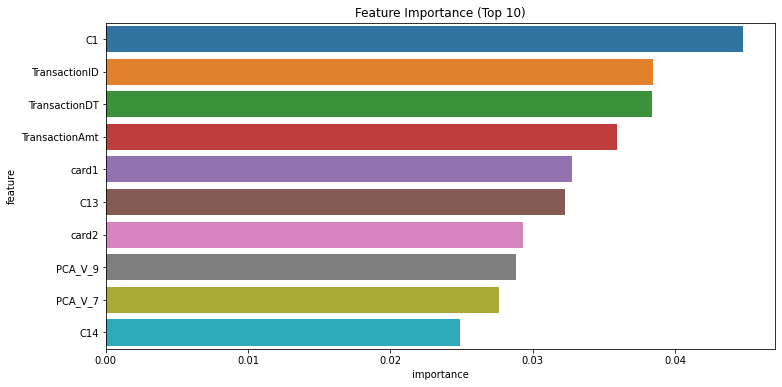

In [238]:
plt.figure(figsize=(12,6))
plt.title('Feature Importance (Top 10)')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [239]:
base_model = RandomForestClassifier(random_state = 42, n_jobs = -1).fit(train_inputs, train_targets)

In [240]:
base_train_acc = base_model.score(train_inputs, train_targets)
base_val_acc = base_model.score(val_inputs, val_targets)

In [241]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.999986453076845, 0.9821790225894944)

We can use this as a benchmark for hyperparmeter tuning. Parameters whose accuracy is indicated above. Let's define a function to test hyperparameters `test_params`

In [242]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    return model.score(train_inputs, train_targets), model.score(val_inputs, val_targets)

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 

**10 estimators**

In [243]:
test_params(n_estimators=10)

(0.9971393413937526, 0.9810681748907779)

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

In [244]:
test_params(max_depth=26)

(0.9938655016312753, 0.9814407152775426)

In [245]:
test_params(max_leaf_nodes=2**20)

(0.9999932265384225, 0.9821045145121414)

In [246]:
base_accs

(0.999986453076845, 0.9821790225894944)

The default parameters seem to have the optimal values of `n_estimators`, `max_depth` and `max_leaf_nodes`.

### Plot the ROC Curve

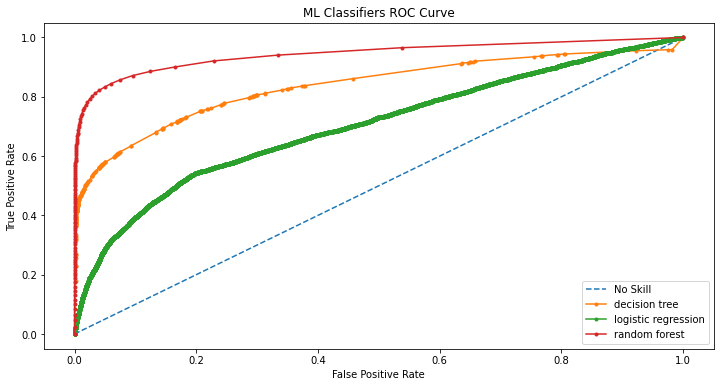

In [247]:
# Generate a no-skill prediction class & the model probabilities
ns_probs = [0 for _ in range(len(val_targets))]
rf_val_probs =  rf_model.predict_proba(val_inputs)[:,1]
# Calculate roc scores
ns_fpr, ns_tpr, _ = roc_curve(val_targets,ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(val_targets,rf_val_probs)

# Plot the roc curves
plt.figure(figsize = (12,6))
plt.title("ML Classifiers ROC Curve")
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(dt_fpr, dt_tpr, marker='.', label='decision tree')
pyplot.plot(log_fpr, log_tpr, marker='.', label='logistic regression')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='random forest')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show();

In [248]:
#Area under the curve
print(f" AUC: {roc_auc_score(val_targets, rf_val_probs)}")

 AUC: 0.9433097123257875


### Plot the Precision-recall curve

Random Forest: f1=0.667 auc=0.784


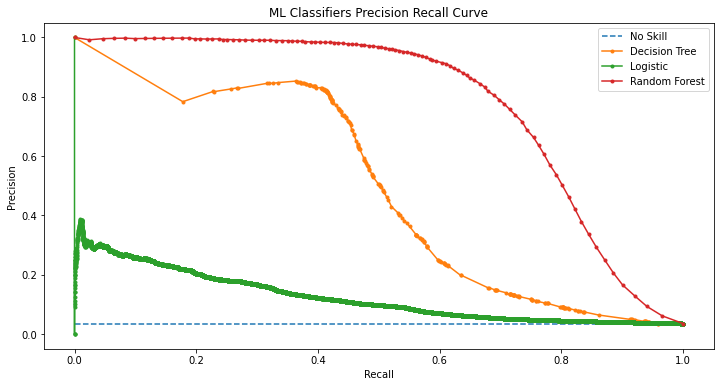

In [249]:
# Plot 
plt.figure(figsize = (12,6))
plt.title("ML Classifiers Precision Recall Curve")

#Predict class values
rf_predictions =  rf_model.predict(val_inputs)
rf_precision, rf_recall, _ = precision_recall_curve(val_targets, rf_val_probs)
rf_f1, rf_auc = f1_score(val_targets, rf_predictions), auc(rf_recall, rf_precision)
# summarize scores
print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
# plot the precision-recall curves
no_skill = len(val_targets[val_targets==1]) / len(val_targets)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(dt_recall, dt_precision, marker='.', label='Decision Tree')
pyplot.plot(log_recall, log_precision, marker='.', label='Logistic')
pyplot.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

The random forest outperforms the decision tree and the logistic regression

### Putting it together

Let's train a random forest with default hyperparameters based on our learnings. 

In [250]:
random_forest_model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42)

In [251]:
%%time
random_forest_model.fit(inputs, targets)

Wall time: 3min 48s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [252]:
def predict_and_plot(inputs, targets, name=''):
    preds = random_forest_model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize = (12,6))
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 100.00%


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

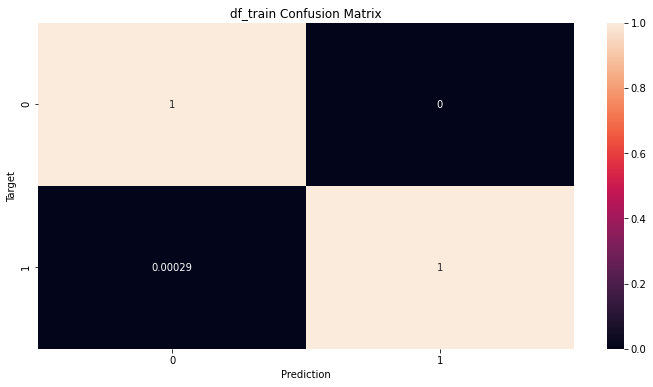

In [253]:
predict_and_plot(inputs, targets, 'df_train')

In [254]:
preds = random_forest_model.predict(inputs)
print(classification_report(preds, targets))
probs = random_forest_model.predict_proba(inputs)[:,1]
print(f" AUC: {roc_auc_score(targets, probs)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    569883
           1       1.00      1.00      1.00     20657

    accuracy                           1.00    590540
   macro avg       1.00      1.00      1.00    590540
weighted avg       1.00      1.00      1.00    590540

 AUC: 1.0


Now that the model is trained, we can make predictions on the test set.

In [255]:
# Delivers predictions at the default threshhold of 0.5
test_preds_rf = random_forest_model.predict(test_inputs)

In [256]:
test_probs = random_forest_model.predict_proba(test_inputs)[:,1]

Let's add the predictions into `sample_submission_df`.

In [257]:
sample_submission_df['isFraud'] = test_probs

We can now save the predictions as a CSV file.

In [258]:
sample_submission_df.to_csv('RFsampleSubmission.csv', index = None)

In [259]:
from IPython.display import FileLink

In [260]:
FileLink('RFsampleSubmission.csv')

C:\Users\Ochibobo\Credit-Card-Fraud-Detection\RFsampleSubmission.csv

The predictions score an accuracy of `0.864594` Public score of  `0.904251` the highest score thus far. Let's explore an `XGBClassifier`

### Save and Load the model using joblib

In [262]:
import joblib

#save the model to disk
filename = 'random_forest_model'
joblib.dump(random_forest_model, filename)

['random_forest_model']

In [263]:
#Load the model
loaded_model = joblib.load(filename)
result = loaded_model.score(inputs, targets)
print(result)

0.9999898398076337


### XGBRegressor
To train a GBM, we can use the `XGBClassifier` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [264]:
Xgboost_model = XGBClassifier(random_state = 42, n_jobs = -1, n_estimators = 20, max_depth = 4)

Let's train the model using `model.fit`.

In [265]:
%%time
Xgboost_model.fit(train_inputs, train_targets)

Wall time: 31.5 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [266]:
Xgboost_model.predict(val_inputs) == (Xgboost_model.predict_proba(val_inputs)[:,1] >= 0.5).astype(bool)

array([ True,  True,  True, ...,  True,  True,  True])

In [267]:
preds = Xgboost_model.predict(val_inputs) #default threshold= 0.5
preds

array([0, 0, 0, ..., 0, 0, 0])

### Evaluation

Let's evaluate the predictions using RMSE error.

In [268]:
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [270]:
rmse(preds, val_targets)

0.16373564341309488

### Visualization

We can visualize individual trees as text

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [271]:
trees = Xgboost_model.get_booster().get_dump()

In [272]:
len(trees)

20

In [273]:
print(trees[0])

0:[C7<3.5] yes=1,no=2,missing=1
	1:[C14<0.5] yes=3,no=4,missing=3
		3:[C1<2.5] yes=7,no=8,missing=7
			7:[id_17<196] yes=15,no=16,missing=15
				15:leaf=-0.516550779
				16:leaf=-0.293057978
			8:[id_02<-479] yes=17,no=18,missing=17
				17:leaf=-0.35409838
				18:leaf=0.325266927
		4:[C4<1.5] yes=9,no=10,missing=9
			9:[PCA_V_9<-0.0213088989] yes=19,no=20,missing=19
				19:leaf=-0.529407918
				20:leaf=-0.580616355
			10:[C1<5.5] yes=21,no=22,missing=21
				21:leaf=-0.528987885
				22:leaf=-0.163790673
	2:[C13<19.5] yes=5,no=6,missing=5
		5:[C1<8.5] yes=11,no=12,missing=11
			11:[C11<24.5] yes=23,no=24,missing=23
				23:leaf=-0.42235294
				24:leaf=0.564705908
			12:[id_19<164.5] yes=25,no=26,missing=25
				25:leaf=0.192380965
				26:leaf=0.494097024
		6:[PCA_V_3<-0.486450195] yes=13,no=14,missing=13
			13:[C8<64] yes=27,no=28,missing=27
				27:leaf=-0.330612242
				28:leaf=0.407142848
			14:[PCA_V_7<0.237548828] yes=29,no=30,missing=29
				29:leaf=-0.469362378
				30:leaf=0.0960000008

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [275]:
importance_df = pd.DataFrame({
    'feature': inputs.columns,
    'importance': Xgboost_model.feature_importances_
}).sort_values('importance', ascending=False)

In [276]:
importance_df.head(10)

feature  importance
22             C7    0.221820
16             C1    0.035253
29            C14    0.033341
27            C12    0.032885
20             C5    0.032297
74          id_20    0.029856
71          id_17    0.027799
15  R_emaildomain    0.026552
66          id_12    0.025247
19             C4    0.023078

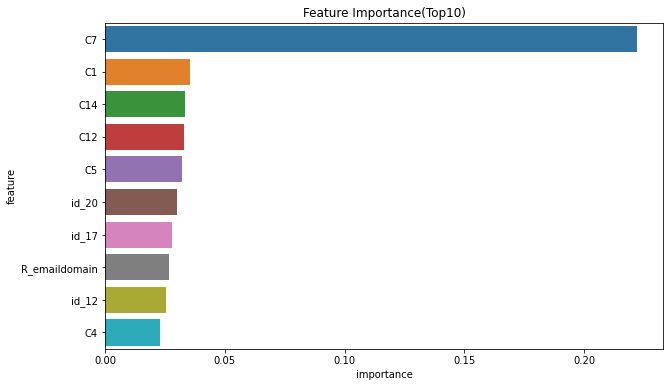

In [277]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance(Top10)')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

 A different set of features have been ranked as the most important relative to the `RandomForestClassifier`. 
 
 Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [278]:
def train_and_evaluate(train_inputs, train_targets, val_inputs, val_targets, **params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(train_inputs, train_targets)
    train_rmse = rmse(model.predict(train_inputs), train_targets)
    val_rmse = rmse(model.predict(val_inputs), val_targets)
    return model, train_rmse, val_rmse

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [279]:
def test_params(**params):
    model = XGBClassifier(n_jobs=-1, random_state=42, **params)
    model.fit(train_inputs, train_targets)
    train_rmse = rmse(model.predict(train_inputs), train_targets)
    val_rmse = rmse(model.predict(val_inputs), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.


In [280]:
test_params(n_estimators=30)

Train RMSE: 0.14857560796173866, Validation RMSE: 0.15233476085466935


In [281]:
test_params(n_estimators=100)

Train RMSE: 0.12998181024631336, Validation RMSE: 0.14027439496483804


In [282]:
test_params(n_estimators=200)

Train RMSE: 0.11406936350507442, Validation RMSE: 0.132297485676642


#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [283]:
test_params(max_depth=5)

Train RMSE: 0.13983913463103123, Validation RMSE: 0.14600028624806138


In [284]:
test_params(max_depth=10)

Train RMSE: 0.07507010078927973, Validation RMSE: 0.12234929540606941



#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [285]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 0.16483510611527988, Validation RMSE: 0.1656072037305631


In [286]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 0.15697723790119258, Validation RMSE: 0.15933277752118968


In [287]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 0.14163592542905656, Validation RMSE: 0.14793598060319593


In [288]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 0.12565404465135166, Validation RMSE: 0.14544249897005662


#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [289]:
test_params(booster='gblinear')

Train RMSE: 0.18289852080030683, Validation RMSE: 0.18368073420400619


Clearly, a linear model is not well suited for this dataset.

### Plot the ROC Curve

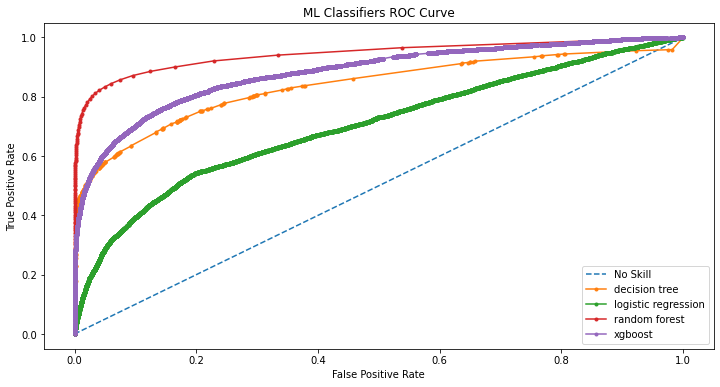

In [290]:
# Generate a no-skill prediction class & the model probabilities
ns_probs = [0 for _ in range(len(val_targets))]
xgboost_val_probs =  Xgboost_model.predict_proba(val_inputs)[:,1]
# Calculate roc scores
ns_fpr, ns_tpr, _ = roc_curve(val_targets,ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(val_targets, xgboost_val_probs)

# Plot the roc curves
plt.figure(figsize = (12,6))
plt.title("ML Classifiers ROC Curve")
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(dt_fpr, dt_tpr, marker='.', label='decision tree')
pyplot.plot(log_fpr, log_tpr, marker='.', label='logistic regression')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='random forest')
pyplot.plot(xgb_fpr, xgb_tpr, marker='.', label='xgboost')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show();

In [291]:
#Area under the curve
print(f" AUC: {roc_auc_score(val_targets, xgboost_val_probs)}")

 AUC: 0.8816071090355748


In this case random forest is the best performing ML model, followed by Xgboost, decision trees and logistic regression

### Plot the Precision -Recall Curve'

XGBoost: f1=0.418 auc=0.508


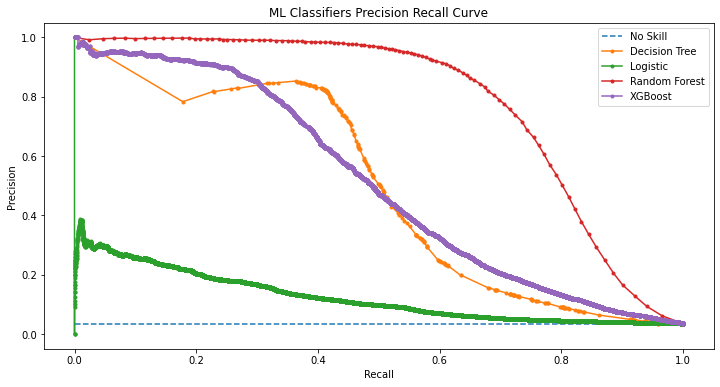

In [292]:
# Plot 
plt.figure(figsize = (12,6))
plt.title("ML Classifiers Precision Recall Curve")

#Predict class values
xgboost_predictions =  Xgboost_model.predict(val_inputs)
xgboost_precision, xgboost_recall, _ = precision_recall_curve(val_targets, xgboost_val_probs)
xgboost_f1, xgboost_auc = f1_score(val_targets, xgboost_predictions), auc(xgboost_recall, xgboost_precision)
# summarize scores
print('XGBoost: f1=%.3f auc=%.3f' % (xgboost_f1, xgboost_auc))
# plot the precision-recall curves
no_skill = len(val_targets[val_targets==1]) / len(val_targets)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(dt_recall, dt_precision, marker='.', label='Decision Tree')
pyplot.plot(log_recall, log_precision, marker='.', label='Logistic')
pyplot.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
pyplot.plot(xgboost_recall, xgboost_precision, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with default hyperparameters. 

In [293]:
XGB_model = XGBClassifier(n_jobs=-1, random_state=42)

In [294]:
%%time
XGB_model.fit(inputs, targets)

Wall time: 4min 31s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

Let's define a helper function to generate predictions, compute the accuracy score and plot a confusion matrix for a given set of inputs.

In [295]:
def predict_and_plot(inputs, targets, name=''):
    preds = XGB_model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize = (12,6))
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 98.28%


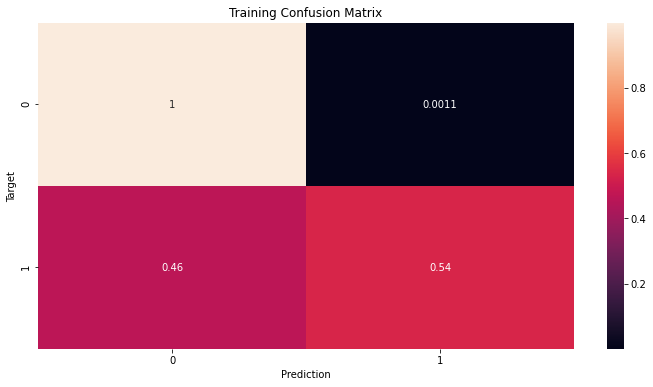

In [296]:
train_preds = predict_and_plot(inputs, targets, 'Training')

In [297]:
preds = XGB_model.predict(inputs)
print(classification_report(preds, targets))
probs = XGB_model.predict_proba(inputs)[:,1]
print(f" AUC: {roc_auc_score(targets, probs)}")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    578819
           1       0.54      0.95      0.69     11721

    accuracy                           0.98    590540
   macro avg       0.77      0.97      0.84    590540
weighted avg       0.99      0.98      0.99    590540

 AUC: 0.9601260828097379


Now that the model is trained, we can make predictions on the test set.

In [298]:
test_preds_xgb = XGB_model.predict(test_inputs)

In [299]:
test_probs = XGB_model.predict_proba(test_inputs)[:,1]

Let's add the predictions into `sample_submission_df`.

In [300]:
sample_submission_df['isFraud'] = test_probs

We can now save the predictions as a CSV file.

In [301]:
sample_submission_df.to_csv('XGBsampleSubmission.csv', index = None)

In [302]:
from IPython.display import FileLink

In [303]:
FileLink('XGBsampleSubmission.csv')

C:\Users\Ochibobo\Credit-Card-Fraud-Detection\XGBsampleSubmission.csv

The predictions score an accuracy of `0.884817` Public score of `0.920733` the highest score we have gotten making XGB our predictor model

### Save and Load the model using pickle

In [304]:
import pickle

#save the model to disk
filename = 'xgb_model'
pickle.dump(XGB_model, open(filename, 'wb'))

In [305]:
#Load the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(inputs, targets)
print(result)

0.9828292749009381
